# Proyección con MEDGE en python

El Modelo de Proyección Trimestral (MPT) del BCRP es un modelo semiestructural basado en el marco neokeynesiano, diseñado para el análisis de una economía pequeña y abierta. Este modelo es útil para:

* Proyectar la evolución futura de la economía: Permite generar escenarios y pronósticos sobre las principales variables macroeconómicas.
* Analizar la coyuntura económica reciente: Facilita la evaluación del impacto de diversos eventos y políticas en la economía.

La versión que se estudiará en este curso, denominada "MPT de bolsillo", es una simplificación del modelo completo. A pesar de su simplificación, conserva los principales canales de transmisión de choques y de la política monetaria, lo que permite comprender los mecanismos fundamentales que operan en la economía peruana.

**Revisar**: Aguirre y otros (2022), Winkelried (2013), Vega y otros (2009).

En esta sesión nos enfocaremos en dos de las ecuaciones principales del modelo.

## Curva de Phillips

$$\pi_t^{sae} = b_m \Pi_t^{m} + (1 - b_m) \left[b_{sae} \pi_{t-1}^{sae} + (1 - b_{sae}) \Pi_{t}^{e}\right] + b_y \left[c_y y_t + (1 - c_y) y_{t-1}\right] + \sigma_{\varepsilon^{\pi,sae}} \varepsilon_t^{sae} $$

## Regla de Taylor

$$ i_t = \phi  i_{t-1} + (1 - \phi) \left( i^{n}_t + f_p D4pdev_t + f_y \left( c_{fy} y + (1 - c_{fy}) y_{t-1} \right) \right) + \sigma_{\varepsilon^{i}} \varepsilon^{i}_t $$

**Tarea**: revisar el resto del MPT y sus canales de transmisión:
1. Impacto del sector externo (inflación, tasa externa, brecha externa y TI)
2. Impacto de choques fiscales
3. Impacto de la confianza empresarial/expectativas
4. Choques de costos

En general, la estimación de un modelo de equilibrio general (como un semiestructural o un DSGE), implica tres pasos:
1. Plantear el modelo teórico, i.e., canales de transmisión y relación entre variables a estudiar: Esto nos da la **forma estructural** el modelo
$$\mathbf{f}_{0}+\mathbf{f}_{y'}\mathrm{E}_t\mathbf{y}_{t+1}+\mathbf{f}_{y}\mathbf{y}_{t}+\mathbf{f}_{y^{\ell}}\mathbf{y}_{t-1}+\mathbf{f}_{u}\mathbf{u}_{t}=0$$
2. Resolver el modelo, se deben cuplir las condiciones de BK: De esto se obtiene la **forma reducida** el modelo
$$\mathbf{y}_{t} = \mathbf{g}_{0}+\mathbf{g}_{y}\mathbf{y}_{t-1}+\mathbf{g}_{u}\mathbf{u}_{t}$$
3. Reescribir el modelo como una representación de espacio estado:
$$\text{Medidas}:\quad\mathbf{z}_{t} = \mathbf{H}\mathbf{y}_{t}$$
$$\text{Estados}:\quad\mathbf{y}_{t} = \mathbf{g}_{0}+\mathbf{g}_{y}\mathbf{y}_{t-1}+\mathbf{g}_{u}\mathbf{u}_{t}$$
4. Con los datos, $\mathbf{z}_{t}$, el FK nos da la verosimilitud, si además se formulan los prior para los coeficientes, se puede etimar la posterior
5. Repetir 1-4 hasta maximizar la posterior, y luego implementar MH para simular la posterior


El modelo de esta sesión ya ha sido estimado

## Librerias requeridas

Configuración inicial para modo de ejecución

In [6]:
flag_runlocal = False    # "False" para ejecutar en google colab

Las librerías a continuación han sido desarrolladas para estre curso. Éstas se encargan del procesamiento del modelo, la implementación numérica de la solución y calculos de productos asociados (IRF, KF y proyección), ademas del manejo de los datos.

In [7]:
import sys
import os

if flag_runlocal:
    # ---> Ejecución local
    pathPolMon = os.getcwd() + '/'

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/jamayat/CUECOPolMon.git
    pathPolMon = '/content/CUECOPolMon/'

sys.path.append(pathPolMon+'02_Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

Cloning into 'CUECOPolMon'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 690 (delta 22), reused 14 (delta 14), pack-reused 662 (from 3)
Receiving objects: 100% (690/690), 95.93 MiB | 22.06 MiB/s, done.
Resolving deltas: 100% (414/414), done.
IPython console for SymPy 1.13.1 (Python 3.11.11-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.1/



Librería externas complementarias

In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

## Procesamiento el modelo

La función ```process_file3``` lee el modelo y construye las funciones necesarias para computar la solución:

**ver modelo**: 04_Modelo/MPTBolsillo.txt

En ese archivo se declaran variables endógenas, exógenas y observables (recordar filtro de Kalman).


In [9]:
Mod = DPP.process_file3(pathPolMon+'04_Modelo/MPTBolsillo.txt')

El objeto de salida ```Mod``` es un diccionario con información sobre el modelo y funciones vinculadas a la forma estructural del modelo

In [10]:
Mod.keys()

dict_keys(['Desc.', 'FunMatForm', 'Rearranging_index', 'StateSpaceForm'])

### Solución del modelo

A continuación se resuelve el modelo y se verifican las condiciones de estabilidad.
Es necesario incluir una calibración de coeficientes y un estado estacionario (**ver**: 04_Modelo/Cal_MPTBolsillo.txt)

**Nota**: En caso deseen hacer cambios en coeficientes, estos deben ocurrir en esta etapa

In [11]:
Mod = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsillo.txt", True)

-> Stability conditions met

Steady state
            User supplied  Numerical
DY_eq                5.30       5.30
DYs_eq               2.10       2.10
Ds                   0.00       0.00
y                    0.00       0.00
ys                   0.00       0.00
Dpae                 2.00       2.00
Dp                   2.00       2.00
Dp(-2)               2.00       2.00
Dp(-1)               2.00       2.00
D4p                  2.00       2.00
Dpsae                2.00       2.00
Dpsae(-2)            2.00       2.00
Dpsae(-1)            2.00       2.00
ED4p                 2.00       2.00
Dpm                  2.00       2.00
Dpm(-2)              2.00       2.00
Dpm(-1)              2.00       2.00
Meta                 2.00       2.00
i                    3.75       3.75
ieq                  3.75       3.75
zmn                  1.75       1.75
zme                  0.00       0.00
Ds(-2)               0.00       0.00
Ds(-1)               0.00       0.00
ED4s                 0.00       0

Ahora ```Mod``` contiene una llave adiciona: 'Solution'

In [12]:
Mod.keys()

dict_keys(['Desc.', 'FunMatForm', 'Rearranging_index', 'StateSpaceForm', 'Solution'])

### Estudio de las FIR

La función ```getIRF``` generar todos los FIRs

In [13]:
Horizon=20
IRF = DLM.getIRF(Mod,Horizon)

```IRF``` es un diccionario cuyas "keys" son los choques, dentro de cada "key" se encuentran las respuestas de todas las endogenas ante ese choques.

El impulso (o choque) esta fijado en 1. Debido a que en el modelo se multiplica a los choques por su desviación estándar, entonces las respuestas son ante choques de 1 desviación estándar.

In [14]:
IRF.keys()

dict_keys(['res_DY_eq', 'res_Dpae', 'res_Dpsae', 'res_ED4p', 'res_Dpm', 'res_Meta', 'res_i', 'res_ieq', 'res_imn', 'res_zmn', 'res_ime', 'res_zme', 'res_Ds', 'res_ED4s', 'res_x', 'res_x_eq', 'res_DQ_eq', 'res_y', 'res_EDy', 'res_t', 'res_g', 'res_DTI', 'res_tau', 'res_DYs_eq', 'res_Dps', 'res_Dpms', 'res_iext', 'res_ys', 'res_ieqs', 'res_z'])

Por ejemplo, a continuación se pueden apreciar las respuestas ante un choque a la inflación AE

In [15]:
IRF['res_Dpae'].head(5)

DY_eq  DYs_eq        Ds         y   ys      Dpae        Dp    Dp(-2)  \
0    0.0     0.0 -0.146240 -0.009528  0.0  3.956719  1.783490  0.000000   
1    0.0     0.0 -0.205642 -0.010296  0.0 -0.042675  0.020465  0.000000   
2    0.0     0.0 -0.236798  0.004243  0.0 -0.035848  0.040351  1.783490   
3    0.0     0.0 -0.243212  0.020689  0.0 -0.028240  0.052125  0.020465   
4    0.0     0.0 -0.229679  0.033654  0.0 -0.020052  0.058398  0.040351   

     Dp(-1)       D4p  ...   D4s(+1)    x        DQ     DQ_eq  D4ps  D4ps(+3)  \
0  0.000000  0.445872  ... -0.087971  0.0 -1.929730 -0.354504   0.0       0.0   
1  1.783490  0.450989  ... -0.147170  0.0 -0.226107 -0.330917   0.0       0.0   
2  0.020465  0.461076  ... -0.207973  0.0 -0.277149 -0.321039   0.0       0.0   
3  0.040351  0.474108  ... -0.228833  0.0 -0.295337 -0.316318   0.0       0.0   
4  0.052125  0.042835  ... -0.228523  0.0 -0.288077 -0.311130   0.0       0.0   

   D4ps(+2)  D4ps(+1)   Rs  Rs_eq  
0       0.0       0.0  0.0    0.0  
1       0.0       0.0  0.0    0.0  
2       0.0       0.0  0.0    0.0  
3       0.0       0.0  0.0    0.0  
4       0.0       0.0  0.0    0.0  

[5 rows x 74 columns]

Ejemplo para visualizar las respuestas

$ Dpsae \rightarrow (ED4p, Dp) \rightarrow i$

$ i \rightarrow y \rightarrow (ED4p, Dpsae) \rightarrow Dp$

Text(0.5, 1.0, 'Respuestas de la TPM')

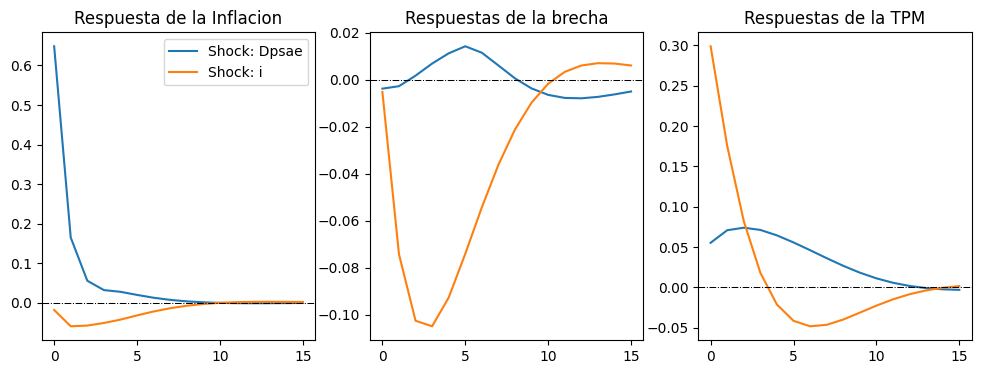

In [16]:
TP = 16   # Horizon to plot (<=Horizon)

shockslist = ['res_Dpsae','res_i']
varslist = ['Dp','y','i']

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[0]][:TP], linestyle='-',label="Shock: Dpsae")
axs[0].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[0]][:TP], linestyle='-',label="Shock: i")
axs[0].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[0].set_title("Respuesta de la Inflacion")
axs[0].legend(loc="best")

axs[1].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[1]][:TP], linestyle='-',label="Shock: Dpsae")
axs[1].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[1]][:TP], linestyle='-',label="Shock: i")
axs[1].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[1].set_title("Respuestas de la brecha")

axs[2].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[2]][:TP], linestyle='-',label="Shock: Dpsae")
axs[2].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[2]][:TP], linestyle='-',label="Shock: i")
axs[2].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[2].set_title("Respuestas de la TPM")

# Proyección

1. Se cargan los datos de variables observables. Estas se recaban de instituciones de estadísticas y se sintetizan para que sean insumidas por el modelo.

In [17]:
Describ, DBobs = HTS.ReadDB_excel(pathPolMon+'Tarea/DataTarea.xlsx', sheet='VarObs')

Para la presentación de resultados, recogemos las variables endógenas y exógenas del modelo

In [18]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

Visualización de las variables medibles

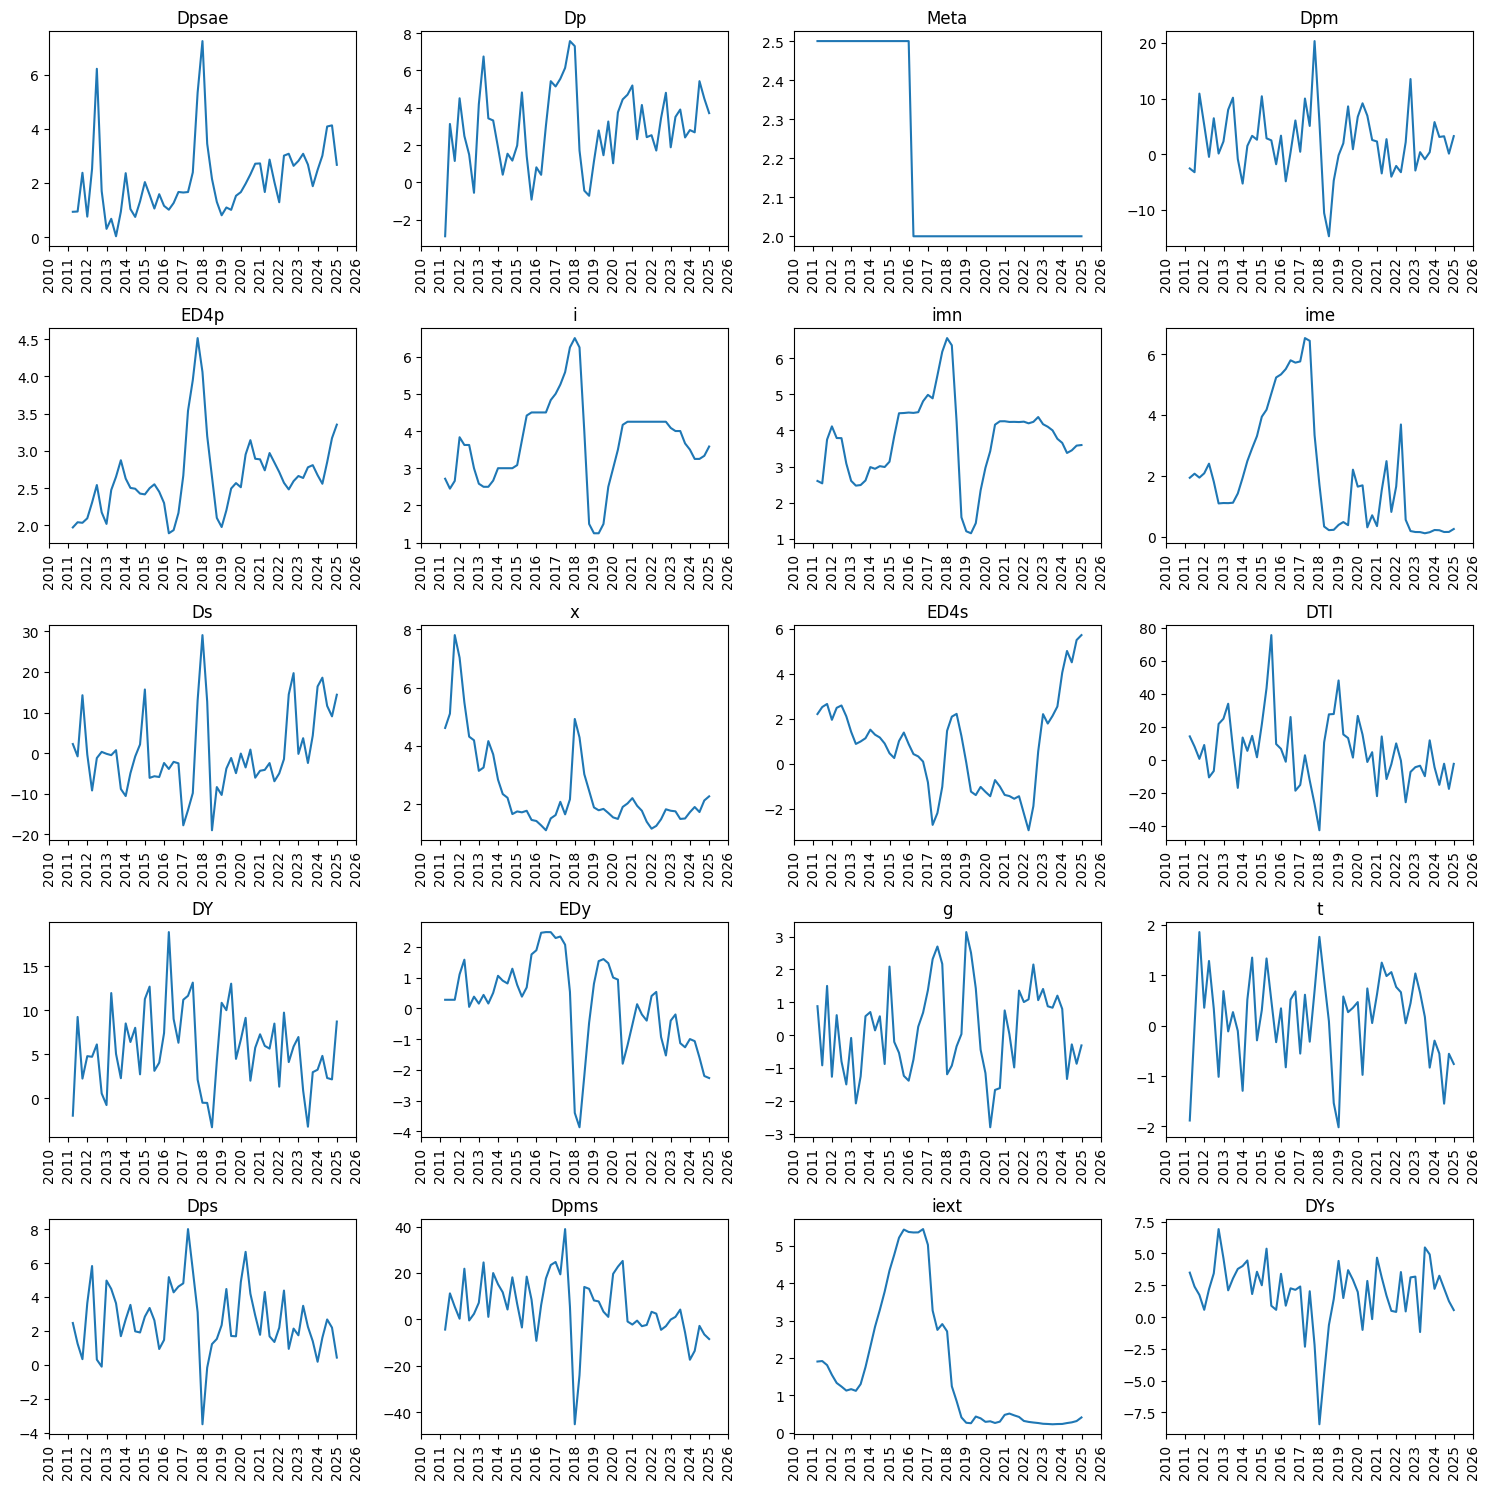

In [19]:
obsnames = DLM.sympy_to_list(Mod['StateSpaceForm']['obs_names'])
num_cols = len(obsnames)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(obsnames):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DBobs.index, DBobs[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

2. Con el filtro de Kalman se estiman las variables no observables, consistente con la estructura del MPT.

In [20]:
DF_s, DF_u, minuslogL = DLM.KFts(DBobs, Mod, {'diffuse':False})
# DF_s:  smoothed
# DF_u:  updated
Data = DF_s
Data.tail(4)

DY_eq    DYs_eq         Ds         y        ys      Dpae  \
2024-03-31  3.741512  1.572541  18.601325 -0.372058 -0.424948  2.275660   
2024-06-30  3.837340  1.481059  11.631337 -0.749937 -0.232537  7.078403   
2024-09-30  3.975434  1.436834   9.053224 -1.201698 -0.279071  4.939607   
2024-12-31  4.061683  1.428075  14.390420 -0.034537 -0.498415  4.993248   

                  Dp    Dp(-2)    Dp(-1)       D4p  ...    D4s(+1)         x  \
2024-03-31  2.680545  2.406473  2.801772  2.947635  ...   9.533080  1.904598   
2024-06-30  5.422641  2.801772  2.680545  3.327858  ...  11.216721  1.731182   
2024-09-30  4.489321  2.680545  5.422641  3.848570  ...   9.583825  2.129473   
2024-12-31  3.708887  5.422641  4.489321  4.075349  ...   8.370837  2.270804   

                   DQ     DQ_eq      D4ps  D4ps(+3)  D4ps(+2)  D4ps(+1)  \
2024-03-31  17.521715  6.313536  1.353402  1.695702  1.302945  1.217756   
2024-06-30   8.882800  6.785505  1.462109  2.010292  1.979153  1.586919   
2024-09-30   6.758780  6.780595  1.662531  1.838380  2.084314  2.059953   
2024-12-31  11.108833  7.575748  1.724304  1.262829  1.399839  1.670102   

                  Rs     Rs_eq  
2024-03-31 -1.474856 -0.528716  
2024-06-30 -1.492735 -0.604802  
2024-09-30 -1.398074 -0.616680  
2024-12-31 -1.161649 -0.536551  

[4 rows x 74 columns]

<Axes: >

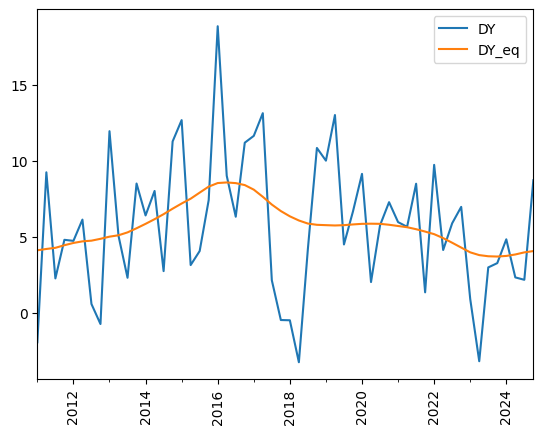

In [21]:
Data[['DY', 'DY_eq']].plot.line(rot = 90)

3. Ejemplos de proyección

**Proyección incondicional**

Se proyectarán 8 trimestres desde el último periodo de información 2024Q4.

La proyección es libre de condicionantes. En consecuencia, se observa la convergencia de la economía hacia su estado estacionario, tomando como punto de partida la situación inicial. Cabe destacar que ciertas variables presentan dependencia de múltiples rezagos.

In [22]:
FH = 8 # Horizonte de proyección (2 años)
StartingPeriod = '2025Q1'
FDB = DLM.DSGEforecast0(Mod,Data,FH,StartingPeriod)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


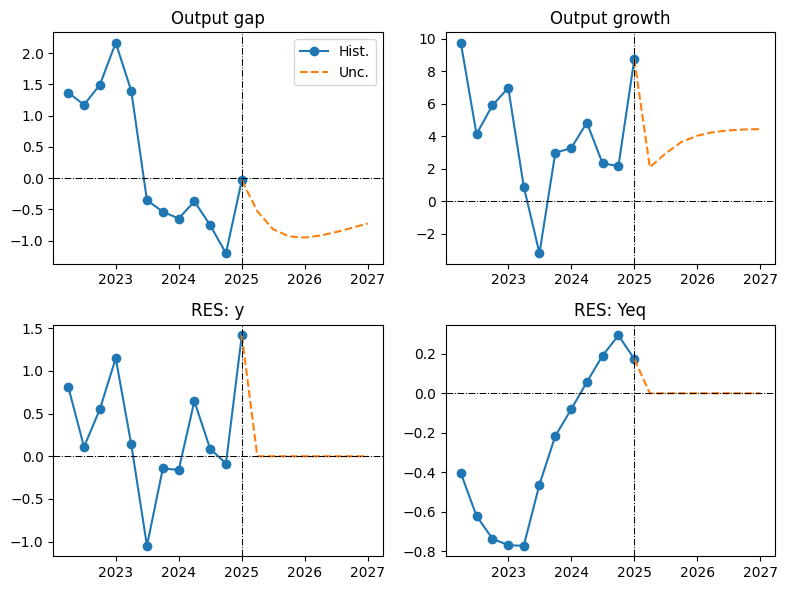

In [23]:
DBdict = {'Unc.': FDB}
lista = ['y','DY','res_y','res_DY_eq']
listanames = ['Output gap','Output growth','RES: y','RES: Yeq']
listaSS = [0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

**Proyección condicionada**

Es posible incorporar al modelo proyecciones externas para variables tanto observables como no observables, actuando como condicionantes. El Modelo de Proyección Trimestral (MPT) ajustará sus resultados en función de estas trayectorias predefinidas (hardtuning). Las variables restantes se adaptarán a la información ingresada, siguiendo las relaciones establecidas por las ecuaciones y los canales de transmisión del modelo. Los choques (residuos) funcionarán como mecanismos de ajuste, absorbiendo las discrepancias entre las variables proyectadas externamente y las explicadas por el modelo.

Por ejemplo, se podría introducir una proyección externa sobre la evolución de la tasa de interés de la Reserva Federal (FED), aunque esta no esté modelada explícitamente (la parte externa representa una simplificación). Esta información, basada en juicio experto o modelos satélite, se incorpora como un dato exógeno.

En la presente sesión, se analizará el impacto de un choque positivo en la demanda, que impulsará la brecha del producto. Adicionalmente, se observará una reacción más pronunciada de la inflación subyacente.

Para este ejercicio, se proponen dos escenarios de análisis:
- **Escenario 1**: Tasa de interés libre. Este escenario permite examinar el efecto conjunto del choque y la reacción del banco central, siguiendo la regla de Taylor. Proporciona una estimación del comportamiento probable del banco central.
- **Escenario 2**: Tasa de interés fija. Este escenario evalúa el impacto del choque, asumiendo que el banco central mantiene la tasa de interés en el nivel del escenario base, sin reaccionar.

# Escenario base

In [24]:
UCond_base = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

In [25]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_base['UShock'])
print('Unanticipated Hardtunning')
print(UCond_base['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_base['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
            res_Dps  res_ys
2025-03-31      NaN     NaN
2025-06-30      NaN     NaN
2025-09-30      NaN     NaN
2025-12-31      NaN     NaN
2026-03-31      NaN     NaN
2026-06-30      NaN     NaN
2026-09-30      NaN     NaN
2026-12-31      NaN     NaN
Unanticipated Hardtunning
                 DYs        ys      Dpae         t         g  DTI  Dps  \
2025-03-31  2.207918 -0.105134  2.987568 -0.298048 -0.126319  5.0  1.8   
2025-06-30  1.975786 -0.071549  1.998147 -0.116924 -0.050679  5.0  1.8   
2025-09-30  1.781167 -0.048265  2.000000 -0.045869 -0.020332  4.0  1.9   
2025-12-31  1.640418 -0.031798  2.000000 -0.017995 -0.008157  4.0  1.9   
2026-03-31  1.546577 -0.020405  2.000000 -0.007059 -0.003273  3.0  2.0   
2026-06-30  1.488975 -0.015011  2.000000 -0.002769 -0.001313  3.0  2.0   
2026-09-30  1.457705 -0.015015  2.000000 -0.001086 -0.000527  2.0  2.0   
2026-12-31  1.444628 -0.015854  2.000000 -0.000426 -0.000211  2.0  2.0   

  

In [26]:
UFDB_base = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_base)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


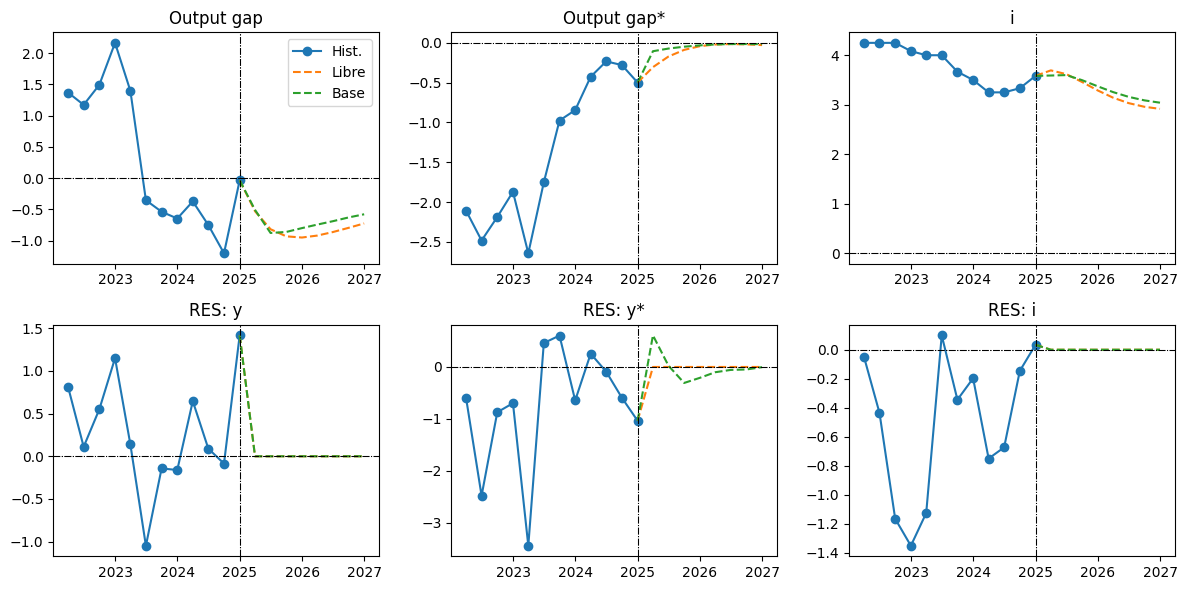

In [27]:
BDdict = {'Libre': FDB,'Base': UFDB_base}
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

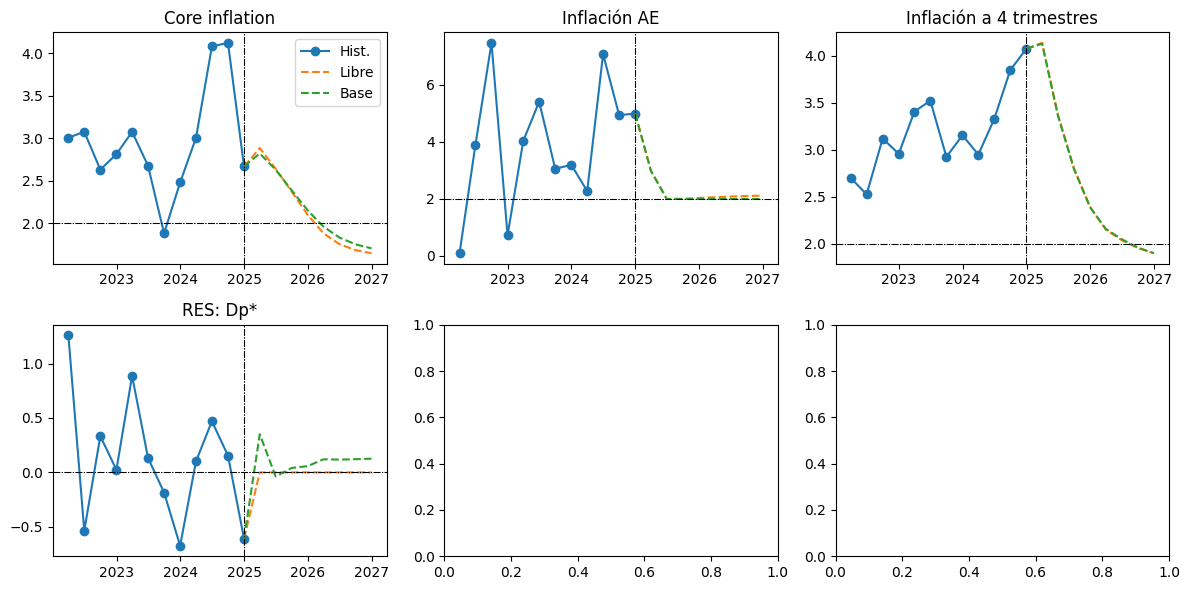

In [28]:
lista = ['Dpsae','Dpae','D4p','res_Dps']
listanames = ['Core inflation','Inflación AE','Inflación a 4 trimestres','RES: Dp*',]
listaSS = [2,2,2,0]
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

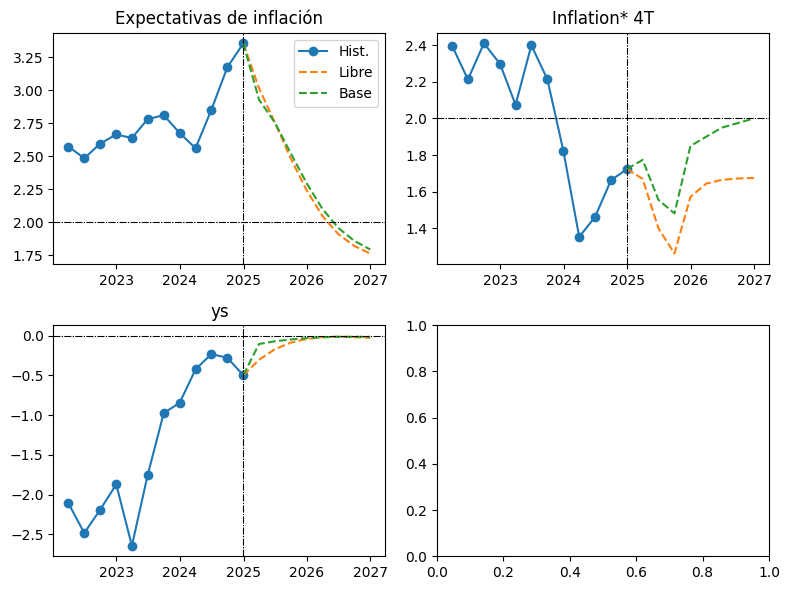

In [29]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['ED4p','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Expectativas de inflación','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,2,2)

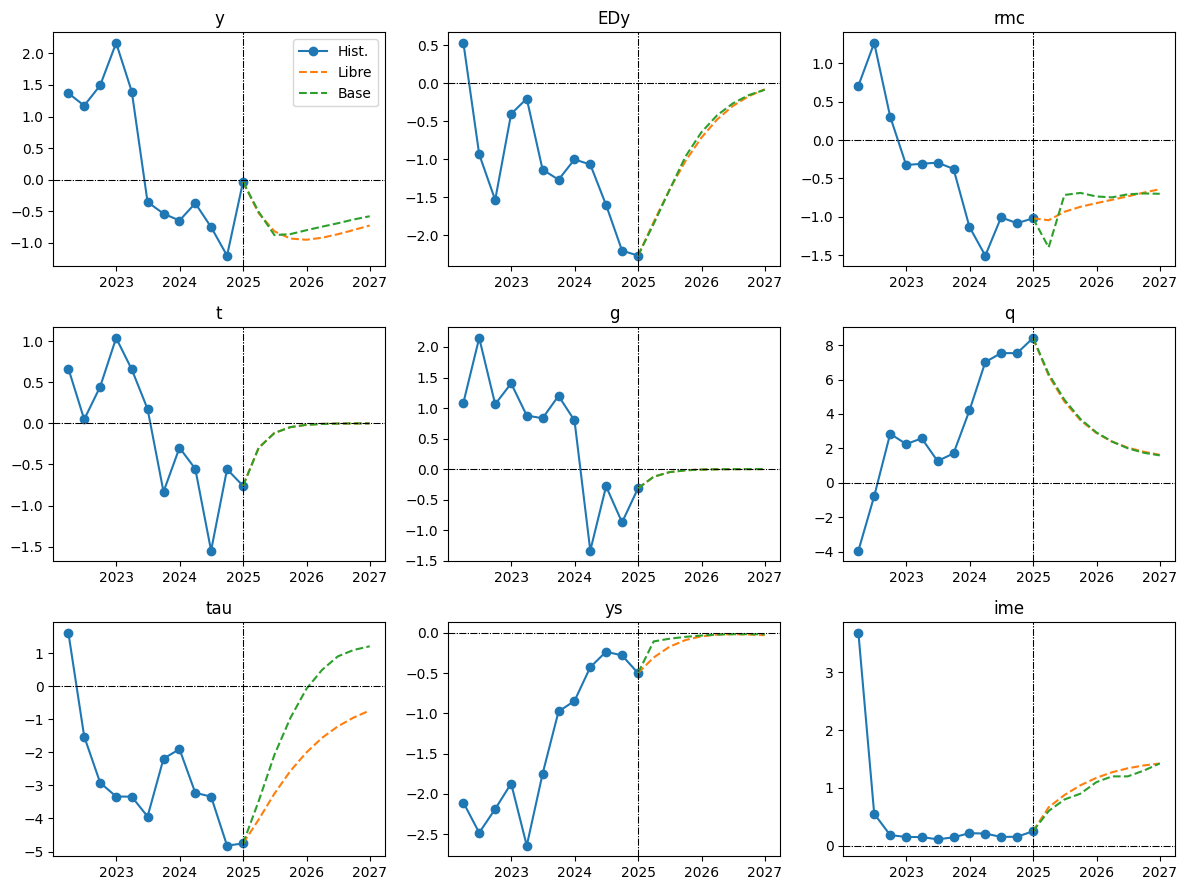

In [30]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','ime']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,3,3)

In [31]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_base['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_base['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_base['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_base['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_base['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_base['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_base['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_base['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.508073   -0.876774   -0.860930   -0.799386   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.338987   -0.584984   -0.574412   
Confianza: aEy*EDy         -0.236136   -0.179241   -0.123038   -0.082089   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.418751   -0.214443   -0.206460   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.146817    0.111967    0.086006    0.067917   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.743107   -0.689126   -0.629096   -0.578192  
Inercia: (ay+aEy)*y(-1)    -0.533350   -0.495801   -0.459785   -0.419733  
Confianza: aEy*EDy         -0.053683   -0.033533   -0.019553   -0.010642  
Cond. Mon.: armc*rmc(-1)   -0.220301   -0.223787   -0.211822   -0.208610  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.055686    0.046556    0.040537    0.037005  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [32]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_base['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_base['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_base['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_base['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_base['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.823119    2.631969   
Inflación importada a 4 trimestres: bm*D4pm        0.156397    0.131118   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667614   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.041340    1.920524   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.087287   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.388618    2.152955   
Inflación importada a 4 trimestres: bm*D4pm        0.159248    0.137323   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.622410    0.564862   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.757589    1.598677   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.150630   -0.147908   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.961106    1.833949   
Inflación importada a 4 trimestres: bm*D4pm        0.124584    0.133414   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.509133    0.463764   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.464724    1.364437   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.137335   -0.127666   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.753487    1.706313  
Inflación importada a 4 trimestres: bm*D4pm        0.141782    0.149405  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.433694    0.414666  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.296404    1.250320  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.118392   -0.108079  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [33]:
# Regla de política monetaria
# i = fi*i(-1) + (1 - fi)*( ieq + fp*D4pdev + fy*( cfy*y + (1 - cfy)*y(-1) ) ) + m_res_i*res_i;

fi = 0.700000000000000
fp = 1.500000000000000
fy = 0.500000000000000
cfy = 0.500000000000000
m_res_i = (0.104900000000000)**0.5

hist2show = 4

i = UFDB_base['i'].values[-(hist2show+FH):].reshape(-1,1)
il = fi*UFDB_base['i'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ieq = (1-fi)*UFDB_base['ieq'].values[-(hist2show+FH):].reshape(-1,1)
D4pdev = (1-fi)*fp*UFDB_base['D4pdev'].values[-(hist2show+FH):].reshape(-1,1)
y = (1-fi)*fy*cfy*UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl = (1-fi)*fy*(1-cfy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_i = m_res_i*UFDB_base['res_i'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,il,ieq,D4pdev,y,yl,res_i], columns=['TPM: i','Inercia de la TPM: fi*i(-1)','TPM externa: (1-fi)*ieq','Desvío de la inflación meta: (1-fi)*fp*D4pdev','Brecha producto: (1-fi)*fy*cfy*y','Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*y(-1)','Residuo: m_res_i*res_i'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
TPM: i                                                3.250000    3.250000   
Inercia de la TPM: fi*i(-1)                           2.450000    2.275000   
TPM externa: (1-fi)*ieq                               1.082594    1.084530   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.036974    0.192674   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027904   -0.056245   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.048443   -0.027904   
Residuo: m_res_i*res_i                               -0.243221   -0.218054   

                                                    2024-09-30  2024-12-31  \
TPM: i                                                3.333333    3.583333   
Inercia de la TPM: fi*i(-1)                           2.275000    2.333333   
TPM externa: (1-fi)*ieq                               1.095351    1.106369   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.156627    0.225253   
Brecha producto: (1-fi)*fy*cfy*y                     -0.090127   -0.002590   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.056245   -0.090127   
Residuo: m_res_i*res_i                               -0.047271    0.011096   

                                                    2025-03-31  2025-06-30  \
TPM: i                                                3.590239    3.598635   
Inercia de la TPM: fi*i(-1)                           2.508333    2.513167   
TPM externa: (1-fi)*ieq                               1.115685    1.120342   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.006916    0.068989   
Brecha producto: (1-fi)*fy*cfy*y                     -0.038106   -0.065758   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.002590   -0.038106   
Residuo: m_res_i*res_i                                0.000000    0.000000   

                                                    2025-09-30  2025-12-31  \
TPM: i                                                3.496318    3.371692   
Inercia de la TPM: fi*i(-1)                           2.519045    2.447423   
TPM externa: (1-fi)*ieq                               1.122671    1.123836   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.015070   -0.075043   
Brecha producto: (1-fi)*fy*cfy*y                     -0.064570   -0.059954   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.065758   -0.064570   
Residuo: m_res_i*res_i                                0.000000    0.000000   

                                                    2026-03-31  2026-06-30  \
TPM: i                                                3.255360    3.159327   
Inercia de la TPM: fi*i(-1)                           2.360184    2.278752   
TPM externa: (1-fi)*ieq                               1.124418    1.124709   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.113555   -0.136716   
Brecha producto: (1-fi)*fy*cfy*y                     -0.055733   -0.051684   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.059954   -0.055733   
Residuo: m_res_i*res_i                                0.000000    0.000000   

                                                    2026-09-30  2026-12-31  
TPM: i                                                3.088785    3.041262  
Inercia de la TPM: fi*i(-1)                           2.211529    2.162150  
TPM externa: (1-fi)*ieq                               1.124854    1.124927  
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.148731   -0.155268  
Brecha producto: (1-fi)*fy*cfy*y                     -0.047182   -0.043364  
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.051684   -0.047182  
Residuo: m_res_i*res_i                                0.000000    0.000000

In [34]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf    = rho_Ds*UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_base['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_base['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_base['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_base['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     7.440530    4.652535    3.621290   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.556282   -1.115605   
Expectativas de depreciación: rho_Ds*Ds     5.756168   -0.622513   -0.446242   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.026334   -5.038089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.824086   -0.298901    0.030417   
Expectativas de depreciación: rho_Ds*Ds    -0.329634   -0.119561    0.012167   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.894845   -4.720368   -4.557504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.140450    0.398975    0.664544  
Expectativas de depreciación: rho_Ds*Ds     0.056180    0.159590    0.265818  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.423058   -4.324299   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [35]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_base['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_base['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_base['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_base['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_base['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_base['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_base['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.590239    3.598635   
Crecimiento PBI real: DY             8.730329    2.179919    2.611523   
Brecha producto: y                  -0.034537   -0.508073   -0.876774   
Inflación SAE: Dpsae                 2.669623    2.823119    2.631969   
Inflación total: Dp                  3.708887    2.896670    2.348486   
Expectativa de inflación: ED4p       3.353472    2.928252    2.754944   
Tasa real en moneda nacional: Rmn    0.241861    0.661987    0.843691   
Depreciación nominal: Ds            14.390420   -1.556282   -1.115605   
Inflación AE: Dpae                   4.993248    2.987568    1.998147   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.496318    3.371692    3.255360   
Crecimiento PBI real: DY             4.161840    4.356652    4.347487   
Brecha producto: y                  -0.860930   -0.799386   -0.743107   
Inflación SAE: Dpsae                 2.388618    2.152955    1.961106   
Inflación total: Dp                  2.214805    2.084544    1.978502   
Expectativa de inflación: ED4p       2.521218    2.293262    2.101109   
Tasa real en moneda nacional: Rmn    0.975100    1.078430    1.154250   
Depreciación nominal: Ds            -0.824086   -0.298901    0.030417   
Inflación AE: Dpae                   2.000000    2.000000    2.000000   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.159327    3.088785    3.041262  
Crecimiento PBI real: DY             4.350073    4.385930    4.360966  
Brecha producto: y                  -0.689126   -0.629096   -0.578192  
Inflación SAE: Dpsae                 1.833949    1.753487    1.706313  
Inflación total: Dp                  1.908217    1.863743    1.837667  
Expectativa de inflación: ED4p       1.957251    1.859659    1.793553  
Tasa real en moneda nacional: Rmn    1.202076    1.229127    1.247709  
Depreciación nominal: Ds             0.140450    0.398975    0.664544  
Inflación AE: Dpae                   2.000000    2.000000    2.000000

# Escenario Base: Más hawkish


In [36]:
UCond_basehawk = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_basehawk['Uvar']['var']['i'] = UFDB_base.i+0.25
    UCond_basehawk['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_basehawk['UShock'] or UCond_basehawk['UShock'][var_soft_tune].isna().all():
                UCond_basehawk['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [37]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_basehawk['UShock'])
print('Unanticipated Hardtunning')
print(UCond_basehawk['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_basehawk['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0  1.220025e-16   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  9.150190e-17   
2025-09-30      0.0       0.0  

In [38]:
UFDB_basehawk = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_basehawk)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [39]:
print(f'Impacto 2025: {round((UFDB_basehawk.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_basehawk.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: -0.0
Impacto 2026: -0.0


<ipython-input-39-3c145b7ac772>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_basehawk.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-39-3c145b7ac772>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_basehawk.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


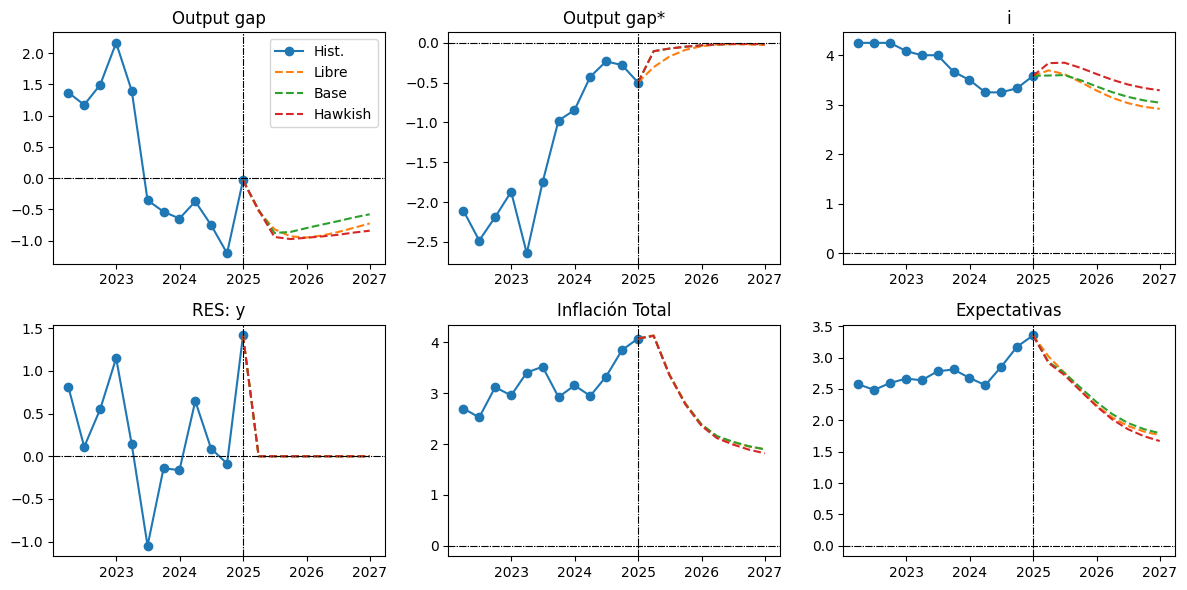

In [40]:
BDdicthawk = {'Libre': FDB,'Base': UFDB_base, 'Hawkish': UFDB_basehawk}
lista = ['y','ys', 'i','res_y','D4p', 'ED4p']
listanames = ['Output gap','Output gap*', 'i','RES: y','Inflación Total', 'Expectativas']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

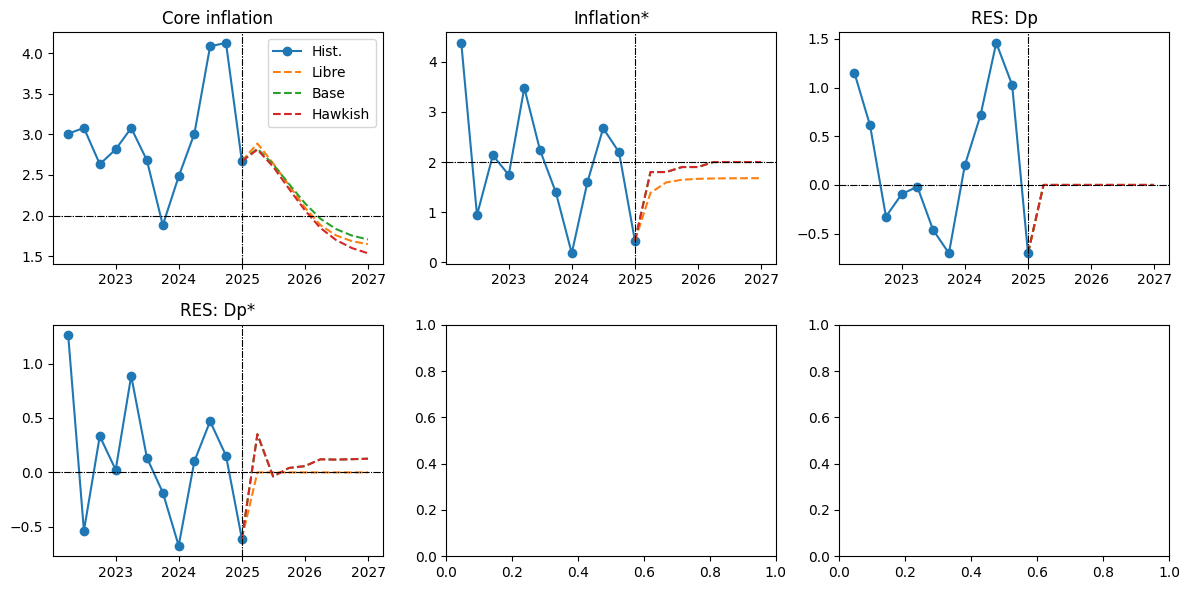

In [41]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

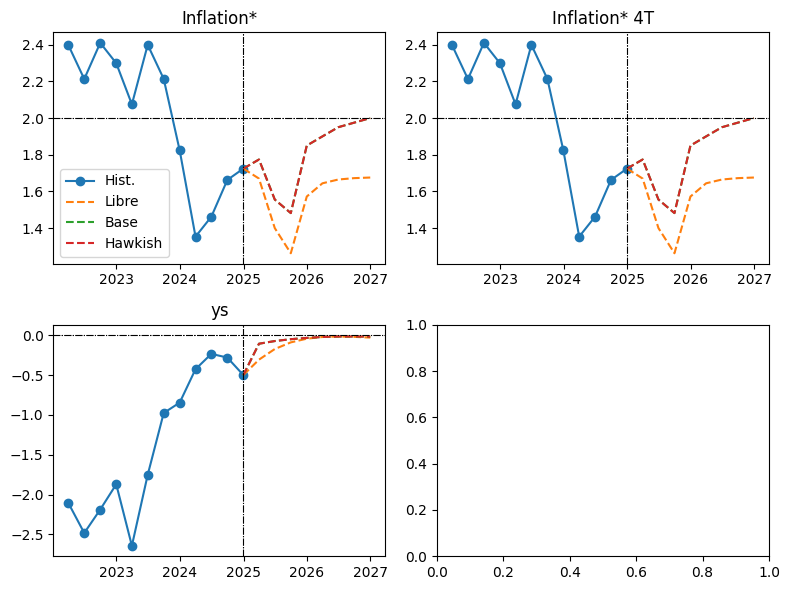

In [42]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,2,2)

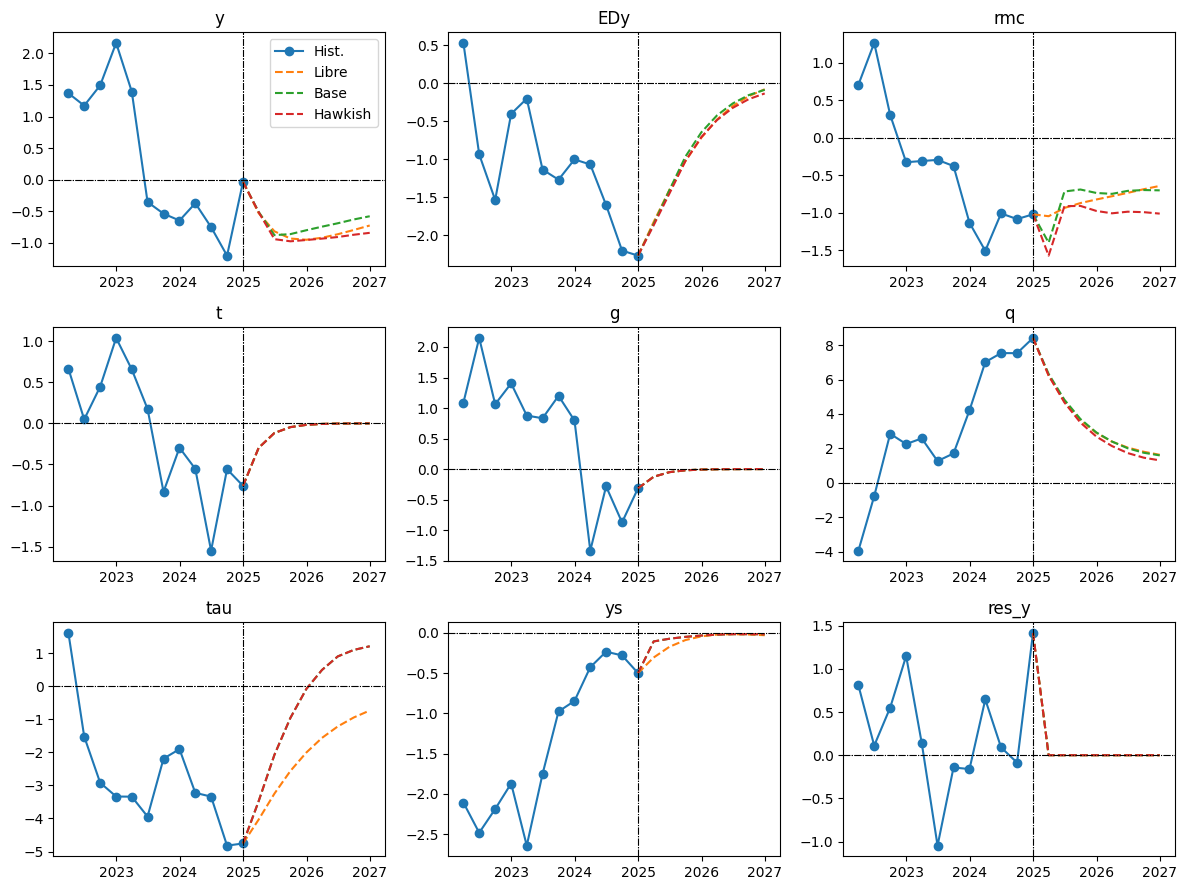

In [43]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,3,3)

In [44]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_basehawk['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_basehawk['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_basehawk['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_basehawk['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_basehawk['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_basehawk['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_basehawk['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_basehawk['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_basehawk['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_basehawk['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_basehawk.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.512527   -0.940938   -0.974607   -0.954169   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.341958   -0.627794   -0.650258   
Confianza: aEy*EDy         -0.238502   -0.184971   -0.130412   -0.090027   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.470551   -0.273135   -0.271863   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.144729    0.108305    0.081205    0.062321   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.932129   -0.906831   -0.871020   -0.840732  
Inercia: (ay+aEy)*y(-1)    -0.636622   -0.621917   -0.605038   -0.581144  
Confianza: aEy*EDy         -0.061537   -0.040942   -0.026336   -0.016731  
Cond. Mon.: armc*rmc(-1)   -0.292072   -0.301512   -0.295071   -0.296938  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.049561    0.040100    0.033899    0.030294  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [45]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_base['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_base['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_base['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_base['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_base['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_basehawk.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.823119    2.631969   
Inflación importada a 4 trimestres: bm*D4pm        0.156397    0.131118   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667614   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.041340    1.920524   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.087287   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.388618    2.152955   
Inflación importada a 4 trimestres: bm*D4pm        0.159248    0.137323   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.622410    0.564862   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.757589    1.598677   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.150630   -0.147908   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.961106    1.833949   
Inflación importada a 4 trimestres: bm*D4pm        0.124584    0.133414   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.509133    0.463764   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.464724    1.364437   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.137335   -0.127666   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.753487    1.706313  
Inflación importada a 4 trimestres: bm*D4pm        0.141782    0.149405  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.433694    0.414666  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.296404    1.250320  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.118392   -0.108079  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [46]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsl     = rho_Ds*UFDB_base['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_base['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_base['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_base['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_base['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsl,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_basehawk.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.556282   -1.115605   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.622513   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.026334   -5.038089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.824086   -0.298901    0.030417   
Expectativas de depreciación: rho_Ds*Ds    -0.446242   -0.329634   -0.119561   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.894845   -4.720368   -4.557504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.140450    0.398975    0.664544  
Expectativas de depreciación: rho_Ds*Ds     0.012167    0.056180    0.159590  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.423058   -4.324299   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

# Escenario Base: Más dovish [MANTENER 1 Y EMPEZAR A BAJAR] (FINAL)


In [47]:
UCond_basedove = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_basedove['Uvar']['var']['i'] = pd.Series(
    np.append(UFDB_base.i.iloc[-(FH):].values[1:], UFDB_base.i.iloc[-1]),
    index=UFDB_base.i.index[-FH:]  # Mantiene la coherencia del índice
)
    UCond_basedove['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_basedove['UShock'] or UCond_basedove['UShock'][var_soft_tune].isna().all():
                UCond_basedove['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [48]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_basedove['UShock'])
print('Unanticipated Hardtunning')
print(UCond_basedove['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_basedove['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0  1.220025e-16   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  9.150190e-17   
2025-09-30      0.0       0.0  

In [49]:
UFDB_basedove = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_basedove)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [50]:
print(f'Impacto 2025: {round((UFDB_basedove.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_basedove.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: 0.0
Impacto 2026: 0.0


<ipython-input-50-ca3f2251f70b>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_basedove.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-50-ca3f2251f70b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_basedove.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


### Proyecciones (Todas)
En las proyecciones, además del softuning de algunas variables, se apagan los residuos de varias otras. Para algunos de estos residuos, su desviación estándar asociada es alta, por lo que apagar estos shocks influye bastante en sus respectivas variables. Ploteamos todos los residuos para identificar cuáles experimentan un mayor cambio en el horizonte de proyección.

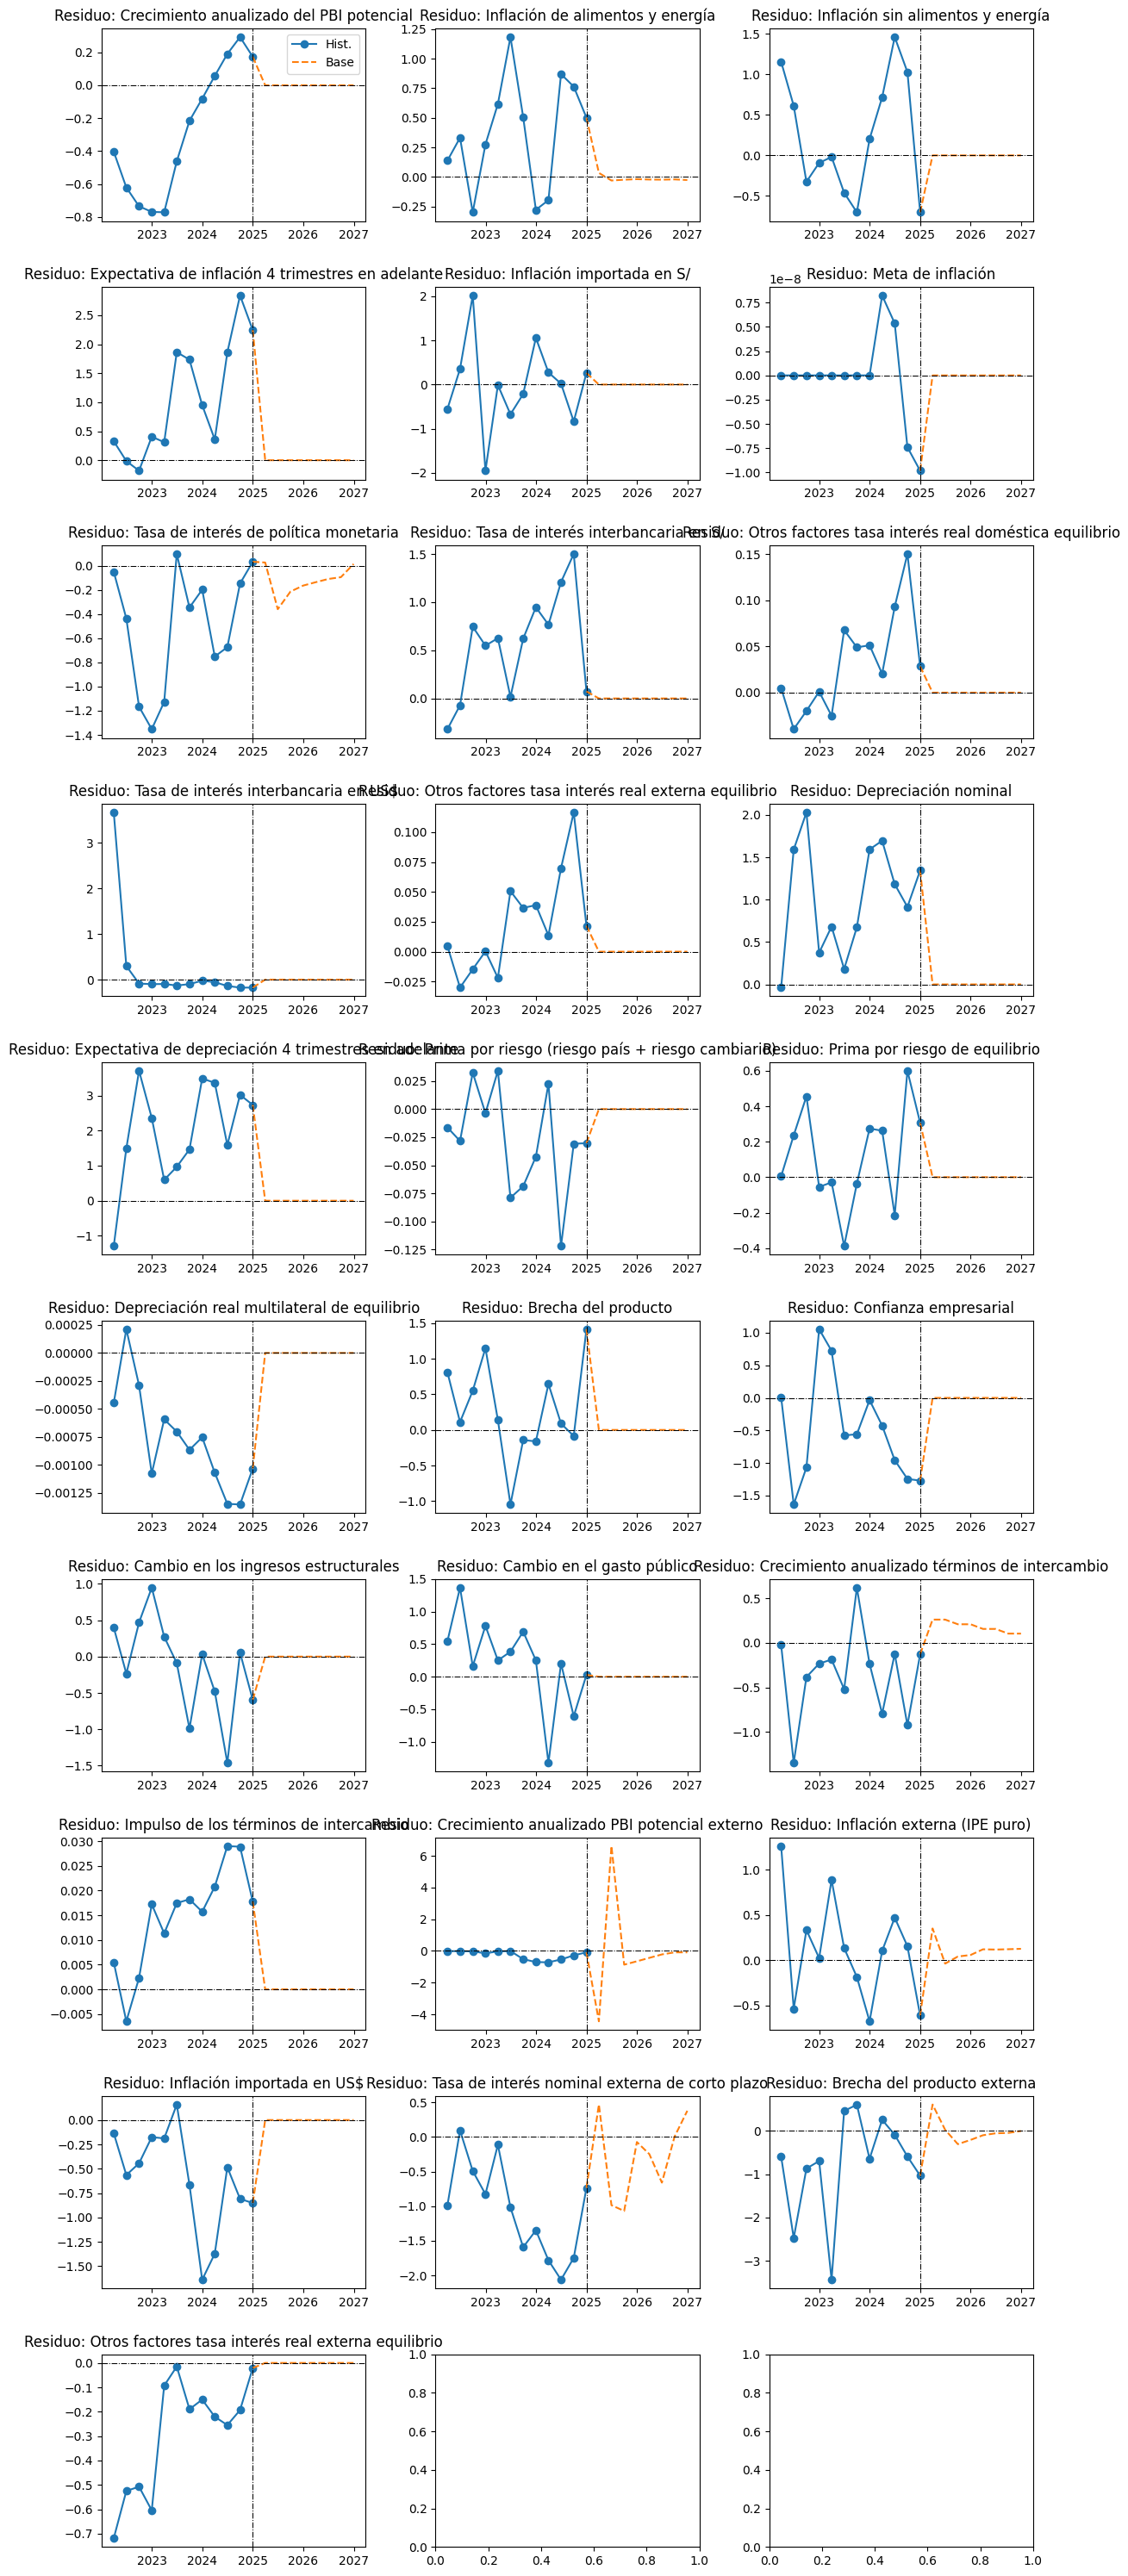

In [51]:
BDdictdove = {'Base': UFDB_basedove}

# Proyecciones relevantes (residuos)
lista_residuos = [
    'res_DY_eq', 'res_Dpae', 'res_Dpsae', 'res_ED4p', 'res_Dpm', 'res_Meta',
    'res_i', 'res_imn', 'res_zmn', 'res_ime', 'res_zme', 'res_Ds', 'res_ED4s',
    'res_x', 'res_x_eq', 'res_DQ_eq', 'res_y', 'res_EDy', 'res_t', 'res_g',
    'res_DTI', 'res_tau', 'res_DYs_eq', 'res_Dps', 'res_Dpms', 'res_iext',
    'res_ys', 'res_z'
]

# Nombres de los residuos (agregando "Residuo de" al inicio)
listanames_residuos = [
    'Residuo: Crecimiento anualizado del PBI potencial',
    'Residuo: Inflación de alimentos y energía',
    'Residuo: Inflación sin alimentos y energía',
    'Residuo: Expectativa de inflación 4 trimestres en adelante',
    'Residuo: Inflación importada en S/',
    'Residuo: Meta de inflación',
    'Residuo: Tasa de interés de política monetaria',
    'Residuo: Tasa de interés interbancaria en S/',
    'Residuo: Otros factores tasa interés real doméstica equilibrio',
    'Residuo: Tasa de interés interbancaria en US$',
    'Residuo: Otros factores tasa interés real externa equilibrio',
    'Residuo: Depreciación nominal',
    'Residuo: Expectativa de depreciación 4 trimestres en adelante',
    'Residuo: Prima por riesgo (riesgo país + riesgo cambiario)',
    'Residuo: Prima por riesgo de equilibrio',
    'Residuo: Depreciación real multilateral de equilibrio',
    'Residuo: Brecha del producto',
    'Residuo: Confianza empresarial',
    'Residuo: Cambio en los ingresos estructurales',
    'Residuo: Cambio en el gasto público',
    'Residuo: Crecimiento anualizado términos de intercambio',
    'Residuo: Impulso de los términos de intercambio',
    'Residuo: Crecimiento anualizado PBI potencial externo',
    'Residuo: Inflación externa (IPE puro)',
    'Residuo: Inflación importada en US$',
    'Residuo: Tasa de interés nominal externa de corto plazo',
    'Residuo: Brecha del producto externa',
    'Residuo: Otros factores tasa interés real externa equilibrio'
]

# Para residuos, el estado estacionario debería ser 0 (pues son desviaciones)
listaSS_residuos = [0.0] * len(lista_residuos)

HH = 12
fig, axs = HTS.plotTSforecast(BDdictdove, lista_residuos, listanames_residuos, listaSS_residuos, FH, HH, 10, 3)

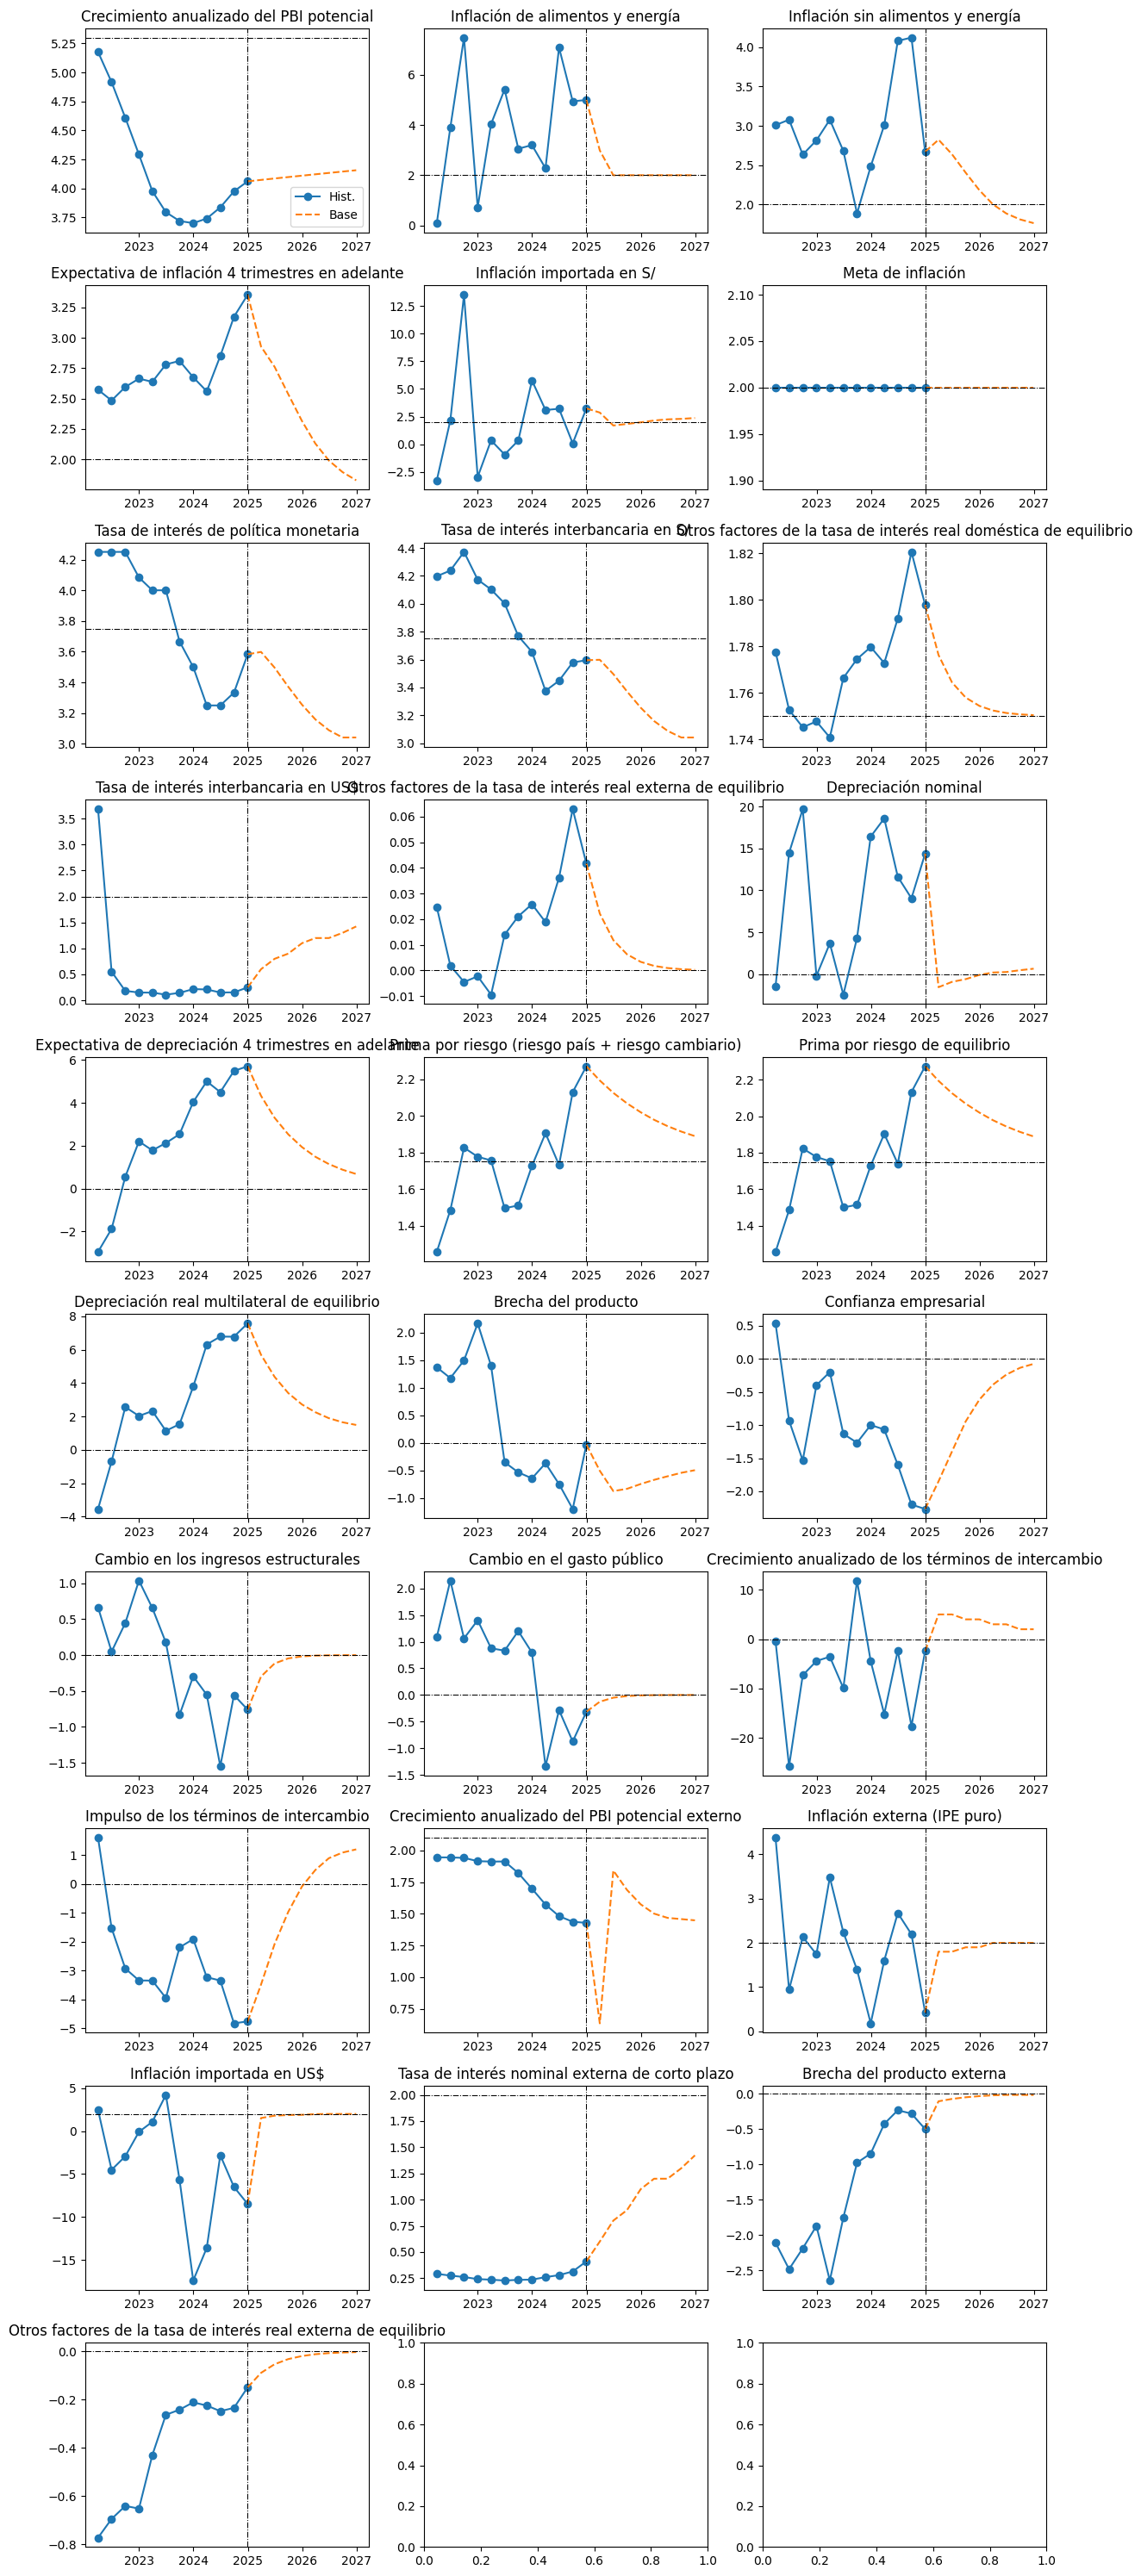

In [52]:
BDdictdove = {'Base': UFDB_basedove}

# Proyecciones relevantes
lista = [
    'DY_eq', 'Dpae', 'Dpsae', 'ED4p', 'Dpm', 'Meta', 'i', 'imn', 'zmn',
    'ime', 'zme', 'Ds', 'ED4s', 'x', 'x_eq', 'DQ_eq', 'y', 'EDy', 't',
    'g', 'DTI', 'tau', 'DYs_eq', 'Dps', 'Dpms', 'iext', 'ys', 'z'
]

listanames = [
    'Crecimiento anualizado del PBI potencial',               # DY_eq
    'Inflación de alimentos y energía',                       # Dpae
    'Inflación sin alimentos y energía',                      # Dpsae
    'Expectativa de inflación 4 trimestres en adelante',      # ED4p
    'Inflación importada en S/',                              # Dpm
    'Meta de inflación',                                      # Meta
    'Tasa de interés de política monetaria',                  # i
    'Tasa de interés interbancaria en S/',                    # imn
    'Otros factores de la tasa de interés real doméstica de equilibrio',  # zmn
    'Tasa de interés interbancaria en US$',                   # ime
    'Otros factores de la tasa de interés real externa de equilibrio',    # zme
    'Depreciación nominal',                                   # Ds
    'Expectativa de depreciación 4 trimestres en adelante',   # ED4s
    'Prima por riesgo (riesgo país + riesgo cambiario)',      # x
    'Prima por riesgo de equilibrio',                         # x_eq
    'Depreciación real multilateral de equilibrio',           # DQ_eq
    'Brecha del producto',                                    # y
    'Confianza empresarial',                                  # EDy
    'Cambio en los ingresos estructurales',                   # t
    'Cambio en el gasto público',                             # g
    'Crecimiento anualizado de los términos de intercambio',  # DTI
    'Impulso de los términos de intercambio',                 # tau
    'Crecimiento anualizado del PBI potencial externo',       # DYs_eq
    'Inflación externa (IPE puro)',                           # Dps
    'Inflación importada en US$',                             # Dpms
    'Tasa de interés nominal externa de corto plazo',         # is
    'Brecha del producto externa',                            # ys
    'Otros factores de la tasa de interés real externa de equilibrio',  # z
]

listaSS = [
    5.30,   # DY_eq
    2.00,   # Dpae
    2.00,   # Dpsae
    2.00,   # ED4p
    2.00,   # Dpm
    2.00,   # Meta
    3.75,   # i (Rmn_ss + Dp_ss = 1.75 + 2.00)
    3.75,   # imm (igual a i_ss)
    1.75,   # zmn (igual a Rmn_ss)
    2.00,   # ime (iext_ss = Rme_ss + Dps_ss = 0.00 + 2.00)
    0.00,   # zme (igual a Rme_ss)
    0.00,   # Ds
    0.00,   # ED4s
    1.75,   # x (Rmn_ss - Rme_ss = 1.75 - 0.00)
    1.75,   # x_eq (igual a x_ss)
    0.00,   # DQ_eq
    0.00,   # y
    0.00,   # Eby
    0.00,   # t
    0.00,   # g
    0.00,   # DTI
    0.00,   # tau
    2.10,   # DYs_eq
    2.00,   # Dps
    2.00,   # Dpms
    2.00,   # is (iext_ss)
    0.00,   # ys
    0.00    # z (igual a Rs_ss)
]
HH = 12
fig, axs = HTS.plotTSforecast(BDdictdove,lista,listanames,listaSS,FH,HH,10,3)

### Proyecciones (Cambios relevantes)
Encontramos 8 variables que podrían estar cambiando significativamente al apagar el shock. Revisamos qué tan altas son sus desviaciones estándar (coeficientes asociados en las ecuaciones) para determinar si su imapacto es alto.

**m_res_Dpae = (15.961900000000000)^0.5**

m_res_ED4p = (0.026500000000000)^0.5

**m_res_Ds = (77.208300000000000)^0.5**

m_res_ED4s = (0.702900000000000)^0.5

**m_res_y = (0.900300000000000)^0.5**

m_res_EDy = (0.527000000000000)^0.5

m_res_DYs_eq = (0.032466666666667)^0.5

m_res_ys = (0.097400000000000)^0.5

El impacto sobre la Inflación de Alimentos y Energía, la Depreciación Nominal y la Brecha Producto parece ser relevante. Pasamos a observar esas 3 en particular.

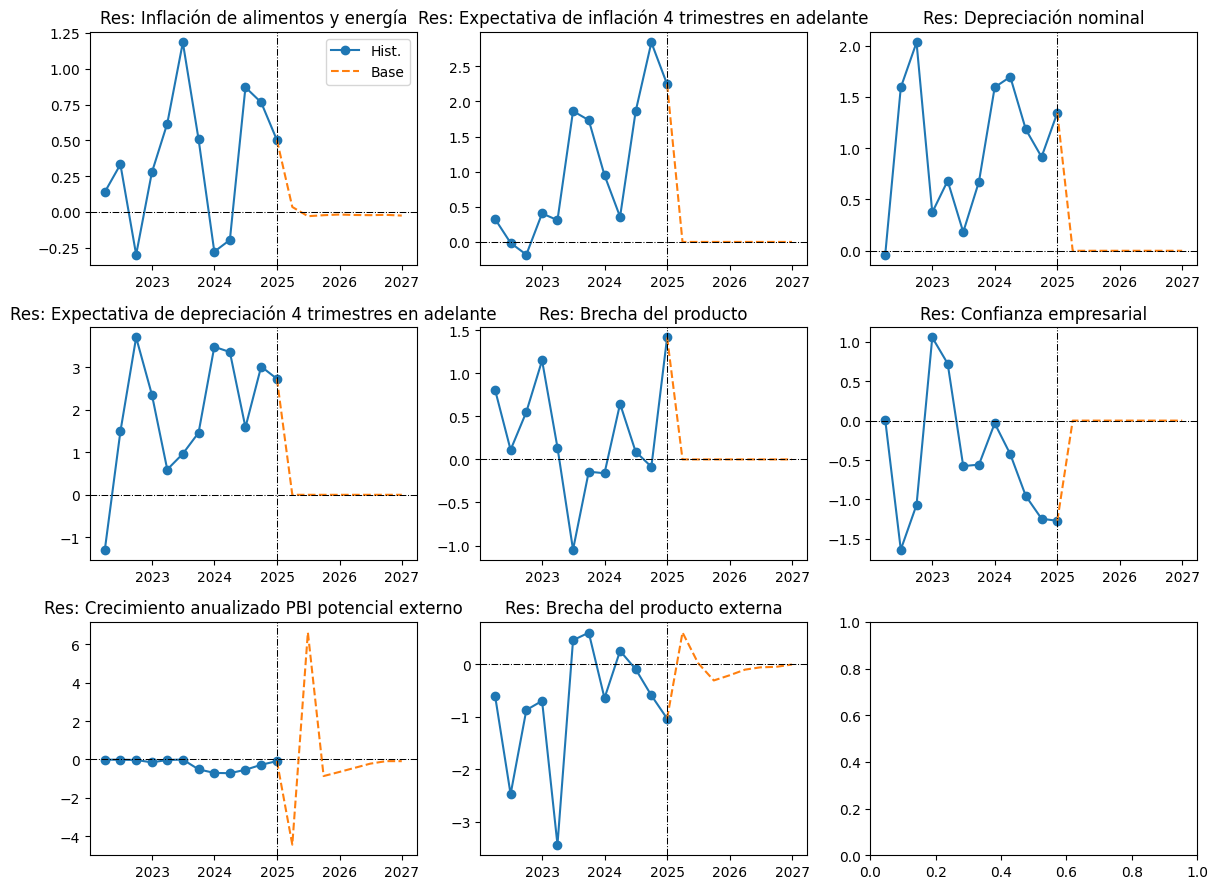

In [53]:
BDdictdove = {'Base': UFDB_basedove}

# Proyecciones relevantes (residuos filtrados)
lista_residuos = [
    'res_Dpae', 'res_ED4p', 'res_Ds', 'res_ED4s',
    'res_y', 'res_EDy', 'res_DYs_eq', 'res_ys'
]

# Nombres de los residuos filtrados
listanames_residuos = [
    'Res: Inflación de alimentos y energía',
    'Res: Expectativa de inflación 4 trimestres en adelante',
    'Res: Depreciación nominal',
    'Res: Expectativa de depreciación 4 trimestres en adelante',
    'Res: Brecha del producto',
    'Res: Confianza empresarial',
    'Res: Crecimiento anualizado PBI potencial externo',
    'Res: Brecha del producto externa'
]

# Valores SS para residuos (todos 0)
listaSS_residuos = [0.0] * len(lista_residuos)

HH = 12
fig, axs = HTS.plotTSforecast(BDdictdove, lista_residuos, listanames_residuos, listaSS_residuos, FH, HH, 3, 3)

### Proyecciones (Conclusión)
El impacto de las proyecciones (apagar los shocks) sobre la Inflación Alimentos y Energía, Depreciación nominal y Brecha producto es sustancial, por lo que debemos incluirlos en la narrativa de nuestra decisión de política en el escenario base.

### **LA HISTORIA**

**Proyecciones**

Si bien logramos terminar el **2024 con una brecha producto cerrada**, esto se puede explicar por factores estacionales (*Floro para no decir que simplemente su residuo cayó*) que impulsaron la demanda agregada. Se proyecta que, tras haberse disipado este shock transitorio, se volverá a tener **una brecha negativa**.

Los expertos esperan un contexto externo favorable en los próximos trimestres, asociado a **mejores términos de intercambio** y un **menor riesgo país**. En ese sentido, se espera una **fuerte apreciación de nuestra moneda**.

El contexto externo favorece una **menor inflación importada en soles** gracias a la apreciación nominal. Esto, sumado a indicios de una oferta local más resiliente *(No se refiere a brecha, es floro para no decir que simplemente el residuo de la non core cayó)*, sugieren una **menor Inflación de Alimentos y Energía** en los próximos trimestres.

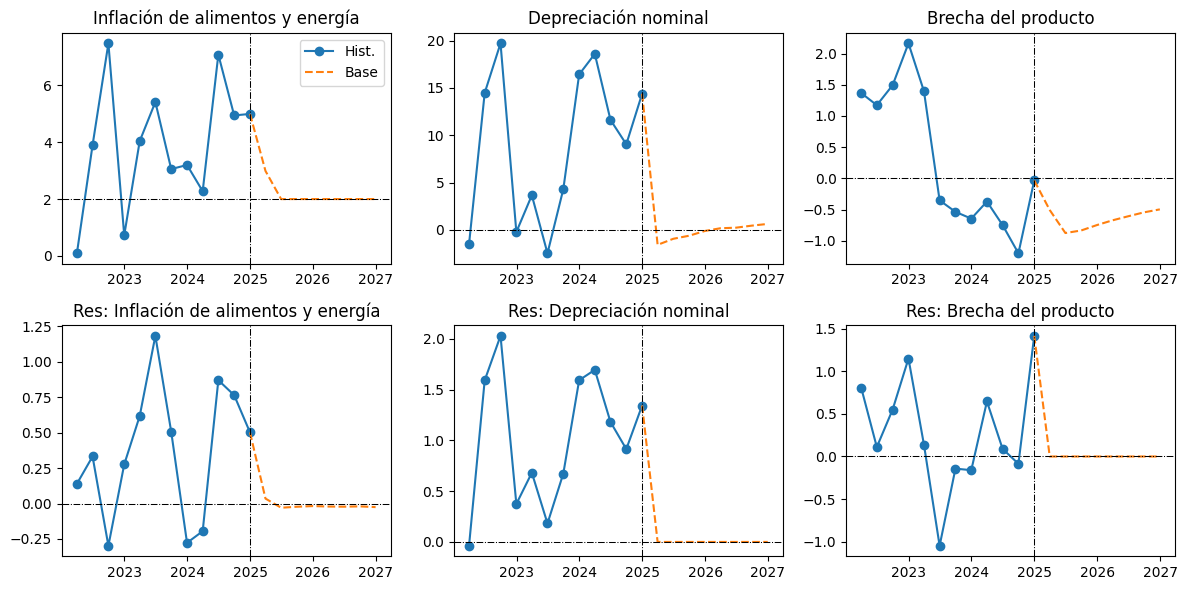

In [54]:
# Proyecciones relevantes (final)
lista = ['Dpae', 'Ds', 'y','res_Dpae', 'res_Ds', 'res_y']
listanames = [
    'Inflación de alimentos y energía',
    'Depreciación nominal',
    'Brecha del producto',
    'Res: Inflación de alimentos y energía',
    'Res: Depreciación nominal',
    'Res: Brecha del producto',
]
listaSS = [2.00, 0.00, 0.00,0,0,0]
HH = 12
fig, axs = HTS.plotTSforecast(BDdictdove, lista, listanames, listaSS, FH, HH, 2, 3)

### Canal de expectativas
La **menor Inflación de Alimentos y Energía** y, por ende, **menor Inflación Total** contribuye con **menores Expectativas de inflación**, las cuales se esperan que retornen al rango y logren **regresar a la meta** a mediados de 2026. La caída en las expectativas es a su vez el principal driver para la **caída en la inflación subyacente**.

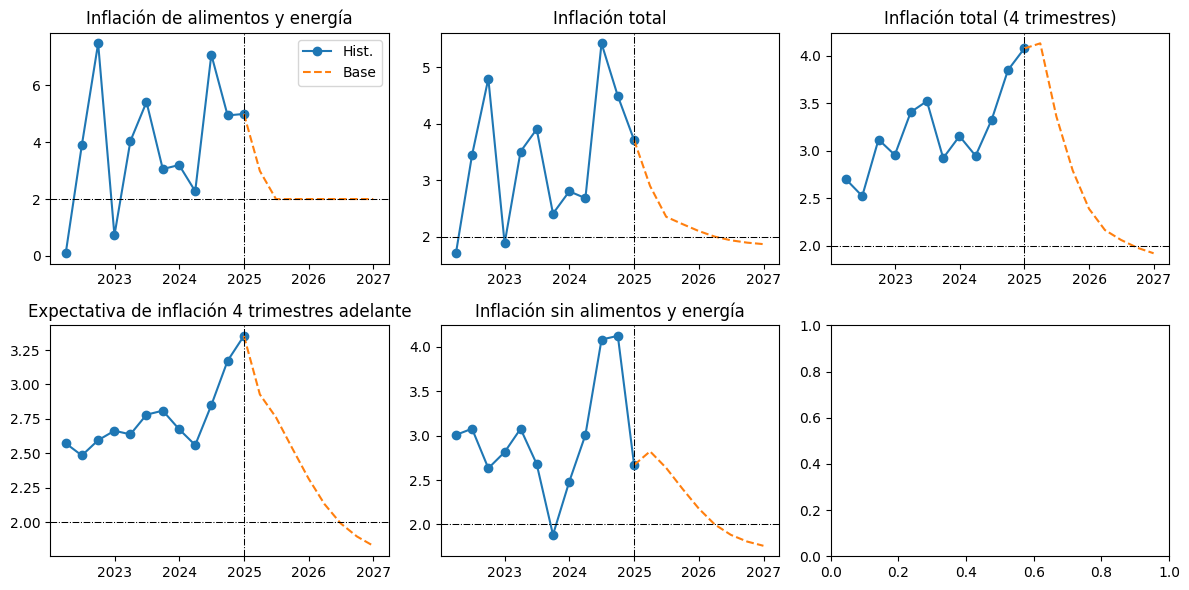

In [55]:
variables_inflacion = ['Dpae', 'Dp', 'D4p', 'ED4p', 'Dpsae']

nombres_inflacion = [
    'Inflación de alimentos y energía',
    'Inflación total',
    'Inflación total (4 trimestres)',
    'Expectativa de inflación 4 trimestres adelante',
    'Inflación sin alimentos y energía'
]

ss_inflacion = [2.00, 2.00, 2.00, 2.00, 2.00]

# Configuración del gráfico
HH = 12  # Horizonte de pronóstico

# Crear el gráfico
fig, axs = HTS.plotTSforecast(BDdictdove,variables_inflacion, nombres_inflacion, ss_inflacion, FH, HH, 2, 3)

### Canal de tipo de cambio
Como se mencionó antes, la apreciación nominal **reduce la Inflación importada en moneda nacional**, lo cual contribuye aún más con la **caída en la Inflación de Alimentos y Energía**.

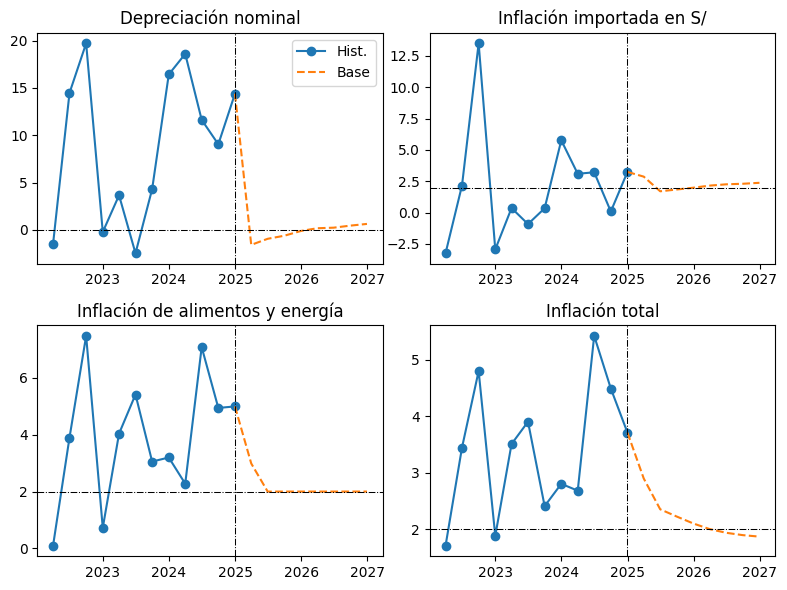

In [56]:
variables = ['Ds', 'Dpm', 'Dpae', 'Dp']

nombres = [
    'Depreciación nominal',
    'Inflación importada en S/',
    'Inflación de alimentos y energía',
    'Inflación total'
]

ss_values = [0.00, 2.00, 2.00, 2.00]

# Configuración del gráfico
HH = 12  # Horizonte de pronóstico

# Crear el gráfico
fig, axs = HTS.plotTSforecast(
    BDdictdove,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    2,
    2
)

### Canal de tasas de interés
Se espera que la **caída en expectaticas de inflación** resulte en un **incremento de la tasa interés real doméstica**, así como su brecha, de forma inmediata.

Respecto de la tasa real en ME, se esperan **mayores apreciaciones de nuestra moneda en el futuro**, en tal grado que este efecto predomina por sobre los **incrementos en la tasa de la FED** y la **caída en expectativas de inflación**. Así, se espera que la brecha de la tasa real externa caiga, pero para el próximo trimestre.
(*No cae inmediatamente porque hay un shock negativo al PBI potencial externo que baja la tasa externa natural, pero este shock se revierte para el siguiente periodo. Es bien raro, pasa de -4% a +6% de un periodo a otro. No sé si mencionarlo.*)

Tenemos que, en un principio, empeoran las condiciones monetarias, pero se logran recuperar rápidamente gracias a la caída en la brecha de la tasa real externa. Este es uno de los principales mecanismos que explican la caída y posterior recuperación de la brecha producto.

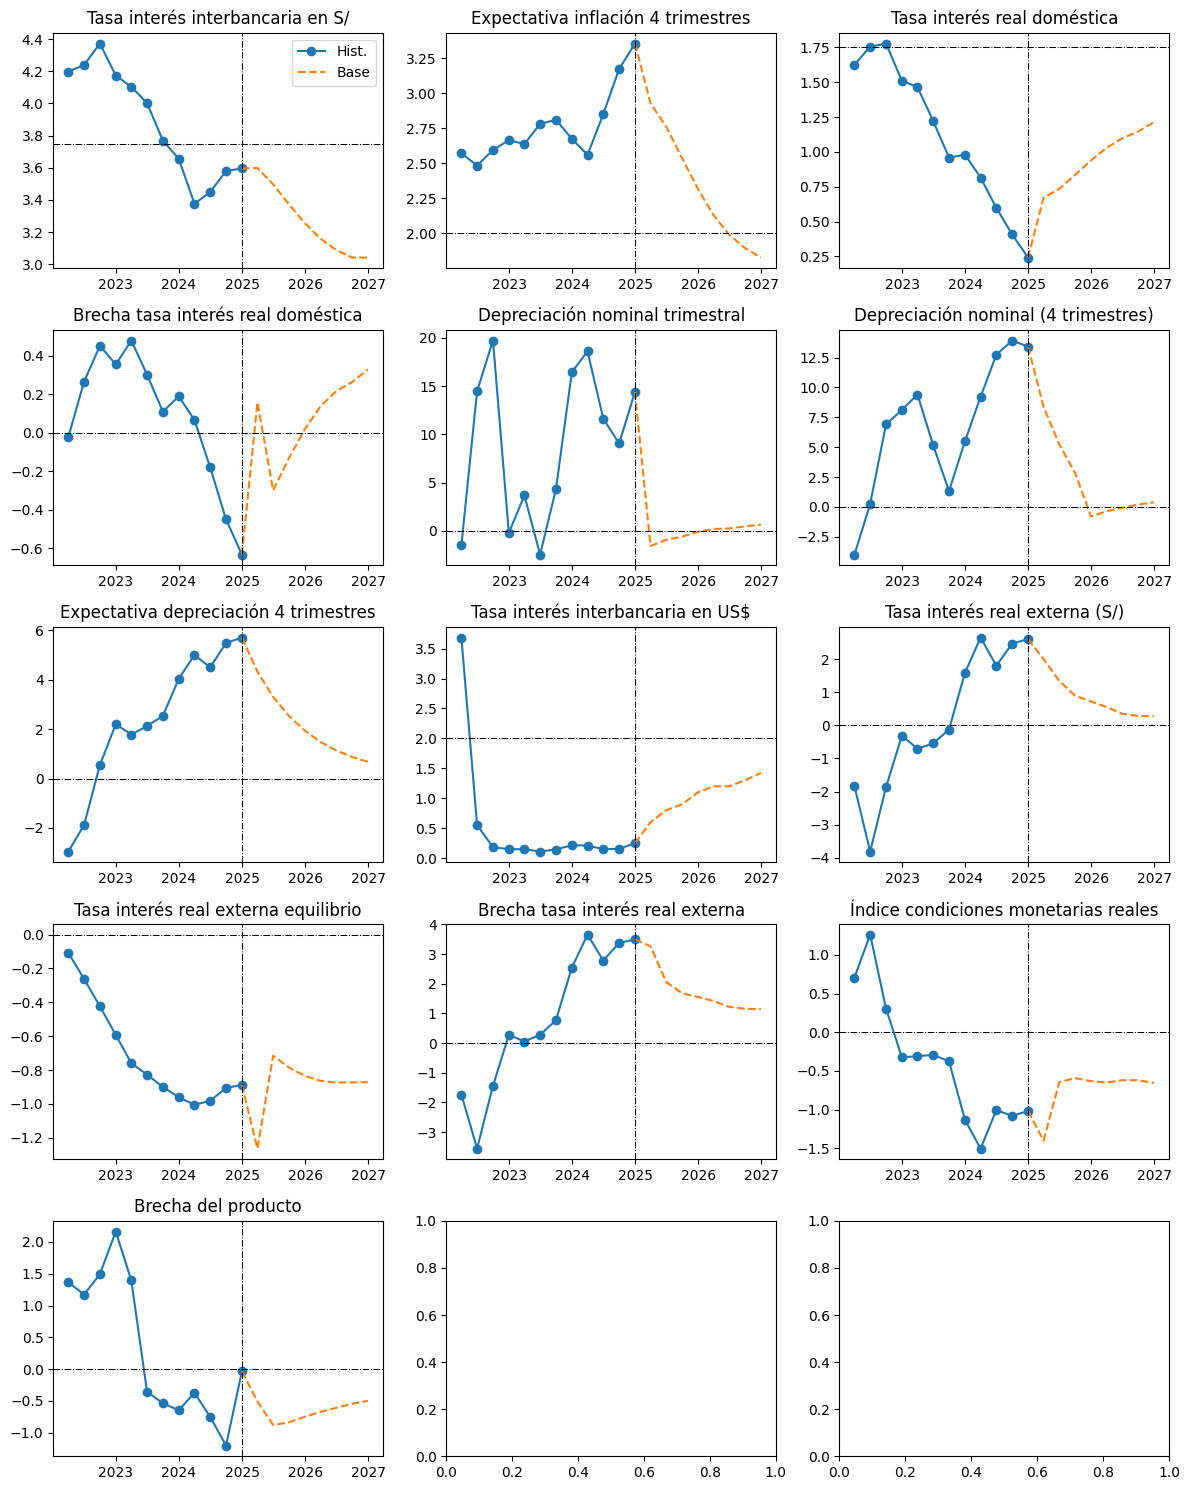

In [57]:
# Variables organizadas por categoría
variables = [
    # Tasas de interés domésticas
    'imn', 'ED4p', 'Rmn', 'rmn',
    # Tipo de cambio y tasas externas
    'Ds', 'D4s', 'ED4s', 'ime', 'Rme', 'Rme_eq', 'rme',
    # Variables macro
    'rmc', 'y'
]

# Nombres descriptivos
nombres = [
    # Tasas de interés domésticas
    'Tasa interés interbancaria en S/',
    'Expectativa inflación 4 trimestres',
    'Tasa interés real doméstica',
    'Brecha tasa interés real doméstica',

    # Tipo de cambio y tasas externas
    'Depreciación nominal trimestral',
    'Depreciación nominal (4 trimestres)',
    'Expectativa depreciación 4 trimestres',
    'Tasa interés interbancaria en US$',
    'Tasa interés real externa (S/)',
    'Tasa interés real externa equilibrio',
    'Brecha tasa interés real externa',

    # Variables macro
    'Índice condiciones monetarias reales',
    'Brecha del producto'
]

# Valores de estado estacionario
ss_values = [
    # Tasas domésticas
    3.75,   # imn (i_ss)
    2.00,   # ED4p (Dp_ss)
    1.75,   # Rmn (Rmn_ss)
    0.00,   # rmn

    # Tipo de cambio y externas
    0.00,   # Ds
    0.00,   # D4s
    0.00,   # ED4s
    2.00,   # ime (iext_ss)
    0.00,   # Rme (Rme_ss)
    0.00,   # Rme_eq
    0.00,   # rme

    # Macro
    0.00,   # rmc
    0.00    # y
]

# Configuración del gráfico (4x3 para 12 variables)
fig, axs = HTS.plotTSforecast(
    BDdictdove,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    5,  # 4 filas
    3   # 3 columnas
)

### **Reporte de las principales variables**
Tras un breve ciclo contractico destinado a combatir el periodo inflacionario de 2024, se decidió mantener la tasa de interés de referencia. Nos mantenemos a la espera de la evolución de las condiciones externas e inflación de alimentos y energía. Una vez se tengan indicios de la materialización de estas proyecciones, se podrá maniobrar con mayor facilidad hacia recortes de tasas.

Con estos recortes futuros, se busca minimizar el riesgo de un desanclaje de expectativas por debajo de la meta, así como facilitar un eventual cierre de la brecha.




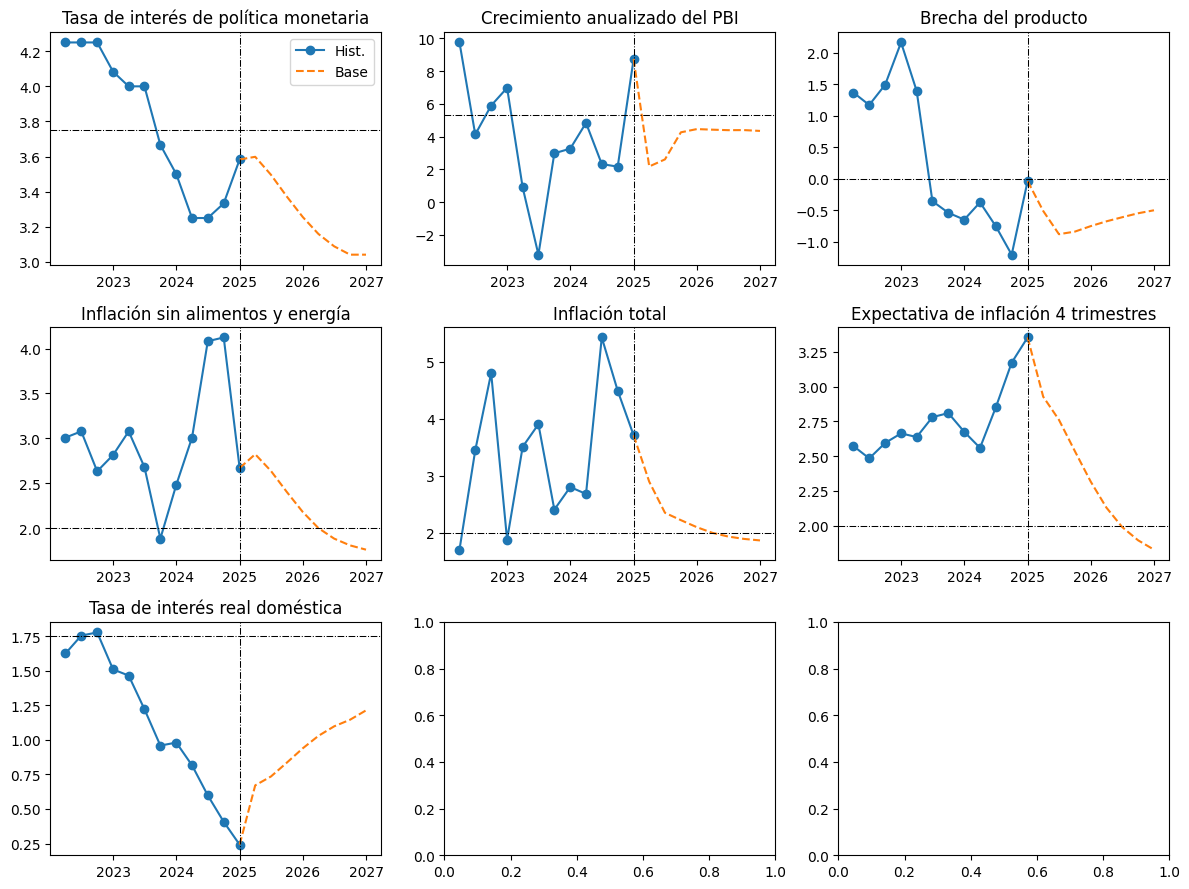

In [58]:
# Variables to plot - Monetary policy and inflation focus
variables = ['i', 'DY', 'y', 'Dpsae', 'Dp', 'ED4p', 'Rmn']

# Descriptive names
nombres = [
    'Tasa de interés de política monetaria',
    'Crecimiento anualizado del PBI',
    'Brecha del producto',
    'Inflación sin alimentos y energía',
    'Inflación total',
    'Expectativa de inflación 4 trimestres',
    'Tasa de interés real doméstica'
]

# Steady-state values
ss_values = [
    3.75,   # i (Rmn_ss + Dp_ss = 1.75 + 2.00)
    5.30,   # DY (DY_ss)
    0.00,   # y
    2.00,   # Dpsae (Dp_ss)
    2.00,   # Dp (Dp_ss)
    2.00,   # ED4p (Dp_ss)
    1.75    # Rmn (Rmn_ss)
]

# Plot configuration (3x3 grid with 2 empty spots)
fig, axs = HTS.plotTSforecast(
    BDdictdove,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    3,  # 3 rows
    3   # 3 columns
)

### Componentes de la brecha producto

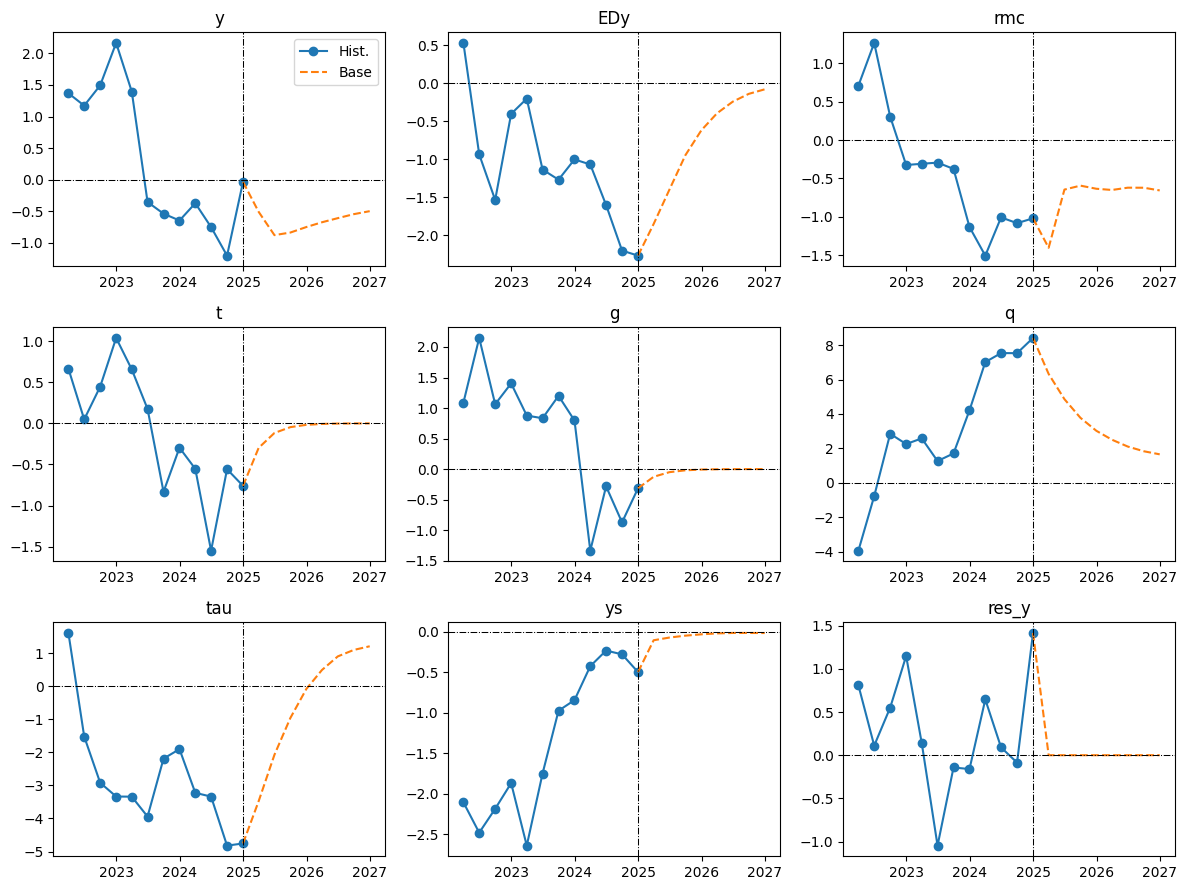

In [59]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdictdove,lista,listanames,listaSS,FH,HH,3,3)

### Cuadros de impacto

In [60]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_basedove['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_basedove['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_basedove['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_basedove['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_basedove['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_basedove['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_basedove['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_basedove['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_basedove['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_basedove['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.508223   -0.876957   -0.835935   -0.748664   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.339086   -0.585105   -0.557736   
Confianza: aEy*EDy         -0.236216   -0.178385   -0.120537   -0.078657   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.420491   -0.193474   -0.178042   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.146747    0.112769    0.087653    0.070113   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.673256   -0.608352   -0.545260   -0.497630  
Inercia: (ay+aEy)*y(-1)    -0.499508   -0.449196   -0.405893   -0.363797  
Confianza: aEy*EDy         -0.050155   -0.030546   -0.017463   -0.009816  
Cond. Mon.: armc*rmc(-1)   -0.190229   -0.194930   -0.186010   -0.186219  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.058096    0.048881    0.042579    0.038414  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [61]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_basedove['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_basedove['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_basedove['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_basedove['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_basedove['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_basedove['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_basedove['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.822714    2.636301   
Inflación importada a 4 trimestres: bm*D4pm        0.156383    0.131219   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667518   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.040950    1.924877   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.087313   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.401040    2.178321   
Inflación importada a 4 trimestres: bm*D4pm        0.160313    0.139447   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.623435    0.567800   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.767953    1.614688   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.150661   -0.143614   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.999299    1.881839   
Inflación importada a 4 trimestres: bm*D4pm        0.127558    0.136792   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.515131    0.472796   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.485230    1.387916   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128620   -0.115665   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.806317    1.758657  
Inflación importada a 4 trimestres: bm*D4pm        0.144395    0.150858  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.445019    0.427159  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.321418    1.274315  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.104515   -0.093676  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [62]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_basedove['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsl     = rho_Ds*UFDB_basedove['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_basedove['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_basedove['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_basedove['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_basedove['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsl,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.571318   -0.931799   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.628527   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.038089   -4.894845   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.607609   -0.105024    0.181939   
Expectativas de depreciación: rho_Ds*Ds    -0.372719   -0.243044   -0.042009   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.720368   -4.557504   -4.423058   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.242589    0.458431    0.639200  
Expectativas de depreciación: rho_Ds*Ds     0.072776    0.097036    0.183372  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.324299   -4.257767   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [63]:
# Tasa de interés real externa expresada en S/ de equilibrio
# Rme_eq = zme + cY_me*(DY_eq(+1)-DY_ss) + cR_me*(DYs_eq(+1)-DYs_ss)

# Brecha de la tasa de interés real externa expresada en S/
# rme = Rme - Rme_eq;

zme       = 0
cY_me     = 0.507100000000000
cR_me     = 0.461900000000000
DYs_ss    = 2.100000000000000
rho_zme   = 0.533200000000000
Rme_ss    = 0
m_res_zme = (0.140000000000000)**0.5
DY_ss     = 5.300000000000000

hist2show = 4

Rme_eq = UFDB_basedove['Rme_eq'].values[-(hist2show+FH):].reshape(-1,1)
zme    = UFDB_basedove['zme'].values[-(hist2show+FH):].reshape(-1,1)
DY_eq  = cY_me*UFDB_basedove['DY_eq'].values[-(hist2show+FH):].reshape(-1,1)
DYs_eq = cR_me*UFDB_basedove['DYs_eq'].values[-(hist2show+FH):].reshape(-1,1)

rme    = UFDB_basedove['rme'].values[-(hist2show+FH):].reshape(-1,1)
Rme    = UFDB_basedove['Rme'].values[-(hist2show+FH):].reshape(-1,1)
Rme_eq    = UFDB_basedove['Rme_eq'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Rme_eq,zme,DY_eq,DYs_eq,rme,Rme,Rme_eq], columns=['Tasa real natural en ME: Rme_eq','Otros factores tasa real natural ME: zme','Crecimiento PBI potencial: DY_eq','Crecimiento PBI externo potencial: DYs_eq','Brecha tasa de interes ME: rme','Tasa real en ME: Rme','Tasa real en ME natural: Rme_eq'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Tasa real natural en ME: Rme_eq             -1.004736   -0.981108   -0.905274   
Otros factores tasa real natural ME: zme     0.018867    0.036220    0.062949   
Crecimiento PBI potencial: DY_eq             1.897321    1.945915    2.015943   
Crecimiento PBI externo potencial: DYs_eq    0.726357    0.684101    0.663674   
Brecha tasa de interes ME: rme               3.659627    2.784010    3.378257   
Tasa real en ME: Rme                         2.654891    1.802902    2.472983   
Tasa real en ME natural: Rme_eq             -1.004736   -0.981108   -0.905274   

                                           2024-12-31  2025-03-31  2025-06-30  \
Tasa real natural en ME: Rme_eq             -0.887264   -1.263249   -0.715686   
Otros factores tasa real natural ME: zme     0.041666    0.022216    0.011846   
Crecimiento PBI potencial: DY_eq             2.059679    2.065959    2.072176   
Crecimiento PBI externo potencial: DYs_eq    0.659628    0.293211    0.850564   
Brecha tasa de interes ME: rme               3.494115    3.265125    2.060104   
Tasa real en ME: Rme                         2.606851    2.001876    1.344418   
Tasa real en ME natural: Rme_eq             -0.887264   -1.263249   -0.715686   

                                           2025-09-30  2025-12-31  2026-03-31  \
Tasa real natural en ME: Rme_eq             -0.785276   -0.834085   -0.863316   
Otros factores tasa real natural ME: zme     0.006316    0.003368    0.001796   
Crecimiento PBI potencial: DY_eq             2.078330    2.084423    2.090455   
Crecimiento PBI externo potencial: DYs_eq    0.779702    0.727285    0.693315   
Brecha tasa de interes ME: rme               1.679661    1.555305    1.417869   
Tasa real en ME: Rme                         0.894385    0.721220    0.554552   
Tasa real en ME natural: Rme_eq             -0.785276   -0.834085   -0.863316   

                                           2026-06-30  2026-09-30  2026-12-31  
Tasa real natural en ME: Rme_eq             -0.873612   -0.872629   -0.871526  
Otros factores tasa real natural ME: zme     0.000957    0.000511    0.000272  
Crecimiento PBI potencial: DY_eq             2.096427    2.102339    2.108192  
Crecimiento PBI externo potencial: DYs_eq    0.677790    0.673322    0.668824  
Brecha tasa de interes ME: rme               1.225277    1.156889    1.145032  
Tasa real en ME: Rme                         0.351666    0.284260    0.273506  
Tasa real en ME natural: Rme_eq             -0.873612   -0.872629   -0.871526

In [64]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_basedove['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_basedove['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_basedove['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_basedove['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_basedove['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_basedove['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_basedove['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_basedove['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_basedove['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.598635    3.496318   
Crecimiento PBI real: DY             8.730329    2.179321    2.611391   
Brecha producto: y                  -0.034537   -0.508223   -0.876957   
Inflación SAE: Dpsae                 2.669623    2.822714    2.636301   
Inflación total: Dp                  3.708887    2.896446    2.350880   
Expectativa de inflación: ED4p       3.353472    2.927691    2.761188   
Tasa real en moneda nacional: Rmn    0.241861    0.670944    0.735130   
Depreciación nominal: Ds            14.390420   -1.571318   -0.931799   
Inflación AE: Dpae                   4.993248    2.987568    1.998147   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.371692    3.255360    3.159327   
Crecimiento PBI real: DY             4.262549    4.459561    4.424005   
Brecha producto: y                  -0.835935   -0.748664   -0.673256   
Inflación SAE: Dpsae                 2.401040    2.178321    1.999299   
Inflación total: Dp                  2.221671    2.098565    1.999612   
Expectativa de inflación: ED4p       2.536085    2.316229    2.130526   
Tasa real en moneda nacional: Rmn    0.835607    0.939130    1.028801   
Depreciación nominal: Ds            -0.607609   -0.105024    0.181939   
Inflación AE: Dpae                   2.000000    2.000000    2.000000   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.088785    3.041262    3.041262  
Crecimiento PBI real: DY             4.393762    4.398177    4.347870  
Brecha producto: y                  -0.608352   -0.545260   -0.497630  
Inflación SAE: Dpsae                 1.881839    1.806317    1.758657  
Inflación total: Dp                  1.934687    1.892944    1.866600  
Expectativa de inflación: ED4p       1.990932    1.895541    1.827973  
Tasa real en moneda nacional: Rmn    1.097854    1.145721    1.213289  
Depreciación nominal: Ds             0.242589    0.458431    0.639200  
Inflación AE: Dpae                   2.000000    2.000000    2.000000

# Escenario de riesgo 5: Fenómeno del Niño (6%) [MANTENER 2 Y EMPEZAR A BAJAR] (FINAL)

In [65]:
UCond_riesgo5 = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_Riesgo5.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_riesgo5['Uvar']['var']['i'] = UFDB_base.i
    UCond_riesgo5['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_riesgo5['UShock'] or UCond_riesgo5['UShock'][var_soft_tune].isna().all():
                UCond_riesgo5['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [66]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo5['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo5['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo5['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_EDy  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  res_Dpm  \
2025-03-31 -0.928175        0.0  0.034531        0.0       0.0      0.0   
2025-06-30 -0.252591        0.0 -0.028215        0.0       0.0      0.0   
2025-09-30 -0.024282        0.0 -0.013382        0.0       0.0      0.0   
2025-12-31 -0.238605        0.0 -0.006415        0.0       0.0      0.0   
2026-03-31  0.107211        0.0 -0.010039        0.0       0.0      0.0   
2026-06-30 -0.136297        0.0 -0.012791        0.0       0.0      0.0   
2026-09-30 -0.118196        0.0 -0.012693        0.0       0.0      0.0   
2026-12-31 -0.099627        0.0 -0.020483        0.0       0.0      0.0   

            res_Meta  res_i  res_ieq  res_imn  ...         res_g   res_DTI  \
2025-03-31       0.0    0.0      0.0      0.0  ... -1.554312e-16  0.262743   
2025-06-30       0.0    0.0      0.0      0.0  ... -1.110223e-17  0.262743   
2025-09-30       0.0    0.0      0.0 

In [67]:
UFDB_riesgo5 = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo5)

UCond_riesgo5no = UCond_riesgo5
UCond_riesgo5no['Uvar']['var']['i'] = UCond_basedove['Uvar']['var']['i']

UFDB_riesgo5no = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo5no)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')
/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [68]:
print(f'Impacto 2025: {round((UFDB_riesgo5.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_riesgo5.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: 0.03
Impacto 2026: 0.02


<ipython-input-68-bbdb733e2076>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_riesgo5.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-68-bbdb733e2076>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_riesgo5.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


### **Proyecciones**

A diferencia del Escenario Base, ante un shock de oferta a raíz del Fenómeno del Niño, existe el riesgo de una **mayor Inflación de Alimentos y Energía**. Además, se proyecta una **caída transitoria en el crecimiento potencial del PBI** debido al daño a factores productivos.

Se espera que los mercados respondan con una **menor confianza empresarial** y una **mayor prima por riesgo**.

En respuesta, se proyecta un **impulso en el gasto público** por parte del gobierno.

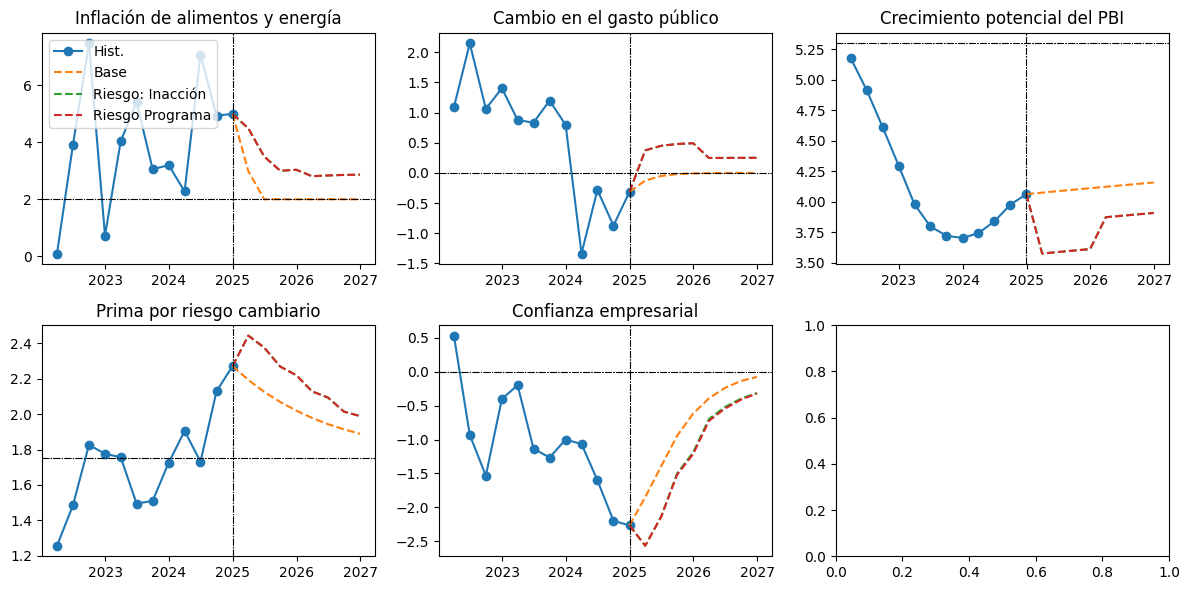

In [69]:
BDdict5 = {'Base': UFDB_basedove, 'Riesgo: Inacción': UFDB_riesgo5no, 'Riesgo Programa': UFDB_riesgo5}
lista = ['Dpae', 'g', 'DY_eq', 'x', 'EDy']
listanames = [
    'Inflación de alimentos y energía',
    'Cambio en el gasto público',
    'Crecimiento potencial del PBI',
    'Prima por riesgo cambiario',
    'Confianza empresarial'
]
listaSS = [
    2.00,   # Dpae (equal to inflation target)
    0.00,   # g (no change in steady state)
    5.30,   # DY_eq (potential growth)
    1.75,   # x (risk premium, Rmn_ss - Rme_ss = 1.75 - 0.00)
    0.00    # EDy (business confidence gap)
]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

### **Canal de expectativas**
La estabilización de la **Inflación en Alimentos y Energía** en un nivel más alto que el Escenario Base resulta en una **mayor Inflación Total**, la cual no termina de llegar a la meta a finales del horizonte de proyección. No obstante, la alternativa de política permite **controlar la Inflación Sin Alimentos y Energía** y **anclar las Expectativas de Inflación en la meta** para finales de 2026.

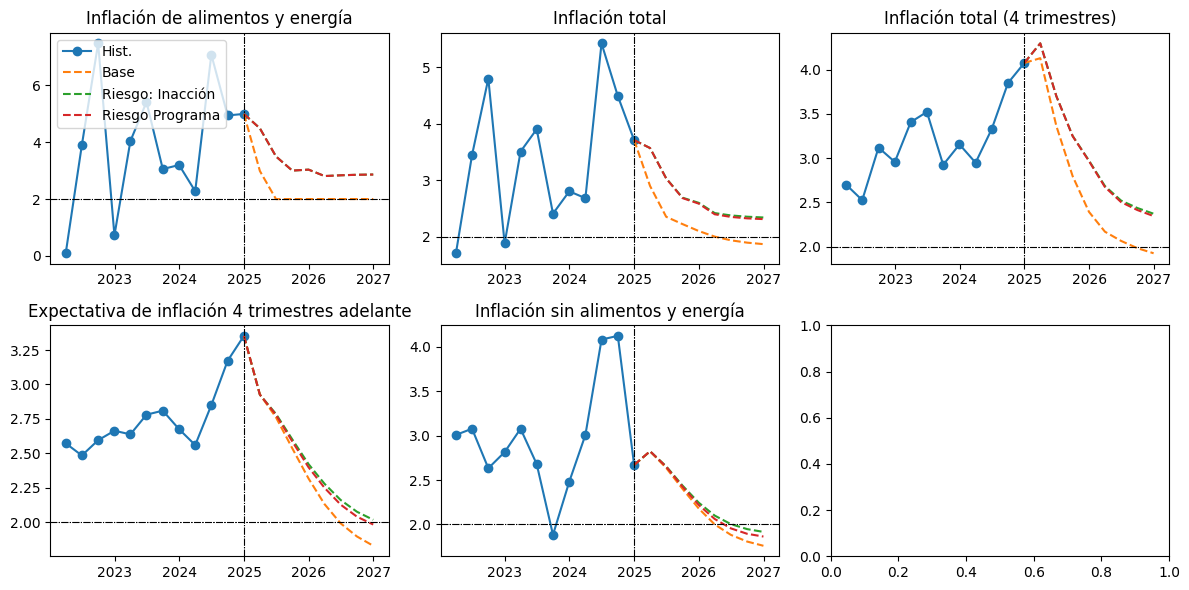

In [70]:
lista = ['Dpae', 'Dp', 'D4p', 'ED4p', 'Dpsae']

listanames = [
    'Inflación de alimentos y energía',
    'Inflación total',
    'Inflación total (4 trimestres)',
    'Expectativa de inflación 4 trimestres adelante',
    'Inflación sin alimentos y energía'
]

listaSS = [2.00, 2.00, 2.00, 2.00, 2.00]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,2,3)

### **Canal de tipo de cambio**
No cambia mucho respecto del base

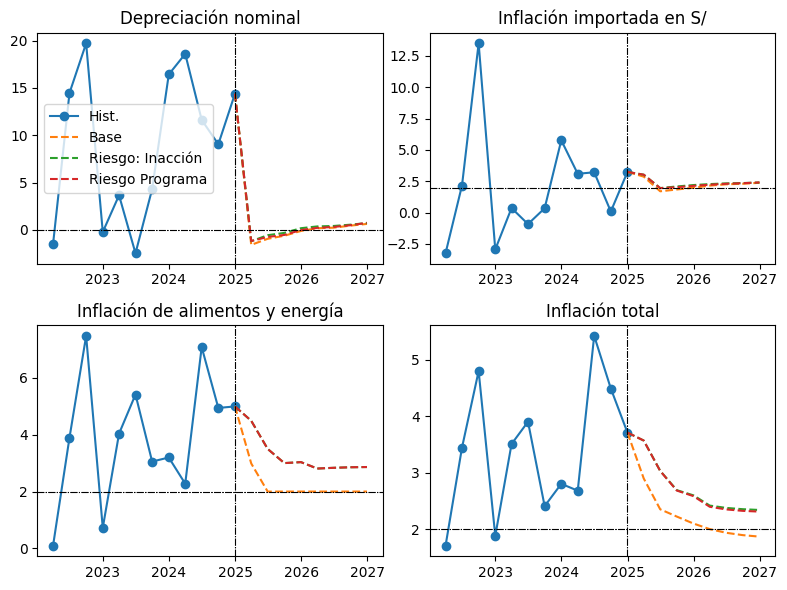

In [71]:
#Empezamos por el aumento del riesgo pais
lista = ['Ds', 'Dpm', 'Dpae', 'Dp']

listanames = [
    'Depreciación nominal',
    'Inflación importada en S/',
    'Inflación de alimentos y energía',
    'Inflación total'
]

listaSS = [0.00, 2.00, 2.00, 2.00]

# Configuración del gráfico
HH = 12  # Horizonte de pronóstico

# Crear el gráfico
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,2,2)

### **Canal de tasas de interés**
La transmisión hacia las condiciones monetarias presente una evolución similar al Escenario Base.

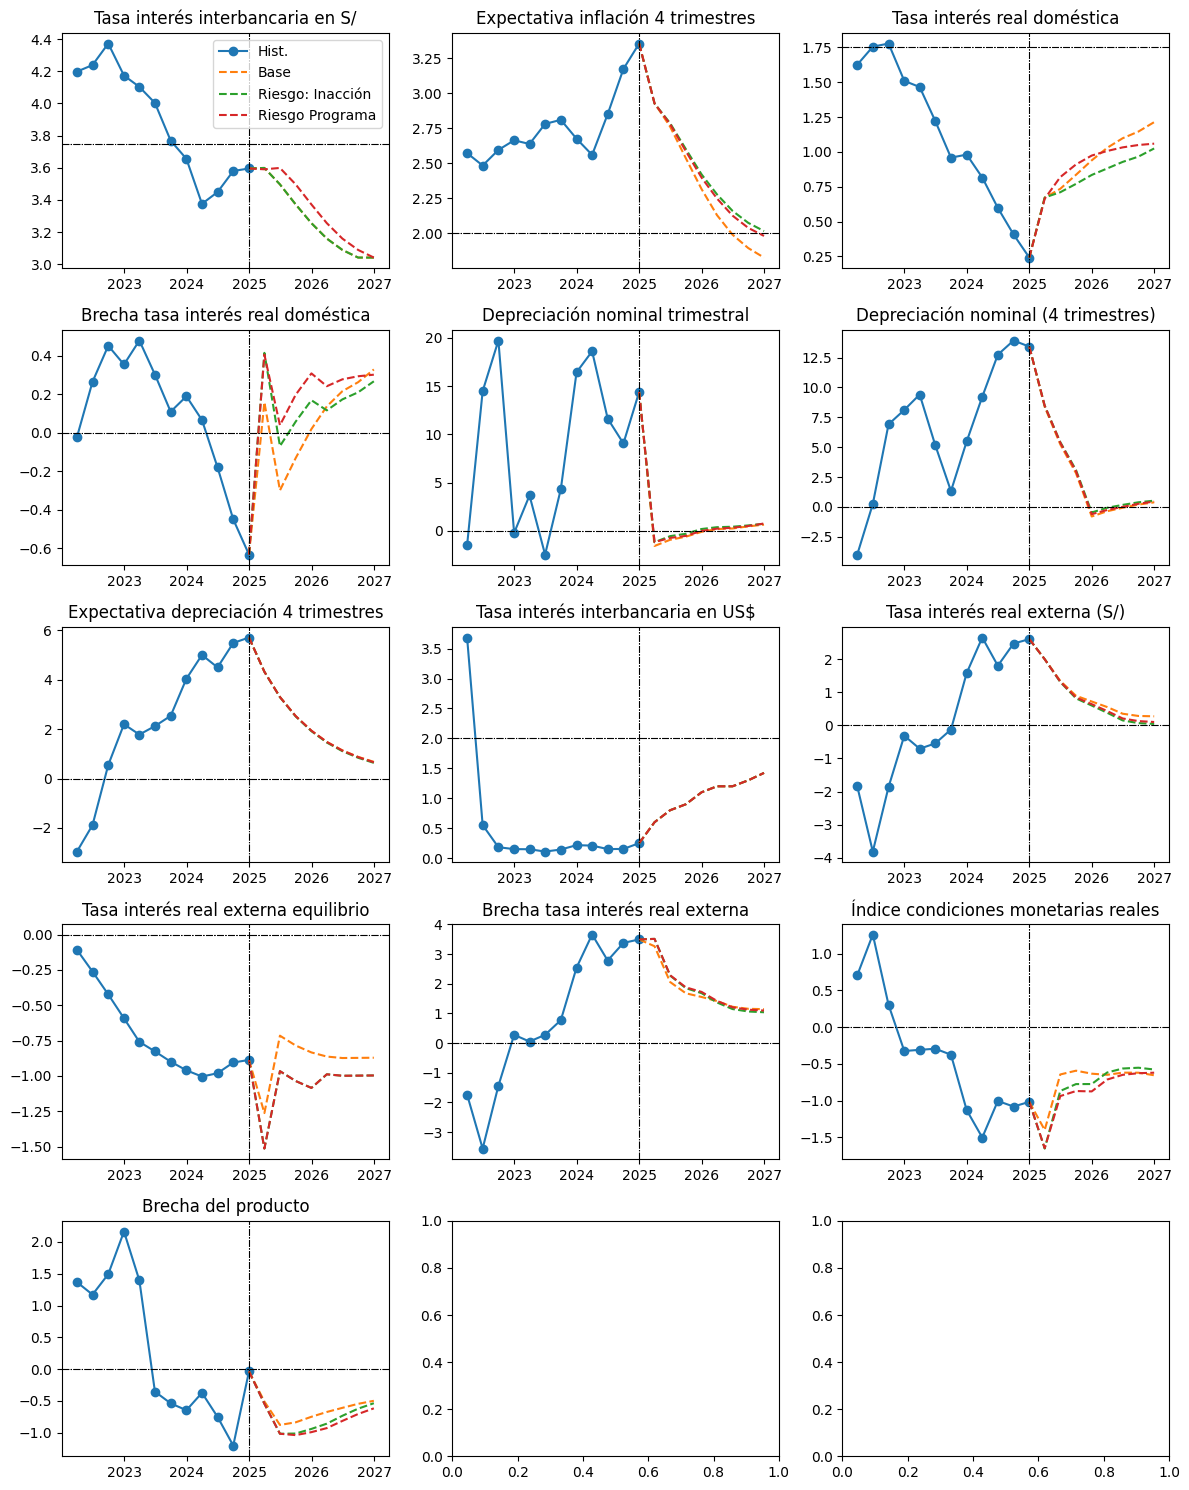

In [72]:
# Variables organizadas por categoría
variables = [
    # Tasas de interés domésticas
    'imn', 'ED4p', 'Rmn', 'rmn',
    # Tipo de cambio y tasas externas
    'Ds', 'D4s', 'ED4s', 'ime', 'Rme', 'Rme_eq', 'rme',
    # Variables macro
    'rmc', 'y'
]

# Nombres descriptivos
nombres = [
    # Tasas de interés domésticas
    'Tasa interés interbancaria en S/',
    'Expectativa inflación 4 trimestres',
    'Tasa interés real doméstica',
    'Brecha tasa interés real doméstica',

    # Tipo de cambio y tasas externas
    'Depreciación nominal trimestral',
    'Depreciación nominal (4 trimestres)',
    'Expectativa depreciación 4 trimestres',
    'Tasa interés interbancaria en US$',
    'Tasa interés real externa (S/)',
    'Tasa interés real externa equilibrio',
    'Brecha tasa interés real externa',

    # Variables macro
    'Índice condiciones monetarias reales',
    'Brecha del producto'
]

# Valores de estado estacionario
ss_values = [
    # Tasas domésticas
    3.75,   # imn (i_ss)
    2.00,   # ED4p (Dp_ss)
    1.75,   # Rmn (Rmn_ss)
    0.00,   # rmn

    # Tipo de cambio y externas
    0.00,   # Ds
    0.00,   # D4s
    0.00,   # ED4s
    2.00,   # ime (iext_ss)
    0.00,   # Rme (Rme_ss)
    0.00,   # Rme_eq
    0.00,   # rme

    # Macro
    0.00,   # rmc
    0.00    # y
]

# Configuración del gráfico (4x3 para 12 variables)
fig, axs = HTS.plotTSforecast(
    BDdict5,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    5,  # 4 filas
    3   # 3 columnas
)

### **Reporte de Variables relevantes**
Si bien el Banco Central no debe responder a shocks de oferta, un escenario como el fenómeno del Niño incrementa el riesgo de **contaminación de Expectativas de Inflación** debido al aumento de la **Inflación Total** por medio de la **Inflación de Alimentos y Energía**. Al **mantener la Tasa de interés de referencia durante un periodo más**, se minimiza este riesgo con un sacrifico mínimo en términos de brecha producto. Con esta política, **se logra anclar las Expectativas de Inflación al 2%** hacia el final del horizonte de proyección. La **Inflación subyacente** también regresa a su meta.

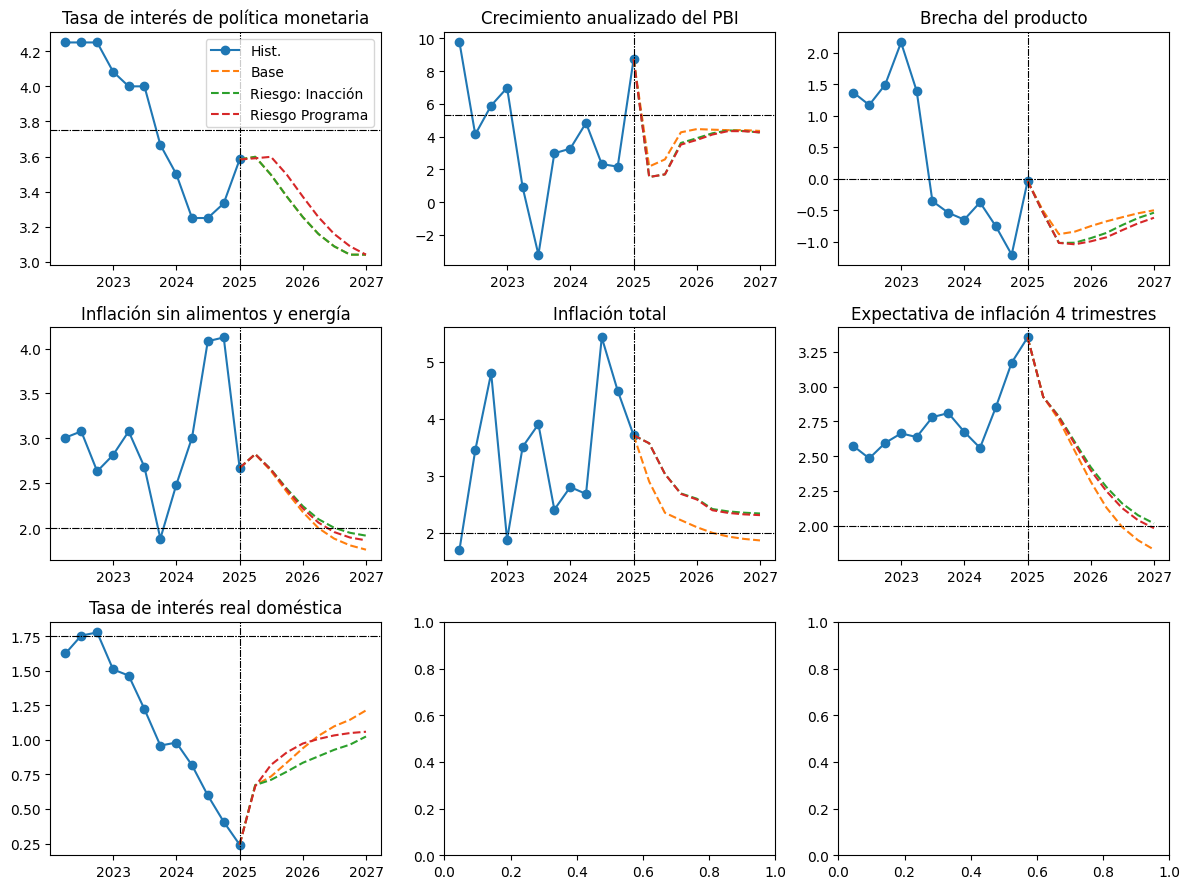

In [73]:
# Variables to plot - Monetary policy and inflation focus
variables = ['i', 'DY', 'y', 'Dpsae', 'Dp', 'ED4p', 'Rmn']

# Descriptive names
nombres = [
    'Tasa de interés de política monetaria',
    'Crecimiento anualizado del PBI',
    'Brecha del producto',
    'Inflación sin alimentos y energía',
    'Inflación total',
    'Expectativa de inflación 4 trimestres',
    'Tasa de interés real doméstica'
]

# Steady-state values
ss_values = [
    3.75,   # i (Rmn_ss + Dp_ss = 1.75 + 2.00)
    5.30,   # DY (DY_ss)
    0.00,   # y
    2.00,   # Dpsae (Dp_ss)
    2.00,   # Dp (Dp_ss)
    2.00,   # ED4p (Dp_ss)
    1.75    # Rmn (Rmn_ss)
]

# Plot configuration (3x3 grid with 2 empty spots)
fig, axs = HTS.plotTSforecast(
    BDdict5,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    3,  # 3 rows
    3   # 3 columns
)

### Otras variables

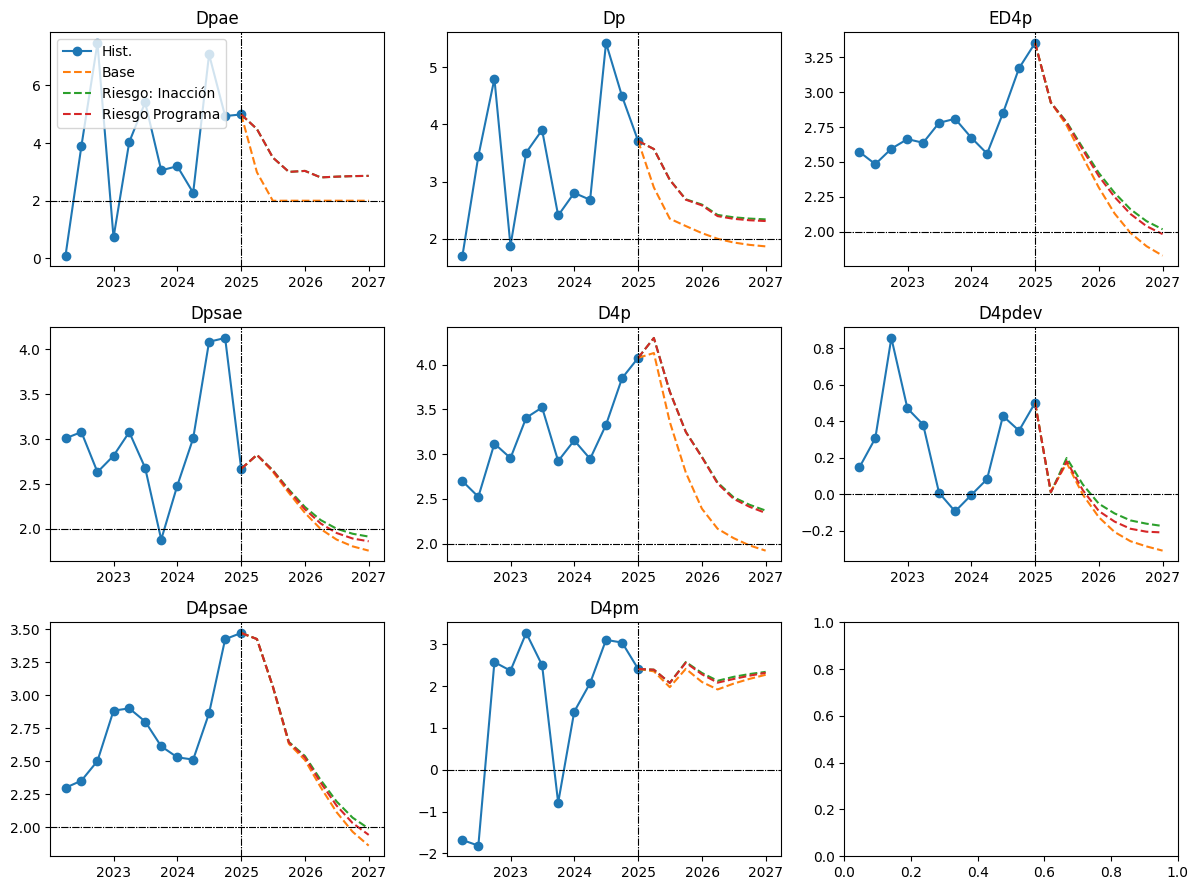

In [74]:
#Aumento de AE
lista = ['Dpae','Dp','ED4p','Dpsae','D4p','D4pdev','D4psae','D4pm']
listanames = lista
listaSS = [2,2,2,2,2,0,2,0]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

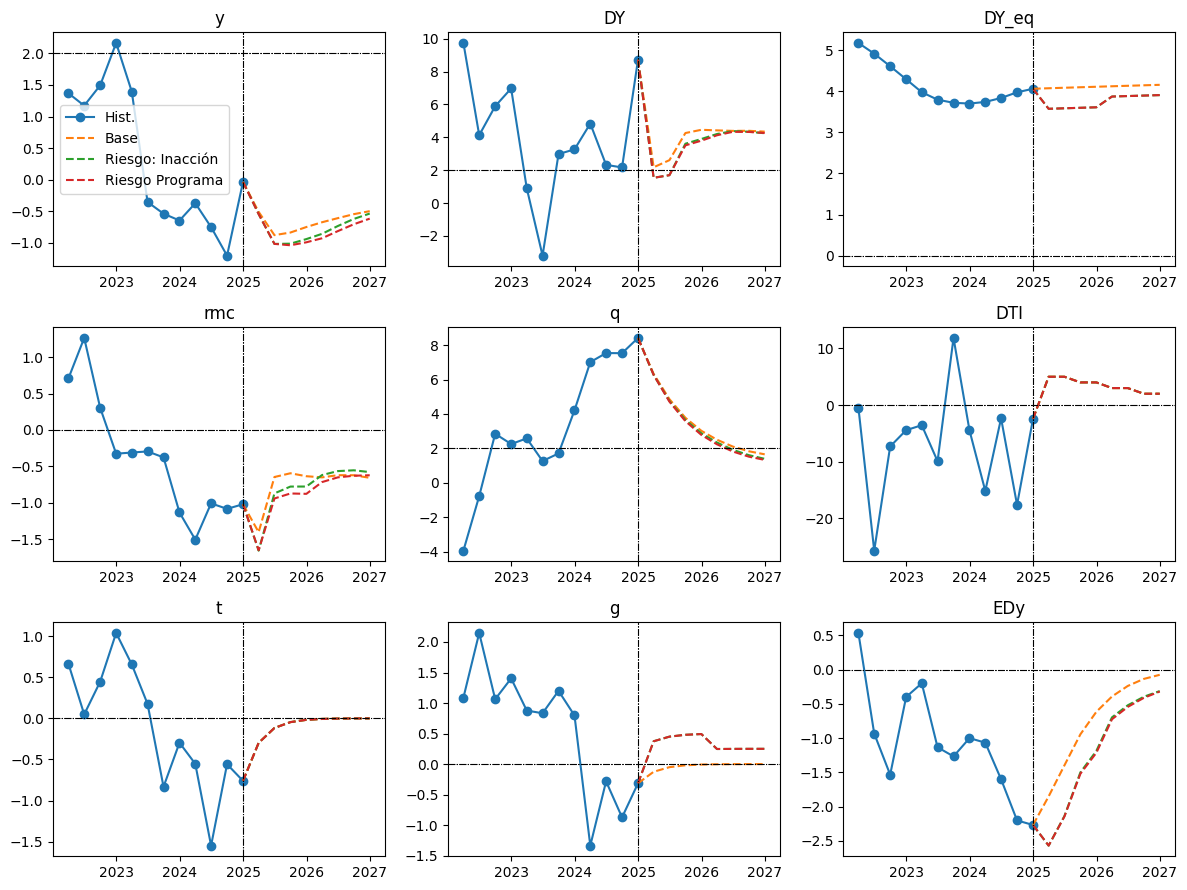

In [75]:
# Brecha de producto
lista = ['y','DY','DY_eq','rmc','q','DTI','t','g','EDy']
listanames = lista
listaSS = [2,2,0,0,2,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

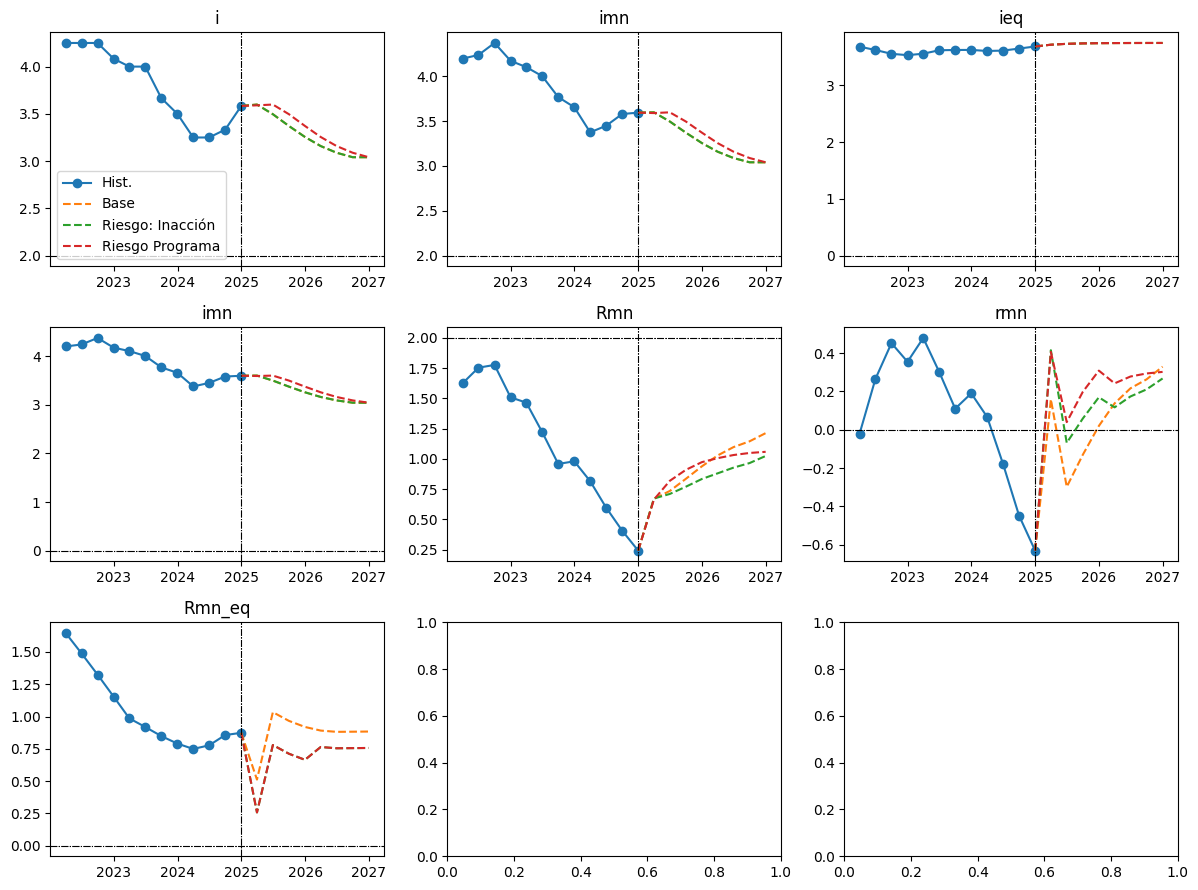

In [76]:
# Tasa de interes nacional
lista = ['i','imn','ieq','imn','Rmn','rmn','Rmn_eq']
listanames = lista
listaSS = [2,2,0,0,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

### Cuadros de impacto

In [77]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo5['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo5['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo5['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo5['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo5['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo5['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo5['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo5['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo5['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo5['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.543529   -1.015732   -1.037252   -0.990392   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.362643   -0.677696   -0.692054   
Confianza: aEy*EDy         -0.327842   -0.273638   -0.193983   -0.154954   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.494726   -0.281838   -0.261233   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g            0.043048    0.051762    0.055258    0.056660   
TCRM: aq*q                  0.145466    0.109438    0.083135    0.064591   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.926785   -0.813798   -0.705073   -0.616120  
Inercia: (ay+aEy)*y(-1)    -0.660790   -0.618351   -0.542966   -0.470425  
Confianza: aEy*EDy         -0.092530   -0.069561   -0.052797   -0.040954  
Cond. Mon.: armc*rmc(-1)   -0.262714   -0.214362   -0.194945   -0.188259  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g            0.028423    0.028649    0.028739    0.028776  
TCRM: aq*q                  0.051907    0.042237    0.035308    0.030929  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [78]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_riesgo5['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_riesgo5['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_riesgo5['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_riesgo5['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_riesgo5['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_riesgo5['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_riesgo5['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.824376    2.650129   
Inflación importada a 4 trimestres: bm*D4pm        0.158944    0.137927   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667911   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.040050    1.937670   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.093378   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.425297    2.218680   
Inflación importada a 4 trimestres: bm*D4pm        0.170075    0.151642   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.626705    0.573536   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.803020    1.671701   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.174503   -0.178200   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.060730    1.955065   
Inflación importada a 4 trimestres: bm*D4pm        0.138358    0.144177   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.524675    0.487323   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.567846    1.482786   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.170149   -0.159222   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.893723    1.862672  
Inflación importada a 4 trimestres: bm*D4pm        0.149463    0.154003  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.462335    0.447829  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.421735    1.381971  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.139811   -0.121132  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [79]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_riesgo5['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf     = rho_Ds*UFDB_riesgo5['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_riesgo5['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_riesgo5['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_riesgo5['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_riesgo5['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.169996   -0.735881   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.467998   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.420333    3.325546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.026334   -5.038089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.526617   -0.007451    0.222611   
Expectativas de depreciación: rho_Ds*Ds    -0.294353   -0.210647   -0.002980   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.175243    3.107210    2.979572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.894845   -4.720368   -4.557504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.320208    0.498513    0.754759  
Expectativas de depreciación: rho_Ds*Ds     0.089044    0.128083    0.199405  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.930741    2.819372    2.784324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.423058   -4.324299   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [80]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_riesgo5['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_riesgo5['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_riesgo5['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_riesgo5['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_riesgo5['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_riesgo5['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_riesgo5['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_riesgo5['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_riesgo5['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.590239    3.598635   
Crecimiento PBI real: DY             8.730329    1.538096    1.697517   
Brecha producto: y                  -0.034537   -0.543529   -1.015732   
Inflación SAE: Dpsae                 2.669623    2.824376    2.650129   
Inflación total: Dp                  3.708887    3.568255    3.029414   
Expectativa de inflación: ED4p       3.353472    2.926401    2.779540   
Tasa real en moneda nacional: Rmn    0.241861    0.663837    0.819096   
Depreciación nominal: Ds            14.390420   -1.169996   -0.735881   
Inflación AE: Dpae                   4.993248    4.487568    3.498147   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.496318    3.371692    3.255360   
Crecimiento PBI real: DY             3.512381    3.797916    4.126800   
Brecha producto: y                  -1.037252   -0.990392   -0.926785   
Inflación SAE: Dpsae                 2.425297    2.218680    2.060730   
Inflación total: Dp                  2.682586    2.583633    2.395327   
Expectativa de inflación: ED4p       2.586387    2.398014    2.249036   
Tasa real en moneda nacional: Rmn    0.909931    0.973678    1.006324   
Depreciación nominal: Ds            -0.526617   -0.007451    0.222611   
Inflación AE: Dpae                   3.000552    3.034655    2.808835   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.159327    3.088785    3.041262  
Crecimiento PBI real: DY             4.336097    4.330709    4.263160  
Brecha producto: y                  -0.813798   -0.705073   -0.616120  
Inflación SAE: Dpsae                 1.955065    1.893723    1.862672  
Inflación total: Dp                  2.348611    2.323121    2.309726  
Expectativa de inflación: ED4p       2.127020    2.039444    1.982403  
Tasa real en moneda nacional: Rmn    1.032307    1.049342    1.058859  
Depreciación nominal: Ds             0.320208    0.498513    0.754759  
Inflación AE: Dpae                   2.834970    2.853786    2.862211

# Escenario de riesgo 6: Expansión demanda externa China (10%) [SUBIR 1, MANTENER 1, BAJAR] (FINAL)

In [81]:
UCond_riesgo6 = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_Riesgo6.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_riesgo6['Uvar']['var']['i'] = UFDB_base.i+0.25
    UCond_riesgo6['Uvar']['shock'].append('res_i')

#if tpmfija:
#    UCond_riesgo6['Uvar']['var']['i'] = pd.Series(
#    np.append(UFDB_base.i.iloc[-(FH):].values[0], UFDB_base.i.iloc[-(FH):].values[0:-1]),
#    index=UFDB_base.i.index[-FH:]  # Mantiene la coherencia del índice
#)+0.25
#    UCond_riesgo6['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_riesgo6['UShock'] or UCond_riesgo6['UShock'][var_soft_tune].isna().all():
                UCond_riesgo6['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [82]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo6['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo6['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo6['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_EDy  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  res_Dpm  \
2025-03-31  1.259783        0.0  0.034531        0.0       0.0      0.0   
2025-06-30  0.311962        0.0 -0.028215        0.0       0.0      0.0   
2025-09-30  0.266814        0.0 -0.013382        0.0       0.0      0.0   
2025-12-31  0.323849        0.0 -0.006415        0.0       0.0      0.0   
2026-03-31  0.363776        0.0 -0.010039        0.0       0.0      0.0   
2026-06-30  0.381988        0.0 -0.012791        0.0       0.0      0.0   
2026-09-30  0.391477        0.0 -0.012693        0.0       0.0      0.0   
2026-12-31  0.402446        0.0 -0.020483        0.0       0.0      0.0   

            res_Meta  res_i  res_ieq  res_imn  ...         res_g   res_DTI  \
2025-03-31       0.0    0.0      0.0      0.0  ... -1.554312e-16  0.262743   
2025-06-30       0.0    0.0      0.0      0.0  ... -1.110223e-17  0.262743   
2025-09-30       0.0    0.0      0.0 

In [83]:
UFDB_riesgo6 = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo6)

UCond_riesgo6no = UCond_riesgo6
UCond_riesgo6no['Uvar']['var']['i'] = UCond_basedove['Uvar']['var']['i']

UFDB_riesgo6no = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo6no)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')
/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [84]:
print(f'Impacto 2025: {round((UFDB_riesgo6.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_riesgo6.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: 0.0
Impacto 2026: 0.01


<ipython-input-84-a8b250576057>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_riesgo6.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-84-a8b250576057>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_riesgo6.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


### **Proyecciones**

Este tipo de choques traen tres tipos de consecuencias: un **aumento de la brecha de producto de nuestros socios comerciales**, un **aumento del crecimiento anualizado de los términos de intercambio** y **una mejora de la confianza empresarial**.

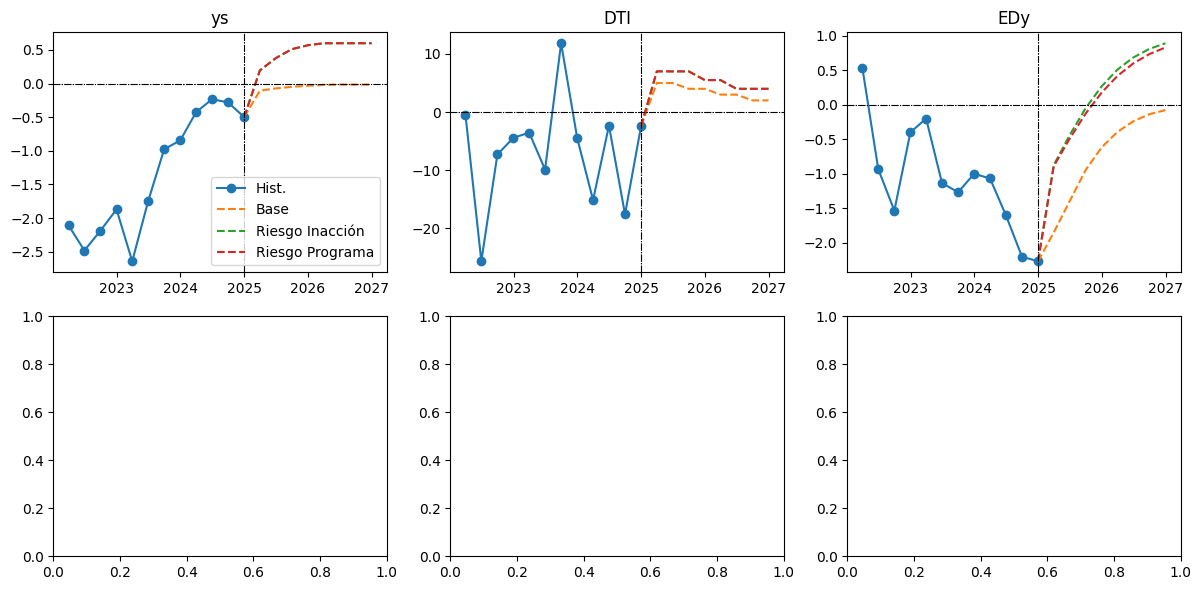

In [85]:
BDdict6 = {'Base': UFDB_basedove, 'Riesgo Inacción': UFDB_riesgo6no, 'Riesgo Programa': UFDB_riesgo6}
lista = ['ys','DTI','EDy']
listanames = lista
listaSS = [0,0,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

### Canal externo (Tipo de cambio real multilateral)
Con respecto a nuestro escenario base, un **aumento en la brecha de producto en nuestros socios comerciales**, sobrecalienta sus economías generando **mayor inflación** y un **aumento de sus tasas de interés de corto plazo**. La mayor inflación externa **aumenta la depreciación real multilateral** haciendo que la **brecha de tipo de cambio real mejore** aumentando la **brecha de producto** de nuestra economía.

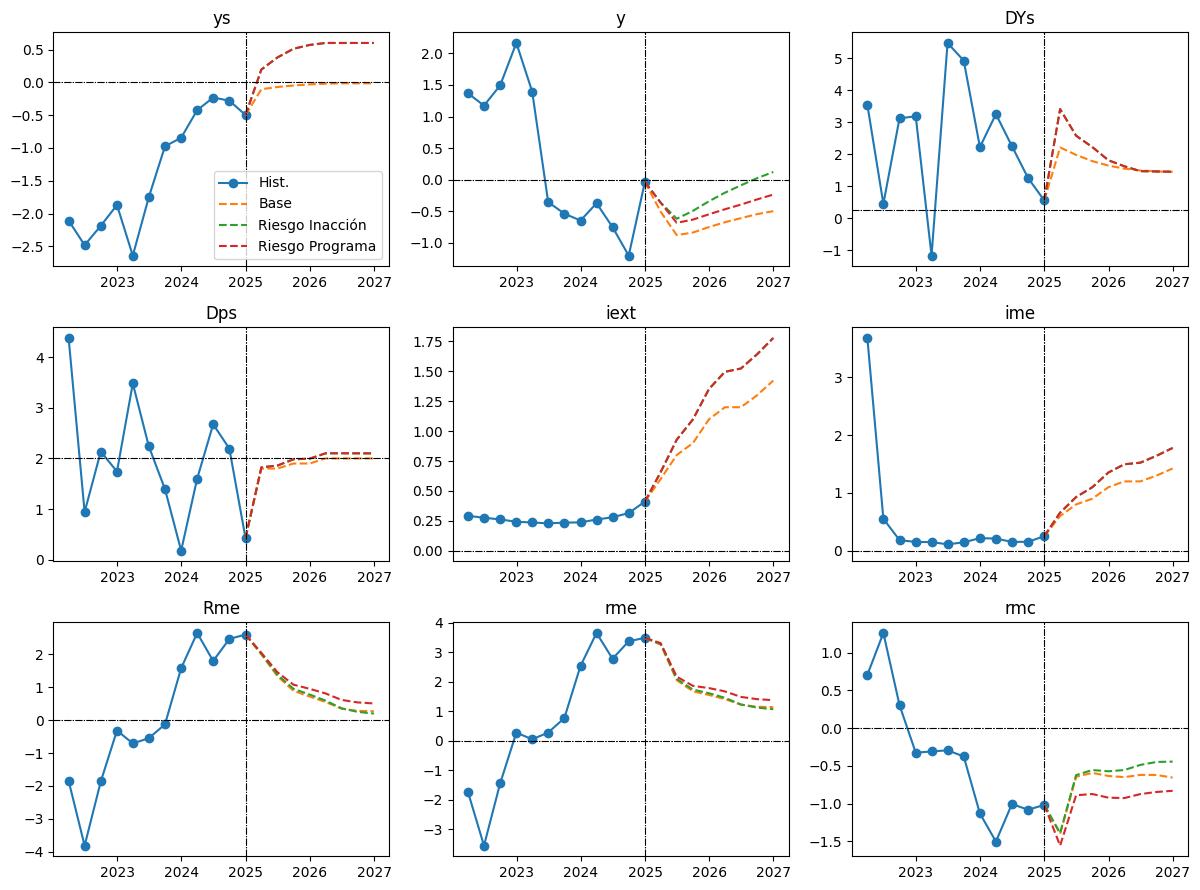

In [86]:
# Mayor brecha producto externa
lista = ['ys','y','DYs','Dps','iext','ime','Rme','rme','rmc']
listanames = lista
listaSS = [0,0,0.25,2,0,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,3,3)

### **Canal externo (TI)**
Los **términos de intercambio favorables** contribuyen con una mayor brecha producto mediante el **impulso de términos de intercambio** en la demanda agregada

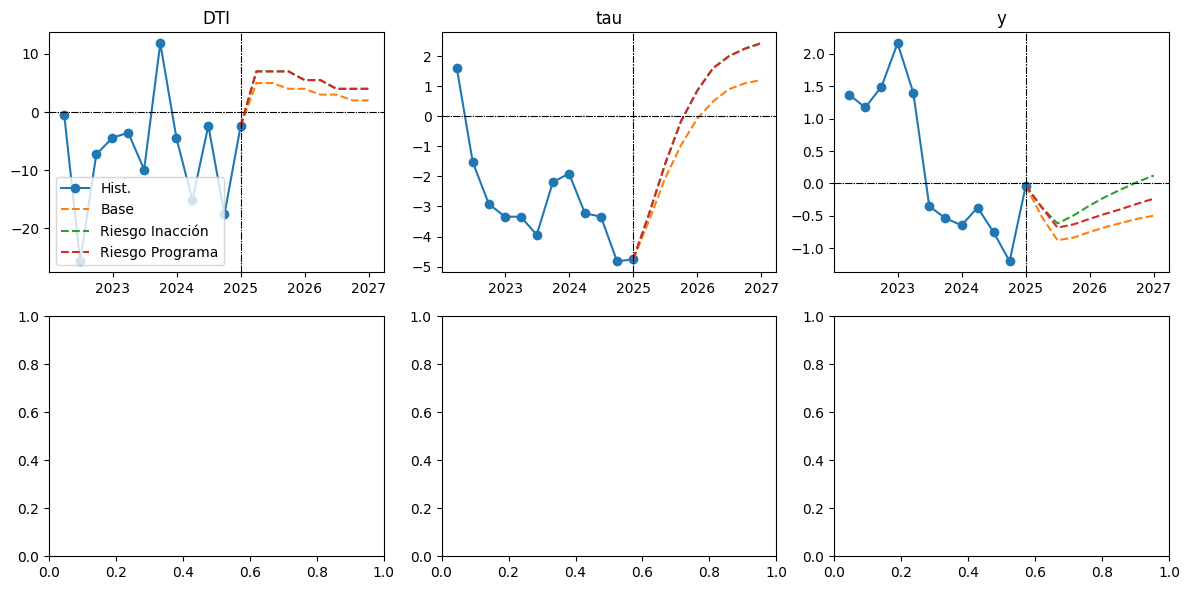

In [87]:
lista = ['DTI','tau','y']
listanames = lista
listaSS = [0,0,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,2,3)

### **Canal de expectativas (Inflación)**
**Si mantuvieramos la senda de tasas del Escenario Base**, el **aumento de la brecha de producto**, mediante la curva de Phillips, provoca un **aumento de la inflación SAE** y está, a su vez, de la inflación total. El aumento en ambas genera una **corrección al alza de las expectativas de inflación** de los agentes. Así, se tiene que ni la inflación total ni las expectativas de inflación converjan a la meta.


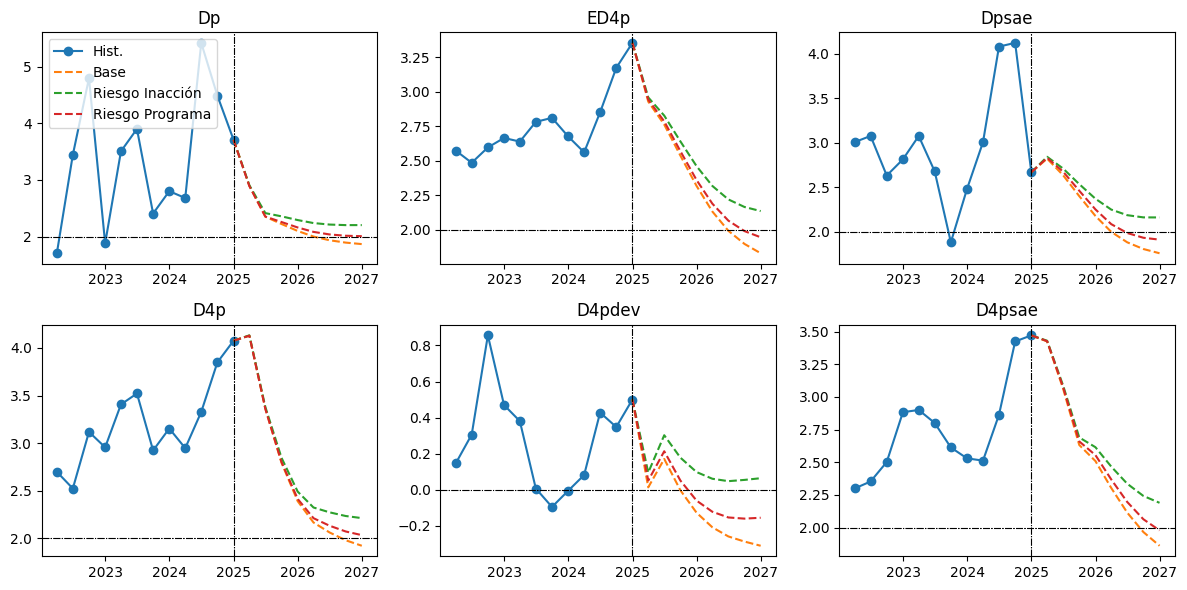

In [88]:
# Inflación
lista = ['Dp','ED4p','Dpsae','D4p','D4pdev','D4psae']
listanames = lista
listaSS = [2,2,2,2,0,2,2]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,2,3)

### **Canal de tasas de interés**

Si **continuáramos con la senda del Escenario Base**, el efecto de la **corrección al alza en las expectativas de inflación supera al aumento de las tasa de interés en moneda nacional**. En consecuencia, la tasa de interés real doméstica y su brecha son menores, lo cual **no tendría impacto sobre las condiciones monetarias** en el corto plazo.


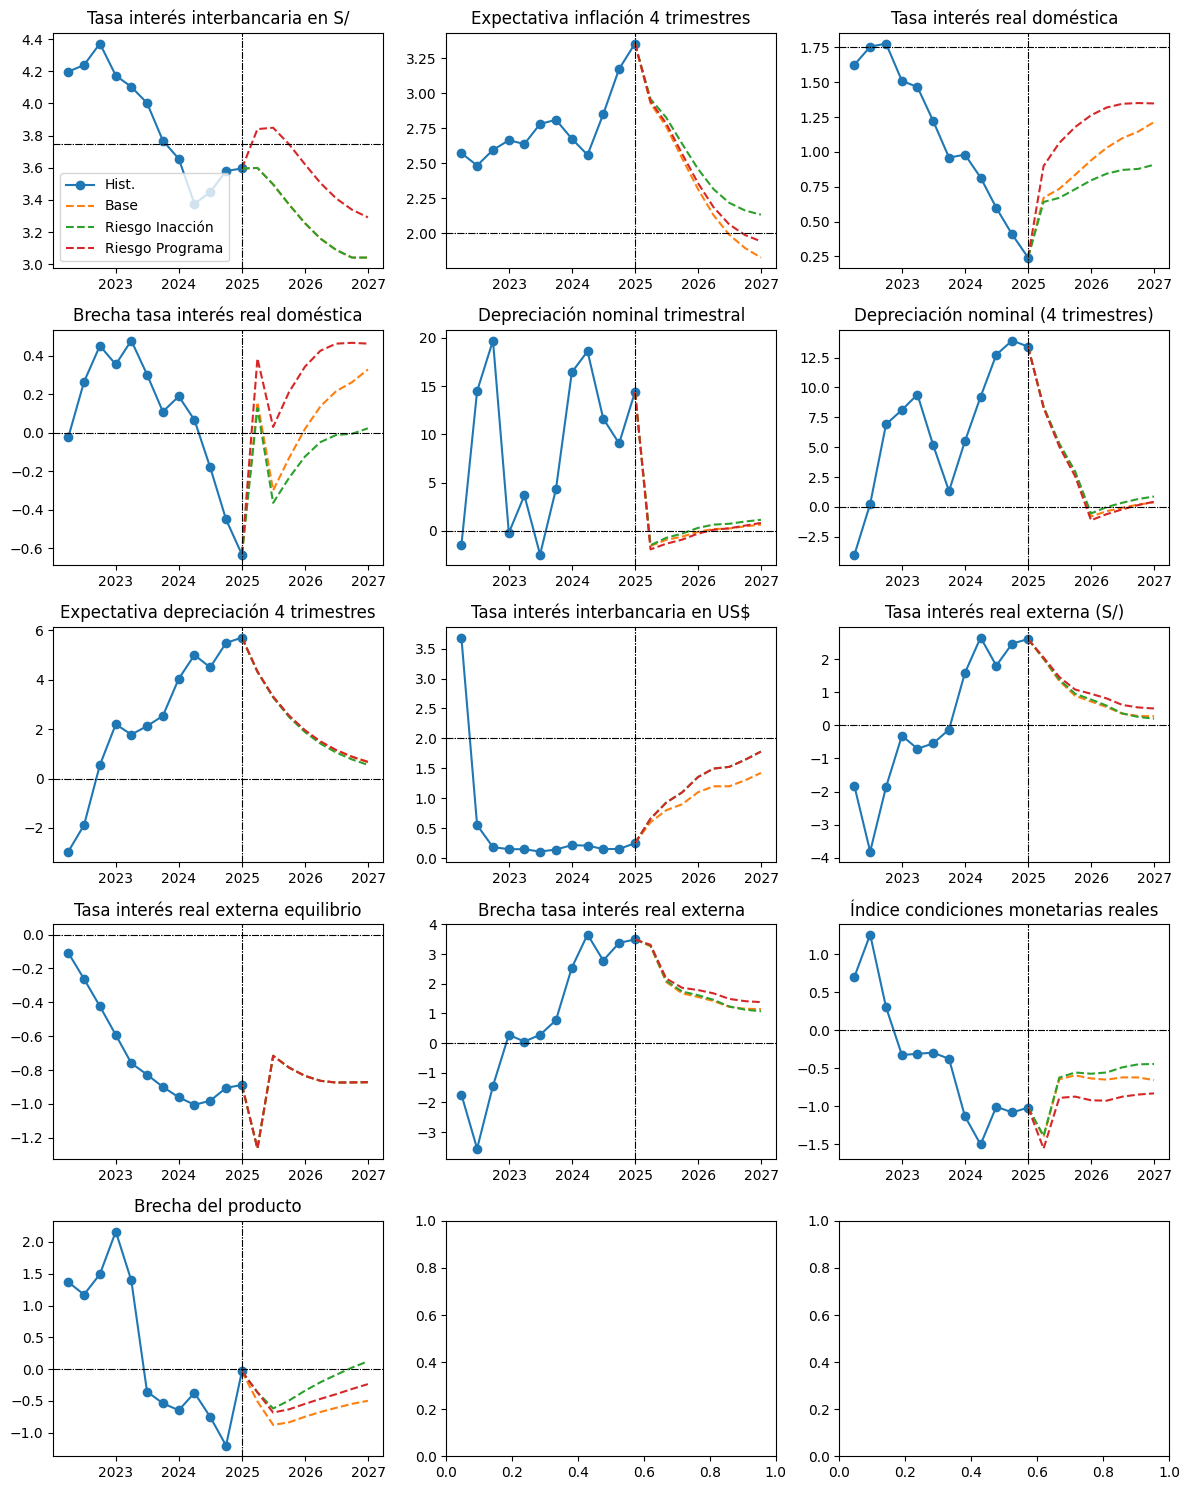

In [89]:
# Variables organizadas por categoría
variables = [
    # Tasas de interés domésticas
    'imn', 'ED4p', 'Rmn', 'rmn',
    # Tipo de cambio y tasas externas
    'Ds', 'D4s', 'ED4s', 'ime', 'Rme', 'Rme_eq', 'rme',
    # Variables macro
    'rmc', 'y'
]

# Nombres descriptivos
nombres = [
    # Tasas de interés domésticas
    'Tasa interés interbancaria en S/',
    'Expectativa inflación 4 trimestres',
    'Tasa interés real doméstica',
    'Brecha tasa interés real doméstica',

    # Tipo de cambio y tasas externas
    'Depreciación nominal trimestral',
    'Depreciación nominal (4 trimestres)',
    'Expectativa depreciación 4 trimestres',
    'Tasa interés interbancaria en US$',
    'Tasa interés real externa (S/)',
    'Tasa interés real externa equilibrio',
    'Brecha tasa interés real externa',

    # Variables macro
    'Índice condiciones monetarias reales',
    'Brecha del producto'
]

# Valores de estado estacionario
ss_values = [
    # Tasas domésticas
    3.75,   # imn (i_ss)
    2.00,   # ED4p (Dp_ss)
    1.75,   # Rmn (Rmn_ss)
    0.00,   # rmn

    # Tipo de cambio y externas
    0.00,   # Ds
    0.00,   # D4s
    0.00,   # ED4s
    2.00,   # ime (iext_ss)
    0.00,   # Rme (Rme_ss)
    0.00,   # Rme_eq
    0.00,   # rme

    # Macro
    0.00,   # rmc
    0.00    # y
]

# Configuración del gráfico (4x3 para 12 variables)
fig, axs = HTS.plotTSforecast(
    BDdict6,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    5,  # 4 filas
    3   # 3 columnas
)

### **Reporte de variables relevantes**
Como respuesta a este escenario, proponemos **continuar con la subida de tasas por un periodo**. Luego, se espera **mantener la tasa**, señalando el fin del ciclo de alzas y **comenzando con recortes** para el tercer trimestre de 2025.
Esta senda se explica ya que el choque de demanda positivo **aleja a las expectativas de inflación** y la **inflación total fuera de la meta**. Sin embargo, no hay que olvidar que los **precios de alimentos y energía se estabilizaron** y las **expectativas mantienen una tendencia descendente**, pero con menos inercia que en el escenario base.
Dado un contexto externo aún más favorable que el del Escenario Base, **la brecha de producto converge a su cierre más rapido**, lo que nos permite ser más hawkish en el primer periodo de 2025 para poder **anclar las expectativas de inflación** y que la **inflación SAE vuelva a la meta**.


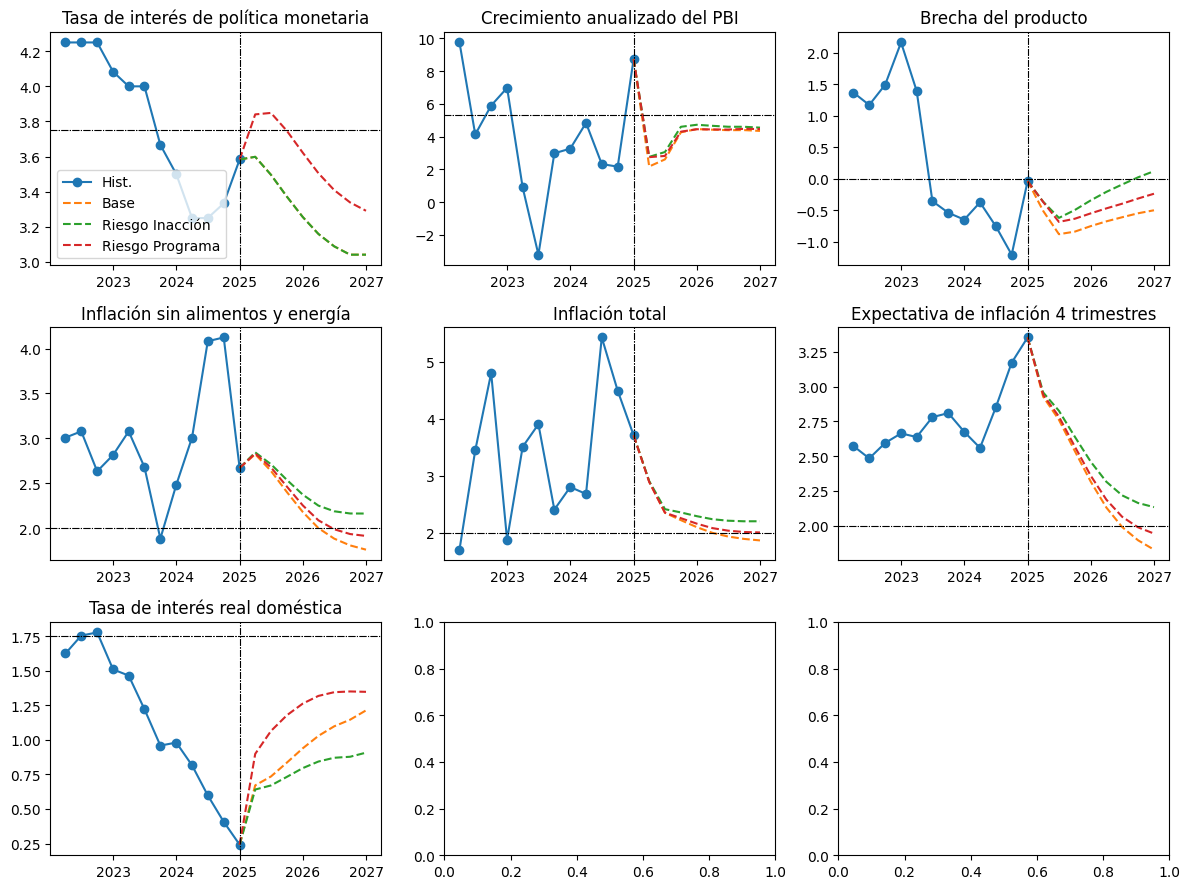

In [90]:
# Variables to plot - Monetary policy and inflation focus
variables = ['i', 'DY', 'y', 'Dpsae', 'Dp', 'ED4p', 'Rmn']

# Descriptive names
nombres = [
    'Tasa de interés de política monetaria',
    'Crecimiento anualizado del PBI',
    'Brecha del producto',
    'Inflación sin alimentos y energía',
    'Inflación total',
    'Expectativa de inflación 4 trimestres',
    'Tasa de interés real doméstica'
]

# Steady-state values
ss_values = [
    3.75,   # i (Rmn_ss + Dp_ss = 1.75 + 2.00)
    5.30,   # DY (DY_ss)
    0.00,   # y
    2.00,   # Dpsae (Dp_ss)
    2.00,   # Dp (Dp_ss)
    2.00,   # ED4p (Dp_ss)
    1.75    # Rmn (Rmn_ss)
]

# Plot configuration (3x3 grid with 2 empty spots)
fig, axs = HTS.plotTSforecast(
    BDdict6,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    3,  # 3 rows
    3   # 3 columns
)

### Brecha Producto

### Cuadros de Impacto

In [91]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo6['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo6['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo6['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo6['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo6['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo6['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo6['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo6['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo6['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.366205   -0.682120   -0.631522   -0.546307   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.244332   -0.455110   -0.421351   
Confianza: aEy*EDy         -0.113765   -0.062858   -0.016152    0.022718   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.467440   -0.267028   -0.262018   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.145228    0.109861    0.084045    0.066451   
Imp. TI: atau*tau          -0.066754   -0.032950   -0.003360    0.017337   
Socios: ays*ys              0.010737    0.020853    0.028197    0.031407   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.467539   -0.393498   -0.311396   -0.235364  
Inercia: (ay+aEy)*y(-1)    -0.364496   -0.311942   -0.262542   -0.207763  
Confianza: aEy*EDy          0.053325    0.076537    0.093684    0.105994  
Cond. Mon.: armc*rmc(-1)   -0.276586   -0.278211   -0.262386   -0.253929  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.054837    0.046287    0.040747    0.037574  
Imp. TI: atau*tau           0.032662    0.040908    0.046096    0.049723  
Socios: ays*ys              0.033060    0.033060    0.033060    0.033060  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [92]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_riesgo6['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_riesgo6['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_riesgo6['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_riesgo6['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_riesgo6['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_riesgo6['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.831583    2.676012   
Inflación importada a 4 trimestres: bm*D4pm        0.155604    0.128382   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.669615   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.050598    1.940930   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.062914   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.461645    2.251907   
Inflación importada a 4 trimestres: bm*D4pm        0.155623    0.133789   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.632826    0.582132   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.790384    1.644482   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.117188   -0.108495   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.086069    1.986440   
Inflación importada a 4 trimestres: bm*D4pm        0.122509    0.134248   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.532533    0.493315   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.524882    1.439200   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.093856   -0.080323   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.932945    1.911681  
Inflación importada a 4 trimestres: bm*D4pm        0.144531    0.153027  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.469755    0.457104  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.386262    1.355048  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.067603   -0.053498  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [93]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_riesgo6['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf     = rho_Ds*UFDB_riesgo6['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_riesgo6['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_riesgo6['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_riesgo6['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_riesgo6['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.921463   -1.341464   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.768585   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.921744    1.299481   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.376334   -5.388089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.915983   -0.290596    0.106949   
Expectativas de depreciación: rho_Ds*Ds    -0.536586   -0.366393   -0.116238   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.536966    1.895509    2.094523   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.244845   -5.070368   -4.907504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.257495    0.539388    0.817395  
Expectativas de depreciación: rho_Ds*Ds     0.042780    0.102998    0.215755  
Tasa interbancaria ME: (1+rho_Ds)*ime       2.133516    2.300187    2.491281  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.773058   -4.674299   -4.607767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [94]:
# Regla de política monetaria
# i = fi*i(-1) + (1 - fi)*( ieq + fp*D4pdev + fy*( cfy*y + (1 - cfy)*y(-1) ) ) + m_res_i*res_i;

fi = 0.700000000000000
fp = 1.500000000000000
fy = 0.500000000000000
cfy = 0.500000000000000
m_res_i = (0.104900000000000)**0.5

hist2show = 4

i = UFDB_riesgo6['i'].values[-(hist2show+FH):].reshape(-1,1)
il = fi*UFDB_riesgo6['i'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ieq = (1-fi)*UFDB_riesgo6['ieq'].values[-(hist2show+FH):].reshape(-1,1)
D4pdev = (1-fi)*fp*UFDB_riesgo6['D4pdev'].values[-(hist2show+FH):].reshape(-1,1)
y = (1-fi)*fy*cfy*UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
yl = (1-fi)*fy*(1-cfy)*UFDB_riesgo6['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_i = m_res_i*UFDB_riesgo6['res_i'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,il,ieq,D4pdev,y,yl,res_i], columns=['TPM: i','Inercia de la TPM: fi*i(-1)','TPM externa: (1-fi)*ieq','Desvío de la inflación meta: (1-fi)*fp*D4pdev','Brecha producto: (1-fi)*fy*cfy*y','Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*y(-1)','Residuo: m_res_i*res_i'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
TPM: i                                                3.250000    3.250000   
Inercia de la TPM: fi*i(-1)                           2.450000    2.275000   
TPM externa: (1-fi)*ieq                               1.082594    1.084530   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.036974    0.192674   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027904   -0.056245   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.048443   -0.027904   
Residuo: m_res_i*res_i                               -0.243221   -0.218054   

                                                    2024-09-30  2024-12-31  \
TPM: i                                                3.333333    3.583333   
Inercia de la TPM: fi*i(-1)                           2.275000    2.333333   
TPM externa: (1-fi)*ieq                               1.095351    1.106369   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.156627    0.225253   
Brecha producto: (1-fi)*fy*cfy*y                     -0.090127   -0.002590   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.056245   -0.090127   
Residuo: m_res_i*res_i                               -0.047271    0.011096   

                                                    2025-03-31  2025-06-30  \
TPM: i                                                3.840239    3.848635   
Inercia de la TPM: fi*i(-1)                           2.508333    2.688167   
TPM externa: (1-fi)*ieq                               1.115685    1.120342   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.023153    0.096187   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027465   -0.051159   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.002590   -0.027465   
Residuo: m_res_i*res_i                                0.223123    0.022563   

                                                    2025-09-30  2025-12-31  \
TPM: i                                                3.746318    3.621692   
Inercia de la TPM: fi*i(-1)                           2.694045    2.622423   
TPM externa: (1-fi)*ieq                               1.122671    1.123836   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.023209   -0.026839   
Brecha producto: (1-fi)*fy*cfy*y                     -0.047364   -0.040973   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.051159   -0.047364   
Residuo: m_res_i*res_i                                0.004917   -0.009390   

                                                    2026-03-31  2026-06-30  \
TPM: i                                                3.505360    3.409327   
Inercia de la TPM: fi*i(-1)                           2.535184    2.453752   
TPM externa: (1-fi)*ieq                               1.124418    1.124709   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.054628   -0.068853   
Brecha producto: (1-fi)*fy*cfy*y                     -0.035065   -0.029512   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.040973   -0.035065   
Residuo: m_res_i*res_i                               -0.023576   -0.035703   

                                                    2026-09-30  2026-12-31  
TPM: i                                                3.338785    3.291262  
Inercia de la TPM: fi*i(-1)                           2.386529    2.337150  
TPM externa: (1-fi)*ieq                               1.124854    1.124927  
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.071755   -0.069572  
Brecha producto: (1-fi)*fy*cfy*y                     -0.023355   -0.017652  
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.029512   -0.023355  
Residuo: m_res_i*res_i                               -0.047976   -0.060236

In [95]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_riesgo6['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_riesgo6['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_riesgo6['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_riesgo6['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_riesgo6['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_riesgo6['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_riesgo6['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_riesgo6['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.840239    3.848635   
Crecimiento PBI real: DY             8.730329    2.747392    2.822669   
Brecha producto: y                  -0.034537   -0.366205   -0.682120   
Inflación SAE: Dpsae                 2.669623    2.831583    2.676012   
Inflación total: Dp                  3.708887    2.891171    2.352524   
Expectativa de inflación: ED4p       3.353472    2.941532    2.784215   
Tasa real en moneda nacional: Rmn    0.241861    0.898707    1.064420   
Depreciación nominal: Ds            14.390420   -1.921463   -1.341464   
Inflación AE: Dpae                   4.993248    2.964812    1.952746   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.746318    3.621692    3.505360   
Crecimiento PBI real: DY             4.300853    4.451336    4.437445   
Brecha producto: y                  -0.631522   -0.546307   -0.467539   
Inflación SAE: Dpsae                 2.461645    2.251907    2.086069   
Inflación total: Dp                  2.256412    2.160290    2.082403   
Expectativa de inflación: ED4p       2.568262    2.358968    2.187406   
Tasa real en moneda nacional: Rmn    1.178056    1.262723    1.317954   
Depreciación nominal: Ds            -0.915983   -0.290596    0.106949   
Inflación AE: Dpae                   2.002777    2.047065    2.077872   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.409327    3.338785    3.291262  
Crecimiento PBI real: DY             4.430312    4.474216    4.461478  
Brecha producto: y                  -0.393498   -0.311396   -0.235364  
Inflación SAE: Dpsae                 1.986440    1.932945    1.911681  
Inflación total: Dp                  2.037280    2.014003    2.006468  
Expectativa de inflación: ED4p       2.064497    1.988558    1.943782  
Tasa real en moneda nacional: Rmn    1.344830    1.350227    1.347480  
Depreciación nominal: Ds             0.257495    0.539388    0.817395  
Inflación AE: Dpae                   2.100109    2.114178    2.123609

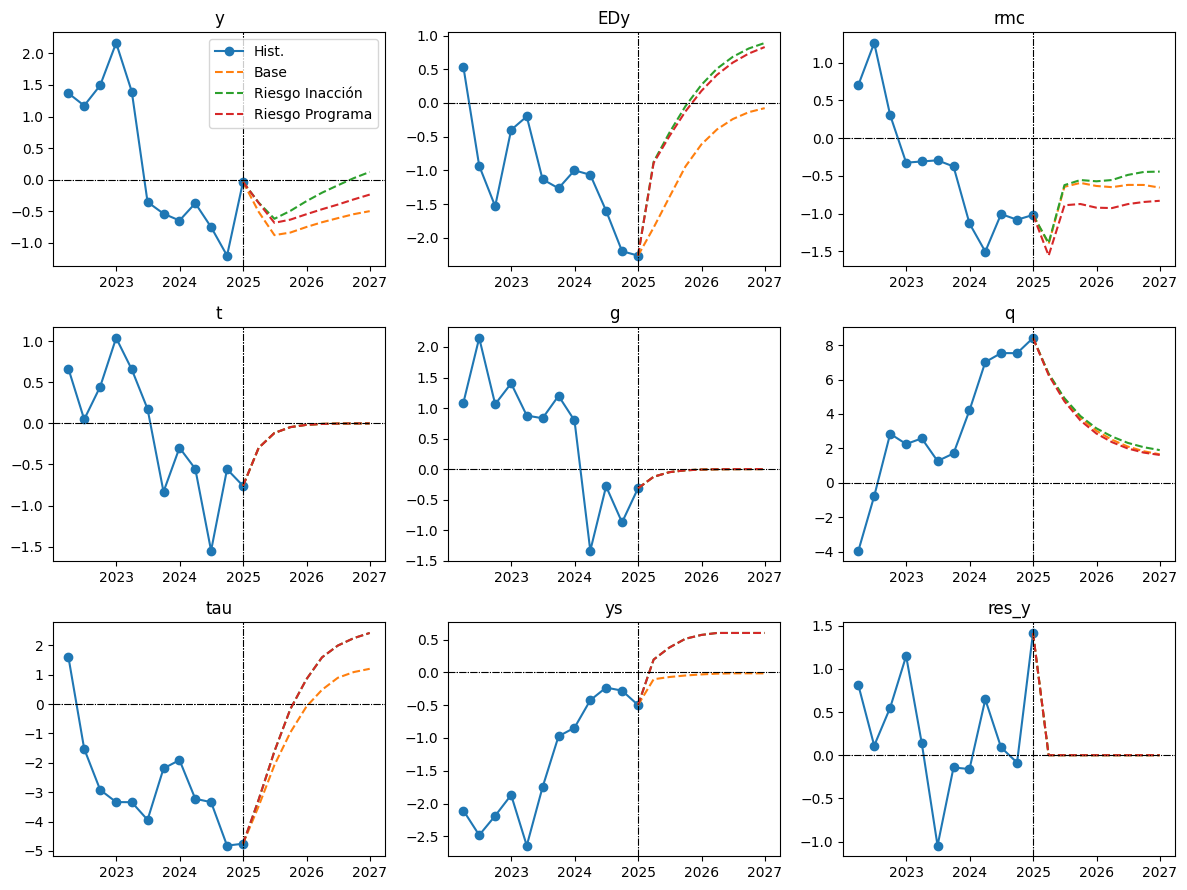

In [96]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,3,3)

# Escenario de riesgo 11: Contracción demanda externa FED hawkish (12%) [BAJAR 1, MANTENER 1, BAJAR] (FINAL)

In [104]:
UCond_riesgo11 = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_Riesgo11.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    # Obtener la senda original
    senda_original = UFDB_base.i.iloc[-FH:].values

    # Crear una copia de la senda para aplicar los recortes
    nueva_senda = np.copy(senda_original)

    nueva_senda[0:2] -= 0.25

    nueva_senda[2:] -= 0.5

    # Asignar la nueva senda con índice corregido
    UCond_riesgo11['Uvar']['var']['i'] = pd.Series(nueva_senda, index=UFDB_base.i.index[-FH:])

    # Agregar el shock correspondiente
    UCond_riesgo11['Uvar']['shock'].append('res_i')

#if tpmfija:
#    # Obtener la senda original
#    senda_original = UFDB_base.i.iloc[-FH:].values
#
#    # Aplicar el recorte de 0.5pbs (0.005) a partir del segundo valor
#    nueva_senda = np.copy(senda_original)
#    nueva_senda[1:] -= 0.5
#
#    # Asignar la nueva senda con índice corregido
#    UCond_riesgo11['Uvar']['var']['i'] = pd.Series(nueva_senda, index=UFDB_base.i.index[-FH:])
#
#    # Agregar el shock correspondiente
#    UCond_riesgo11['Uvar']['shock'].append('res_i')

#if tpmfija:
#    UCond_riesgo11['Uvar']['var']['i'] = UFDB_base.i-0.25
#    UCond_riesgo11['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_riesgo11['UShock'] or UCond_riesgo11['UShock'][var_soft_tune].isna().all():
                UCond_riesgo11['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [105]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo11['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo11['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo11['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0  1.220025e-16   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  9.150190e-17   
2025-09-30      0.0       0.0  

In [106]:
UFDB_riesgo11 = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo11)

UCond_riesgo11no = UCond_riesgo11
UCond_riesgo11no['Uvar']['var']['i'] = UCond_basedove['Uvar']['var']['i']

UFDB_riesgo11no = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo11no)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')
/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [107]:
print(f'Impacto 2025: {round((UFDB_riesgo11.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_riesgo11.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: -0.0
Impacto 2026: -0.0


<ipython-input-107-d6297fee3150>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_riesgo11.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-107-d6297fee3150>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_riesgo11.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


### **Proyecciones**
Esta contracción de la demanda externa (brecha del producto externa), trae consigo tres consecuencias: **Un mayor perfil de tasas de interés externa**, una **menor brecha del producto externa** y una **menor inflación externa**.

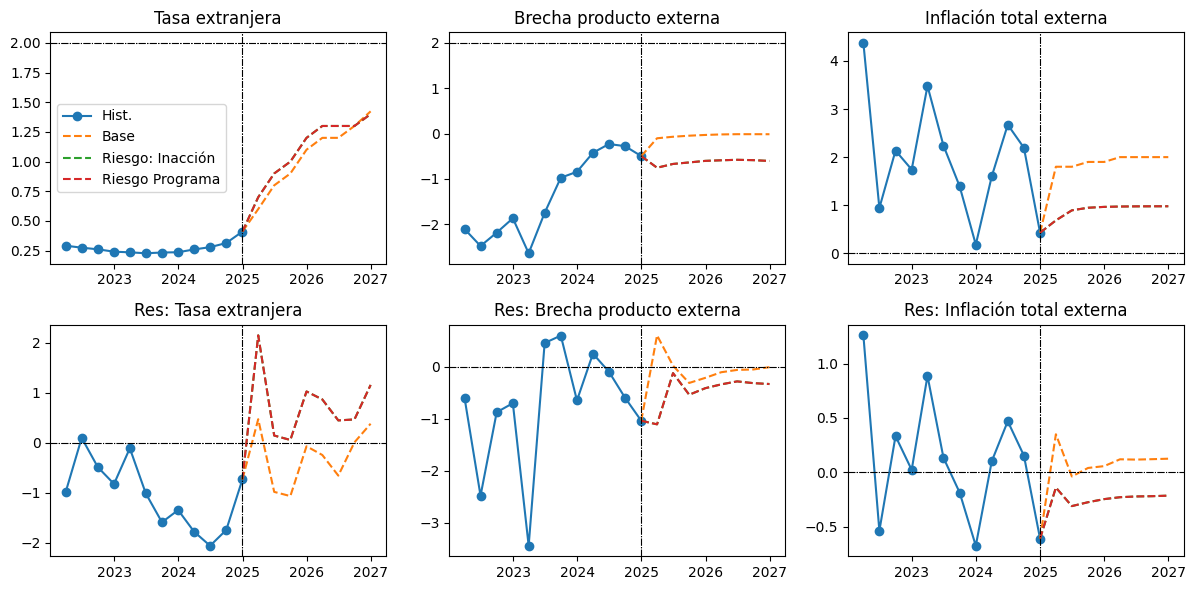

In [108]:
BDdict11 = {'Base': UFDB_basedove, 'Riesgo: Inacción': UFDB_riesgo11no, 'Riesgo Programa': UFDB_riesgo11}
lista = ['iext','ys','Dps','res_iext','res_ys','res_Dps']
listanames = ['Tasa extranjera','Brecha producto externa','Inflación total externa','Res: Tasa extranjera','Res: Brecha producto externa','Res: Inflación total externa']
listaSS = [2,2,0,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,2,3)

### Canal externo (No relevante)

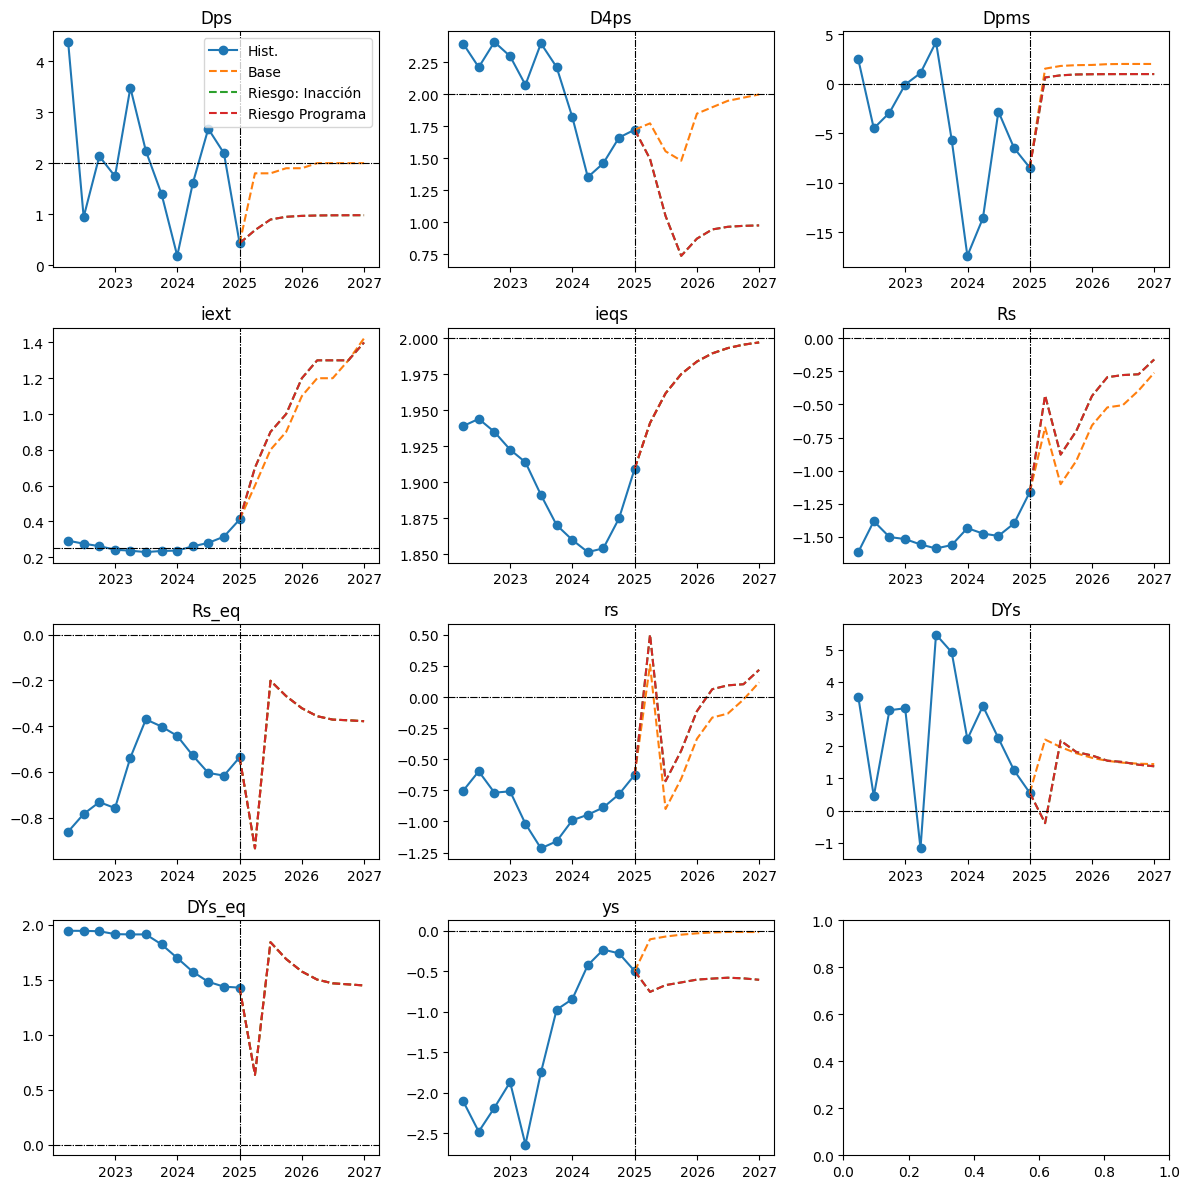

In [109]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['Dps','D4ps','Dpms','iext','ieqs','Rs','Rs_eq','rs','DYs','DYs_eq','ys']
listaSS = [2,2,0,0.25,2,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,4,3)

### **Canal de tasas de interés**
Si se mantuviera la senda del Escenario Base, la **subida de tasas de interés externa** provoca un aumenta de la tasa de interés interbancaria en ME que a su vez genera una **tasa real externa en ME mayor**. Esto **aumenta la brecha de la tasa real externa en ME empeorando las condiciones monetarias**. Esto contribuye a la caída en la brecha del producto.

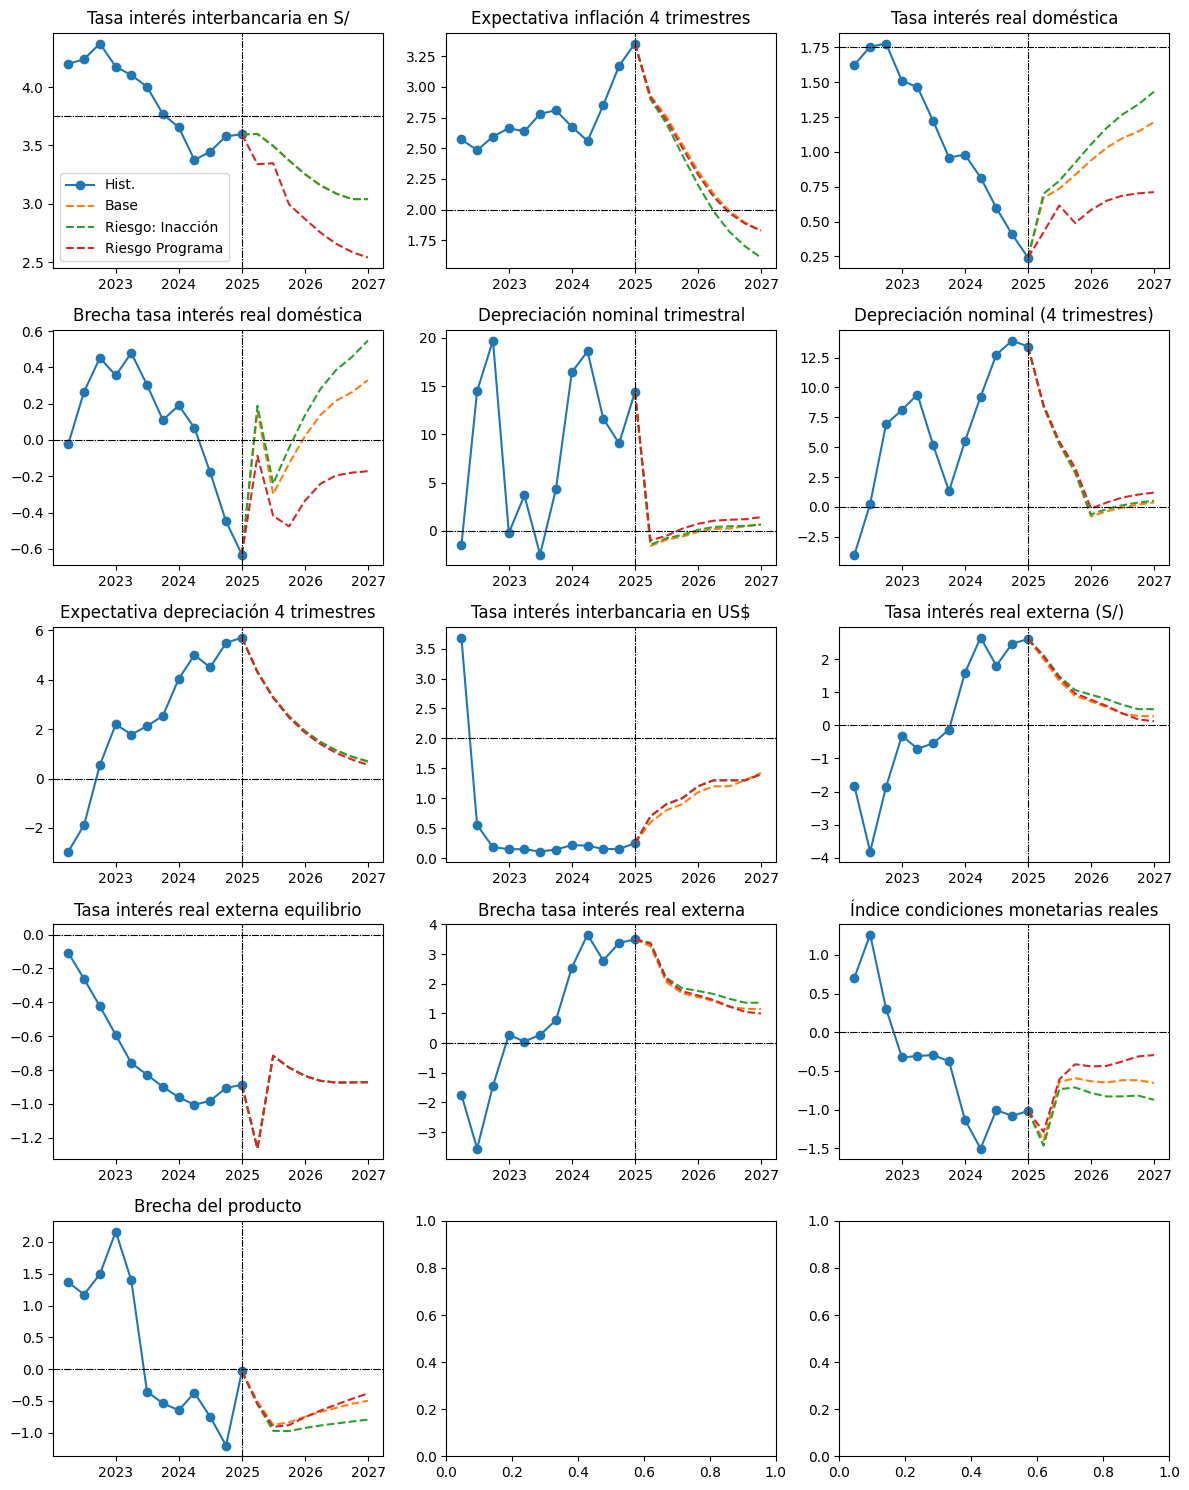

In [119]:
# Variables organizadas por categoría
variables = [
    # Tasas de interés domésticas
    'imn', 'ED4p', 'Rmn', 'rmn',
    # Tipo de cambio y tasas externas
    'Ds', 'D4s', 'ED4s', 'ime', 'Rme', 'Rme_eq', 'rme',
    # Variables macro
    'rmc', 'y'
]

# Nombres descriptivos
nombres = [
    # Tasas de interés domésticas
    'Tasa interés interbancaria en S/',
    'Expectativa inflación 4 trimestres',
    'Tasa interés real doméstica',
    'Brecha tasa interés real doméstica',

    # Tipo de cambio y tasas externas
    'Depreciación nominal trimestral',
    'Depreciación nominal (4 trimestres)',
    'Expectativa depreciación 4 trimestres',
    'Tasa interés interbancaria en US$',
    'Tasa interés real externa (S/)',
    'Tasa interés real externa equilibrio',
    'Brecha tasa interés real externa',

    # Variables macro
    'Índice condiciones monetarias reales',
    'Brecha del producto'
]

# Valores de estado estacionario
ss_values = [
    # Tasas domésticas
    3.75,   # imn (i_ss)
    2.00,   # ED4p (Dp_ss)
    1.75,   # Rmn (Rmn_ss)
    0.00,   # rmn

    # Tipo de cambio y externas
    0.00,   # Ds
    0.00,   # D4s
    0.00,   # ED4s
    2.00,   # ime (iext_ss)
    0.00,   # Rme (Rme_ss)
    0.00,   # Rme_eq
    0.00,   # rme

    # Macro
    0.00,   # rmc
    0.00    # y
]

# Configuración del gráfico (4x3 para 12 variables)
fig, axs = HTS.plotTSforecast(
    BDdict11,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    5,  # 4 filas
    3   # 3 columnas
)

### Canal externo 2 (Tipo de cambio real multilateral) [No relevante]

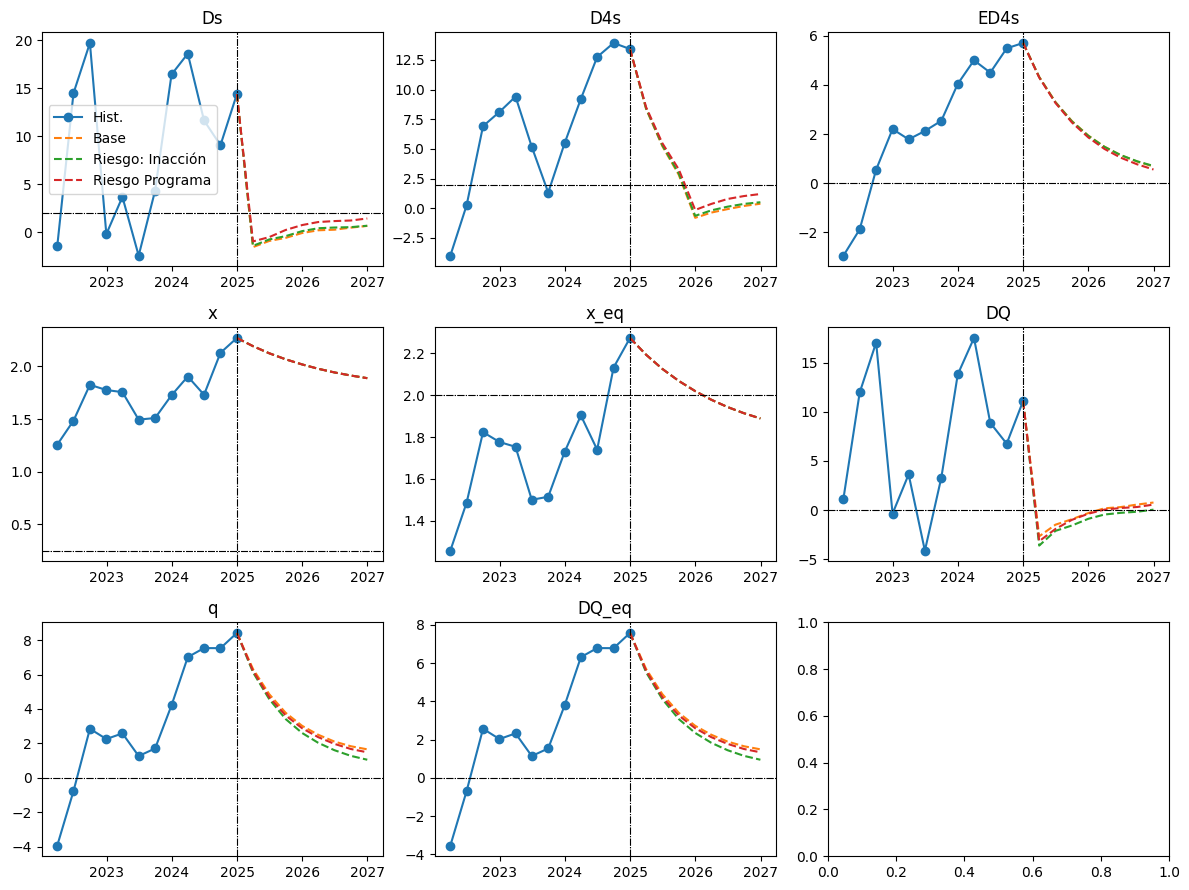

In [111]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['Ds','D4s','ED4s','x','x_eq','DQ','q','DQ_eq']
listaSS = [2,2,0,0.25,2,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,3,3)

### Brecha producto

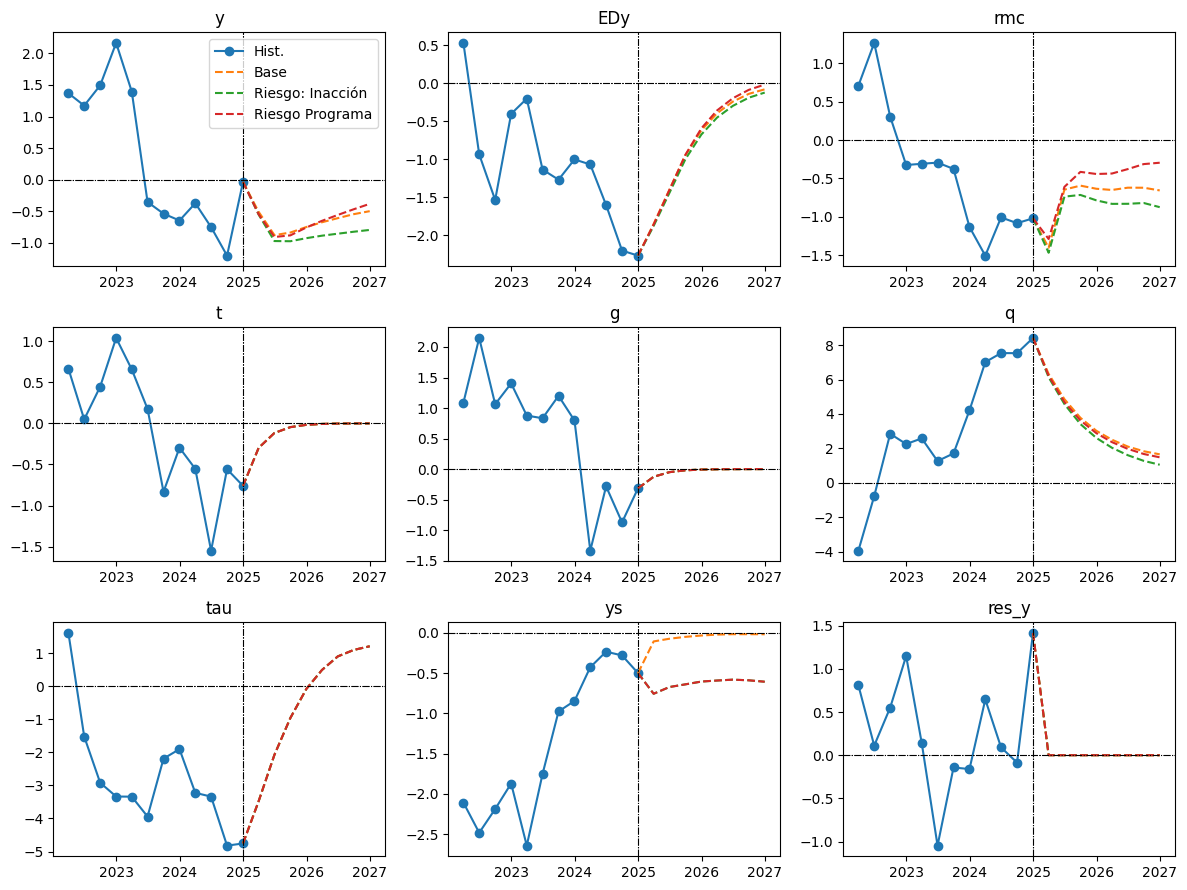

In [112]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,3,3)

### **Canal de expectativas (Inflación)**
Ambos canales anteriores **deterioran la brecha del producto**, lo que provoca, vía curva de Phillips, **una caída en la inflación SAE**, que a su vez **reduce la inflación total** de la economía.
Además, la inflación total se reduce también vía menor inflación externa. Esta **reduce la inflación importada** que **contrae la inflación de alimentos y energía** (más que en el  escenario base) y en consecuencia, la inflación total.
Al caer la inflación SAE y la inflación total las expectativas de inflación **aceleran su caída** con respecto al escenario base.

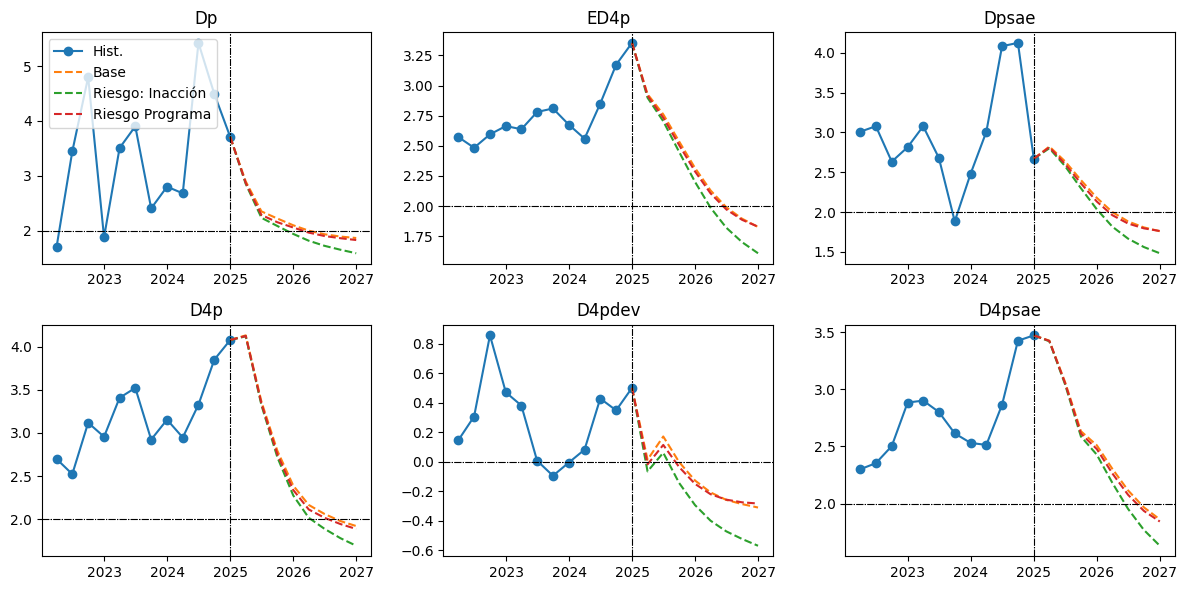

In [120]:
lista = ['Dp','ED4p','Dpsae','D4p','D4pdev','D4psae']
listanames = lista
listaSS = [2,2,2,2,0,2,2]
fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,2,3)

### **Reporte de variables relevantes**
Como respuesta a este shock de demanda negativo, se propone **un primer recorte de 25pbs**, con miras a **mantener la tasa el siguiente trimestre**, mientras se evalúan los primeros efectos del shock. Luego, se pueden **reanudar los recortes**.
La elección de esta senda se explica por la mayor **presión a la baja** de la **inflación total, la inflación SAE, las expectativas** y de la **brecha producto**. Por este motivo, consideramos prudente una **primera reducción de tasas**, para poder **encaminar a la meta a la inflación SAE** y a las **expectativas de inflación**. De lo contrario, se corre el riesgo de que dichas variables se **desanclen por debajo de la meta**, de forma pronunciada. En términos de brecha producto, se consigue una senda similar a la del escenarios base, siendo la **mejora en las condiciones monetarias** el principal driver.


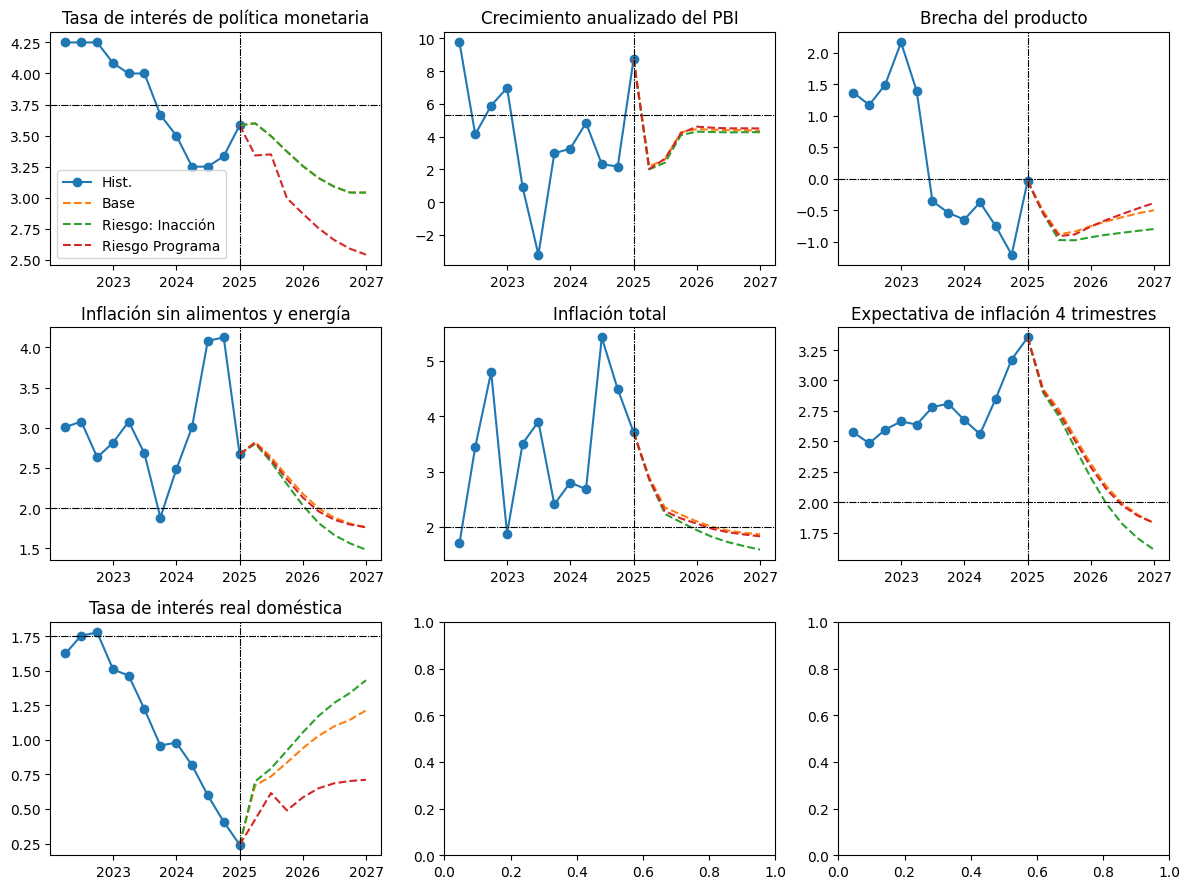

In [121]:
# Variables to plot - Monetary policy and inflation focus
variables = ['i', 'DY', 'y', 'Dpsae', 'Dp', 'ED4p', 'Rmn']

# Descriptive names
nombres = [
    'Tasa de interés de política monetaria',
    'Crecimiento anualizado del PBI',
    'Brecha del producto',
    'Inflación sin alimentos y energía',
    'Inflación total',
    'Expectativa de inflación 4 trimestres',
    'Tasa de interés real doméstica'
]

# Steady-state values
ss_values = [
    3.75,   # i (Rmn_ss + Dp_ss = 1.75 + 2.00)
    5.30,   # DY (DY_ss)
    0.00,   # y
    2.00,   # Dpsae (Dp_ss)
    2.00,   # Dp (Dp_ss)
    2.00,   # ED4p (Dp_ss)
    1.75    # Rmn (Rmn_ss)
]

# Plot configuration (3x3 grid with 2 empty spots)
fig, axs = HTS.plotTSforecast(
    BDdict11,
    variables,
    nombres,
    ss_values,
    FH,
    HH,
    3,  # 3 rows
    3   # 3 columns
)

### Cuadros de impacto

In [115]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo11['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo11['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo11['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo11['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo11['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo11['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo11['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo11['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo11['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo11['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.547244   -0.906519   -0.880381   -0.756078   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.365121   -0.604830   -0.587390   
Confianza: aEy*EDy         -0.237079   -0.179040   -0.119933   -0.075423   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.386318   -0.182740   -0.124330   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.144404    0.108782    0.084101    0.066913   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.041608   -0.037002   -0.035168   -0.033258   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.650530   -0.557557   -0.467420   -0.381953  
Inercia: (ay+aEy)*y(-1)    -0.504455   -0.434033   -0.372002   -0.311863  
Confianza: aEy*EDy         -0.045445   -0.024884   -0.010741   -0.001815  
Cond. Mon.: armc*rmc(-1)   -0.132598   -0.130742   -0.113512   -0.093963  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.054856    0.045796    0.038881    0.034401  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.032554   -0.031959   -0.032400   -0.033375  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [116]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_riesgo11['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_riesgo11['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_riesgo11['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_riesgo11['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_riesgo11['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_riesgo11['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_riesgo11['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_riesgo11.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.813217    2.603543   
Inflación importada a 4 trimestres: bm*D4pm        0.154954    0.126880   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.665272   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.032882    1.905408   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.094016   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.359716    2.131575   
Inflación importada a 4 trimestres: bm*D4pm        0.152377    0.129735   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.615688    0.558028   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.747390    1.595062   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.155740   -0.151249   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.959979    1.855280   
Inflación importada a 4 trimestres: bm*D4pm        0.117571    0.127772   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.504077    0.463497   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.468225    1.375772   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.129894   -0.111761   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.794727    1.761407  
Inflación importada a 4 trimestres: bm*D4pm        0.136645    0.141673  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.438738    0.424419  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.315132    1.275617  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.095788   -0.080303  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [117]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_riesgo11['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf     = rho_Ds*UFDB_riesgo11['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_riesgo11['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_riesgo11['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_riesgo11['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_riesgo11['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_riesgo11.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -0.979034   -0.528498   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.391613   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.980000    1.260000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -4.676334   -4.688089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                 0.214701    0.725819    1.042244   
Expectativas de depreciación: rho_Ds*Ds    -0.211399    0.085880    0.290328   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.400000    1.680000    1.820000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.194845   -4.020368   -3.857504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 1.142167    1.202161    1.414364  
Expectativas de depreciación: rho_Ds*Ds     0.416898    0.456867    0.480864  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.820000    1.820000    1.960000  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -3.723058   -3.624299   -3.557767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [118]:
# Regla de política monetaria
# i = fi*i(-1) + (1 - fi)*( ieq + fp*D4pdev + fy*( cfy*y + (1 - cfy)*y(-1) ) ) + m_res_i*res_i;

fi = 0.700000000000000
fp = 1.500000000000000
fy = 0.500000000000000
cfy = 0.500000000000000
m_res_i = (0.104900000000000)**0.5

hist2show = 4

i = UFDB_riesgo11['i'].values[-(hist2show+FH):].reshape(-1,1)
il = fi*UFDB_riesgo11['i'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ieq = (1-fi)*UFDB_riesgo11['ieq'].values[-(hist2show+FH):].reshape(-1,1)
D4pdev = (1-fi)*fp*UFDB_riesgo11['D4pdev'].values[-(hist2show+FH):].reshape(-1,1)
y = (1-fi)*fy*cfy*UFDB_riesgo11['y'].values[-(hist2show+FH):].reshape(-1,1)
yl = (1-fi)*fy*(1-cfy)*UFDB_riesgo11['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_i = m_res_i*UFDB_riesgo11['res_i'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,il,ieq,D4pdev,y,yl,res_i], columns=['TPM: i','Inercia de la TPM: fi*i(-1)','TPM externa: (1-fi)*ieq','Desvío de la inflación meta: (1-fi)*fp*D4pdev','Brecha producto: (1-fi)*fy*cfy*y','Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*y(-1)','Residuo: m_res_i*res_i'], index=UFDB_riesgo11.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
TPM: i                                                3.250000    3.250000   
Inercia de la TPM: fi*i(-1)                           2.450000    2.275000   
TPM externa: (1-fi)*ieq                               1.082594    1.084530   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.036974    0.192674   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027904   -0.056245   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.048443   -0.027904   
Residuo: m_res_i*res_i                               -0.243221   -0.218054   

                                                    2024-09-30  2024-12-31  \
TPM: i                                                3.333333    3.583333   
Inercia de la TPM: fi*i(-1)                           2.275000    2.333333   
TPM externa: (1-fi)*ieq                               1.095351    1.106369   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.156627    0.225253   
Brecha producto: (1-fi)*fy*cfy*y                     -0.090127   -0.002590   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.056245   -0.090127   
Residuo: m_res_i*res_i                               -0.047271    0.011096   

                                                    2025-03-31  2025-06-30  \
TPM: i                                                3.340239    3.348635   
Inercia de la TPM: fi*i(-1)                           2.508333    2.338167   
TPM externa: (1-fi)*ieq                               1.115685    1.120342   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.007919    0.051296   
Brecha producto: (1-fi)*fy*cfy*y                     -0.041043   -0.067989   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.002590   -0.041043   
Residuo: m_res_i*res_i                               -0.232227   -0.052138   

                                                    2025-09-30  2025-12-31  \
TPM: i                                                2.996318    2.871692   
Inercia de la TPM: fi*i(-1)                           2.344045    2.097423   
TPM externa: (1-fi)*ieq                               1.122671    1.123836   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.016048   -0.067379   
Brecha producto: (1-fi)*fy*cfy*y                     -0.066029   -0.056706   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.067989   -0.066029   
Residuo: m_res_i*res_i                               -0.320333   -0.159453   

                                                    2026-03-31  2026-06-30  \
TPM: i                                                2.755360    2.659327   
Inercia de la TPM: fi*i(-1)                           2.010184    1.928752   
TPM externa: (1-fi)*ieq                               1.124418    1.124709   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.098869   -0.115448   
Brecha producto: (1-fi)*fy*cfy*y                     -0.048790   -0.041817   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.056706   -0.048790   
Residuo: m_res_i*res_i                               -0.174878   -0.188080   

                                                    2026-09-30  2026-12-31  
TPM: i                                                2.588785    2.541262  
Inercia de la TPM: fi*i(-1)                           1.861529    1.812150  
TPM externa: (1-fi)*ieq                               1.124854    1.124927  
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.123547   -0.127268  
Brecha producto: (1-fi)*fy*cfy*y                     -0.035056   -0.028646  
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.041817   -0.035056  
Residuo: m_res_i*res_i                               -0.197177   -0.204844